# Advanced Machine Learning - programming assignment 2

**Please fill in:**
* Ernö Groeneweg (4279662)
* Otto Mättas (6324363)
* Vincent de Wit (6970877)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set.

In [1]:
import numpy as np
import itertools
import graphviz # conda install python-graphviz

The graphviz can draw graphs to different file formats, or show them directly in the notebook. We will use numpy arrays to represent graphs. The following function converts such an array to a graph in graphviz format. 

In [2]:
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

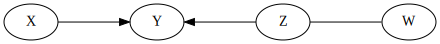

In [3]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a function that performs the PC algorithm. Add the missing code for phase 2, and implement phases 3 and 4.

In [4]:
def PC_algorithm(n, independence_tester):
    # PHASE I: Initialization
    # The matrix G represents a graph as follows:
    # - For all x, G[x,x] == False
    # - G[x,y] == False and G[y,x] == False: no edge between x and y
    # - G[x,y] == True  and G[y,x] == True:  undirected edge x --- y
    # - G[x,y] == True  and G[y,x] == False: directed edge x --> y
    G = np.logical_not(np.eye(n, dtype=bool))

    # PHASE II: Skeleton search
    # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
    sepset = dict()
    for k in range(n-1):
        for x in range(n):
            for y in range(n):
                if not G[x,y]:
                    continue
                # Try all subsets S of Adj(x) \ {y} with |S|=k,
                # until an independence is found.
                # Hint: use itertools.combinations
                
                # Your code here
                # G[x,y] is true here , this means that y is adjacent to x
                # for all S subset of adjacent nodes to x not including y, with size of S: |S|=k
                l = [i for i in range(n) if (i != y and i != x)] # range n excluding y and x since adj to x
                Set = itertools.combinations(l,k) # all combinations of length k
                
                for S in Set:
                    indep = independence_tester.test_independence(x, y, S)
                    if indep:
                        print("independence found: {0} and {1} given {2}".format(x,y,S))
                        G[x,y] = G[y,x] = False
                        S_mask = np.zeros(n, dtype=bool)
                        np.put(S_mask, S, True)
                        sepset[frozenset([x,y])] = S_mask
                        break
        # Do we need to continue with smaller k? ....
        max_S_size = np.sum(G, axis=0) - 1
        if np.all(max_S_size < k + 1):
            break

    # PHASE III: Orient v-structures
    # Something to watch out for:
    # If the data are not faithful to any graph, the algorithm may end up trying
    # to orient a single edge in two different ways. You can choose either
    # orientation if this happens.

    # Your code here
    # for two not adjacent nodes connected to a third node
    # check if this third node is in the sepset of the two
    # not connected nodes. When the third node is not in
    # the sepset, the two first nodes collide in the third.

    for x in range(n-1):
        for y in range(x,n):
            # if x and y not adjacent
            if G[x,y] == G[y,x] == False and x != y:
                for z in range(n):
                    
                    # when z is adjacent to x and to y
                    if G[x,z] == False and G[z,x] == False:
                        continue
                    if G[y,z] == False and G[z,y] == False:
                        continue
                        
                    # unordered when atleast one edge is undirected
                    if not (G[x,z]==G[z,x]==True or G[y,z]==G[z,y]==True):
                        continue
                        
                    # if z not in sepset({x,y}):
                    if not sepset[frozenset([x,y])][z]:
                        # orient edges
                        G[z,x] = G[z,y] = False
                        
        # Not implemented "Something to watch out for" I do not understand when this exactly would happen...

    # PHASE IV: Orientation rules

    # Your code here
    # no extra v-structures, no cycles
    
    # undirected edges
    for x in range(n):
        for y in range(n):
            # if x and y adjacent and undirected
            if not(G[x,y] == G[y,x] == True and x != y):
                continue
                
            # x and y adjacent and undirected
            for z in range(n):
                # remove cases where z is either x or y
                if z == x or z == y:
                    continue
                if G[x,z] == False and G[z,x] == True:
                    # Rule 1
                    if G[y,z] == False and G[z,y] == False:
                        G[y,x] = False
                        break
                    # Rule 2
                    if G[y,z] == True and G[z,y] == False:
                        G[x,y] = False
                        break
                # Rule 3    
                for q in range(n):
                    if q == z or q == x or q == y:
                        continue
                    if G[x,z] == G[z,x] == True and G[x,q] == G[q,x] == True:
                        if G[z,y] == True and G[y,z] == False:
                            if G[q,y] == True and G[y,q] == False:
                                G[y,x] = False

    '''
    rule 1: When a node has an incoming edge and an undirected edge
                    then the undirected edge becomes a directed outgoing edge.
    rule 2: When two nodes are connected by an undirected edge and 
                have a directed chain connecting them via a third node
                    then the undirected edge becomes a directed edge with the same direction as the chain.
    rule 3: When two nodes are connected by an undirected edge and
                one node has two incoming edges that 'relate' to the 'other' node
                    then the undirected edge becomes a directed edge directed at the node with incoming edges.
    '''
    

    return G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an /oracle/ instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, PC should be able to recover the Markov equivalence class of the true graph.

In [5]:
def is_d_connected_dfs(mB, pos, w, S, vis):
    # Made modifications to deal with CPDAGs as input
    #print("At ", pos)
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v])
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

class IndependenceOracle:
    def __init__(self, true_G):
        self.G = true_G
        self.n = true_G.shape[0]
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        #S_mask[S] = True
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph G1 we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

independence found: 0 and 2 given ()
independence found: 0 and 3 given ()
independence found: 1 and 3 given (2,)
CORRECT


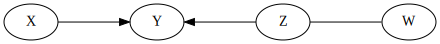

In [6]:
oracle = IndependenceOracle(G1)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G1) else "INCORRECT")
graph_to_graphviz(G, node_names)

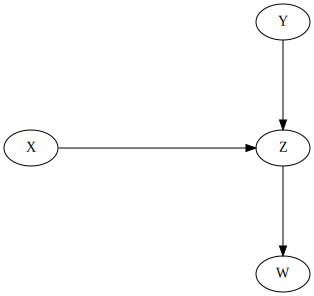

In [7]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (2,)
independence found: 1 and 3 given (2,)
CORRECT


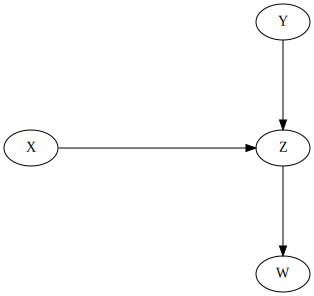

In [8]:
oracle = IndependenceOracle(G2)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G2) else "INCORRECT")
graph_to_graphviz(G, node_names)

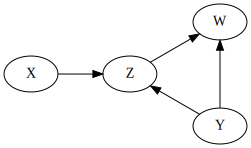

In [9]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (1, 2)
CORRECT


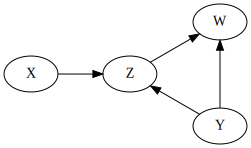

In [10]:
oracle = IndependenceOracle(G3)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G3) else "INCORRECT")
graph_to_graphviz(G, node_names)

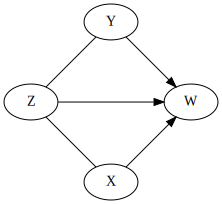

In [11]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: 0 and 1 given (2,)
CORRECT


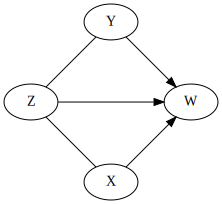

In [12]:
oracle = IndependenceOracle(G4)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G4) else "INCORRECT")
graph_to_graphviz(G, node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled 'experiment', indicates in which way that cell was prepared. We can think of experiment=1 as denoting the observational data, and other values of experiment (2 through 14) as various interventional datasets.

In [13]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking a logarithm
all_data.loc[:, all_data.columns != 'experiment'] = np.log(all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [32]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp1 = data_exp1.drop(columns='experiment')
data_exp1

praf      pmek      plcg      PIP2      PIP3      perk  pakts473  \
0    3.273364  2.580217  2.177022  2.906901  4.074142  1.888584  2.833213   
1    3.580737  2.803360  2.509599  2.821379  2.095561  2.923162  3.481240   
2    4.084294  3.786460  2.681022  2.322388  2.564949  2.701361  3.481240   
3    4.290459  4.416428  3.139833  2.602690  0.254642  1.763017  2.468100   
4    3.517498  2.985682  1.646734  2.275214  3.210844  3.049273  3.830813   
..        ...       ...       ...       ...       ...       ...       ...   
848  3.742420  3.317816  3.068053  4.218036  2.509599  2.113843  2.760010   
849  4.128746  3.077312  2.257588  1.870263  3.535145  2.727853  3.139833   
850  4.634729  3.471966  2.322388  2.580217  3.929863  1.663926  1.726332   
851  4.352855  3.165475  3.210844  4.100989  3.795489  3.068053  3.218876   
852  3.841601  2.708050  2.141242  4.787492  3.104587  1.808289  2.995732   

          PKA       PKC       P38      pjnk  
0    6.025866  2.833213  3.804438  3.688879  
1    5.863631  1.214913  2.803360  4.119037  
2    5.998937  2.433613  3.462606  2.970414  
3    6.269096  2.617396  3.353407  3.139833  
4    5.720312  1.539015  3.246491  4.398146  
..        ...       ...       ...       ...  
848  6.331502  3.086487  3.391147  2.113843  
849  5.765191  2.476538  3.569533  3.929863  
850  5.476464  2.674149  3.131137  1.654411  
851  5.666427  3.471966  4.424847  3.299534  
852  6.169611  3.039749  3.605498  2.266958  

[853 rows x 11 columns]

To run the PC algorithm on data, we need to perform (conditional) independence tests. The package [tigramite](https://github.com/jakobrunge/tigramite) implements several such tests. The simplest of these tests is ParCorr(). It assumes the data come from a linear model, which they actually don't. We will use it anyway, because the alternatives (such as CMIknn() (Runge, 2018)) are more effort to install and orders of magnitude slower.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a (much) larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [15]:
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        print("test: {0} and {1} given {2} -> pval={3}".format(x,y,S,pval))
        return pval > self.alpha

Could not import rpy package
Could not import r-package RCIT


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should have just one or two connected components.

test: 0 and 1 given () -> pval=2.763329247780076e-116
test: 0 and 2 given () -> pval=0.7345031780389382
test: 0 and 3 given () -> pval=0.71471430309364
test: 0 and 4 given () -> pval=0.4639779567396791
test: 0 and 5 given () -> pval=0.49429391475369555
test: 0 and 6 given () -> pval=0.24104570427628091
test: 0 and 7 given () -> pval=0.8820017123329297
test: 0 and 8 given () -> pval=0.3264140832119329
test: 0 and 9 given () -> pval=0.11406363143778012
test: 0 and 10 given () -> pval=0.7733481517890715
test: 1 and 0 given () -> pval=2.763329247780076e-116
test: 1 and 2 given () -> pval=0.9899798095695265
test: 1 and 3 given () -> pval=0.635714994558713
test: 1 and 4 given () -> pval=0.10214212173643895
test: 1 and 5 given () -> pval=0.4933592008794341
test: 1 and 6 given () -> pval=0.6690696298281074
test: 1 and 7 given () -> pval=0.8497598619549872
test: 1 and 8 given () -> pval=0.22082841697061162
test: 1 and 9 given () -> pval=0.22484176830844702
test: 1 and 10 given () -> pval=0.1823

test: 1 and 4 given (0,) -> pval=0.1216004849126408
test: 1 and 4 given (2,) -> pval=0.10117414053751542
test: 1 and 4 given (3,) -> pval=0.11712031348094101
test: 1 and 4 given (5,) -> pval=0.0991348630182466
test: 1 and 4 given (6,) -> pval=0.10495661340000897
test: 1 and 4 given (7,) -> pval=0.10188811901074354
test: 1 and 4 given (8,) -> pval=0.09907308663105228
test: 1 and 4 given (9,) -> pval=0.10094480127068799
test: 1 and 4 given (10,) -> pval=0.09454698116455276
test: 1 and 5 given (0,) -> pval=0.11752611178166465
test: 1 and 5 given (2,) -> pval=0.4935940612192228
test: 1 and 5 given (3,) -> pval=0.5048517823390047
test: 1 and 5 given (4,) -> pval=0.4710916322703449
test: 1 and 5 given (6,) -> pval=0.06995727890643506
test: 1 and 5 given (7,) -> pval=0.4226647061002067
test: 1 and 5 given (8,) -> pval=0.4735878859644709
test: 1 and 5 given (9,) -> pval=0.5062047884115185
test: 1 and 5 given (10,) -> pval=0.5014025281417727
test: 1 and 6 given (0,) -> pval=0.6159740280408099
t

test: 4 and 6 given (1,) -> pval=0.37847999316532444
test: 4 and 6 given (2,) -> pval=0.3359414203607176
test: 4 and 6 given (3,) -> pval=0.25995047131170995
test: 4 and 6 given (5,) -> pval=0.491854806287748
test: 4 and 6 given (7,) -> pval=0.2601972017816391
test: 4 and 6 given (8,) -> pval=0.362363430595797
test: 4 and 6 given (9,) -> pval=0.3661618685004945
test: 4 and 6 given (10,) -> pval=0.3661987383596228
test: 4 and 7 given (0,) -> pval=0.7506882107836844
test: 4 and 7 given (1,) -> pval=0.7451635127153367
test: 4 and 7 given (2,) -> pval=0.7087286787918985
test: 4 and 7 given (3,) -> pval=0.9661127826306549
test: 4 and 7 given (5,) -> pval=0.5700789277662248
test: 4 and 7 given (6,) -> pval=0.45809687996918125
test: 4 and 7 given (8,) -> pval=0.7668976931666495
test: 4 and 7 given (9,) -> pval=0.7571340445998489
test: 4 and 7 given (10,) -> pval=0.7452862097597925
test: 4 and 8 given (0,) -> pval=0.7168942729118495
test: 4 and 8 given (1,) -> pval=0.6838787982472865
test: 4 a

test: 7 and 3 given (1,) -> pval=0.3103740719450586
test: 7 and 3 given (2,) -> pval=0.3010038946858175
test: 7 and 3 given (4,) -> pval=0.3359555065854981
test: 7 and 3 given (5,) -> pval=0.5099338919126349
test: 7 and 3 given (6,) -> pval=0.36085735107964867
test: 7 and 3 given (8,) -> pval=0.2980011791631262
test: 7 and 3 given (9,) -> pval=0.3206886321529363
test: 7 and 3 given (10,) -> pval=0.3100296807016326
test: 7 and 4 given (0,) -> pval=0.7506882107836842
test: 7 and 4 given (1,) -> pval=0.7451635127153367
test: 7 and 4 given (2,) -> pval=0.7087286787918985
test: 7 and 4 given (3,) -> pval=0.9661127826306549
test: 7 and 4 given (5,) -> pval=0.570078927766225
test: 7 and 4 given (6,) -> pval=0.4580968799691806
test: 7 and 4 given (8,) -> pval=0.7668976931666495
test: 7 and 4 given (9,) -> pval=0.7571340445998487
test: 7 and 4 given (10,) -> pval=0.7452862097597923
test: 7 and 5 given (0,) -> pval=5.1576269644219237e-26
test: 7 and 5 given (1,) -> pval=4.693795750408172e-26
tes

test: 10 and 4 given (8,) -> pval=0.3837726570364759
test: 10 and 4 given (9,) -> pval=0.42590802239860215
test: 10 and 5 given (0,) -> pval=0.7808632782882277
test: 10 and 5 given (1,) -> pval=0.7995721873795256
test: 10 and 5 given (2,) -> pval=0.7363420974737647
test: 10 and 5 given (3,) -> pval=0.7674155444197273
test: 10 and 5 given (4,) -> pval=0.788488563614588
test: 10 and 5 given (6,) -> pval=0.6135362854877725
test: 10 and 5 given (7,) -> pval=0.8777014578590031
test: 10 and 5 given (8,) -> pval=0.890803700196044
test: 10 and 5 given (9,) -> pval=0.7469719894249456
test: 10 and 6 given (0,) -> pval=0.9869992413765334
test: 10 and 6 given (1,) -> pval=0.9881728377787404
test: 10 and 6 given (2,) -> pval=0.9818995732361457
test: 10 and 6 given (3,) -> pval=0.9995231113636212
test: 10 and 6 given (4,) -> pval=0.9768329217746097
test: 10 and 6 given (5,) -> pval=0.6766332746992948
test: 10 and 6 given (7,) -> pval=0.8552804915836674
test: 10 and 6 given (8,) -> pval=0.89087117846

test: 0 and 6 given (7, 9) -> pval=0.2162805011180782
test: 0 and 6 given (7, 10) -> pval=0.22383035277037935
test: 0 and 6 given (8, 9) -> pval=0.24407985661984552
test: 0 and 6 given (8, 10) -> pval=0.24980989364866757
test: 0 and 6 given (9, 10) -> pval=0.24342873121830083
test: 0 and 7 given (1, 2) -> pval=0.9863616161020179
test: 0 and 7 given (1, 3) -> pval=0.9955756525196644
test: 0 and 7 given (1, 4) -> pval=0.9830309966026469
test: 0 and 7 given (1, 5) -> pval=0.5774526402499924
test: 0 and 7 given (1, 6) -> pval=0.6169300300351146
test: 0 and 7 given (1, 8) -> pval=0.9870702781817575
test: 0 and 7 given (1, 9) -> pval=0.9898747204740042
test: 0 and 7 given (1, 10) -> pval=0.9967254307732138
test: 0 and 7 given (2, 3) -> pval=0.8984972452727636
test: 0 and 7 given (2, 4) -> pval=0.8808283001976585
test: 0 and 7 given (2, 5) -> pval=0.9115106909842794
test: 0 and 7 given (2, 6) -> pval=0.7135807205360309
test: 0 and 7 given (2, 8) -> pval=0.9285488035705645
test: 0 and 7 given 

test: 1 and 3 given (9, 10) -> pval=0.6100058334325964
test: 1 and 4 given (0, 2) -> pval=0.11399695640485098
test: 1 and 4 given (0, 3) -> pval=0.19886990270654797
test: 1 and 4 given (0, 5) -> pval=0.1135766987706972
test: 1 and 4 given (0, 6) -> pval=0.1180085885155085
test: 1 and 4 given (0, 7) -> pval=0.12147740636558033
test: 1 and 4 given (0, 8) -> pval=0.11940067114509799
test: 1 and 4 given (0, 9) -> pval=0.12154127216230909
test: 1 and 4 given (0, 10) -> pval=0.10795864490072363
test: 1 and 4 given (2, 3) -> pval=0.11597445033696709
test: 1 and 4 given (2, 5) -> pval=0.09765587490423358
test: 1 and 4 given (2, 6) -> pval=0.1041305824258006
test: 1 and 4 given (2, 7) -> pval=0.10083478246883591
test: 1 and 4 given (2, 8) -> pval=0.09774574727950283
test: 1 and 4 given (2, 9) -> pval=0.09977521332665053
test: 1 and 4 given (2, 10) -> pval=0.09470537164876512
test: 1 and 4 given (3, 5) -> pval=0.11128792055207527
test: 1 and 4 given (3, 6) -> pval=0.1210025853005818
test: 1 and 

test: 1 and 10 given (3, 9) -> pval=0.15167499041016122
test: 1 and 10 given (4, 5) -> pval=0.16993229567274512
test: 1 and 10 given (4, 6) -> pval=0.16810362177832527
test: 1 and 10 given (4, 7) -> pval=0.16707153681480472
test: 1 and 10 given (4, 8) -> pval=0.09545668788805153
test: 1 and 10 given (4, 9) -> pval=0.14001695136517658
test: 1 and 10 given (5, 6) -> pval=0.19246065510813454
test: 1 and 10 given (5, 7) -> pval=0.18319052557989843
test: 1 and 10 given (5, 8) -> pval=0.10703289339870442
test: 1 and 10 given (5, 9) -> pval=0.15528540322372972
test: 1 and 10 given (6, 7) -> pval=0.18271247913939442
test: 1 and 10 given (6, 8) -> pval=0.10678140771305974
test: 1 and 10 given (6, 9) -> pval=0.15330023391983988
test: 1 and 10 given (7, 8) -> pval=0.10631894665045377
test: 1 and 10 given (7, 9) -> pval=0.15280984225851238
test: 1 and 10 given (8, 9) -> pval=0.11320289977039354
test: 2 and 0 given (1, 3) -> pval=0.6293627806834399
test: 2 and 0 given (1, 4) -> pval=0.6182292796090

test: 2 and 7 given (1, 3) -> pval=0.4983679900965019
test: 2 and 7 given (1, 4) -> pval=0.5006780077834446
test: 2 and 7 given (1, 5) -> pval=0.2667052427903836
test: 2 and 7 given (1, 6) -> pval=0.33269408945693835
test: 2 and 7 given (1, 8) -> pval=0.5370810205794649
test: 2 and 7 given (1, 9) -> pval=0.5276863906713254
test: 2 and 7 given (1, 10) -> pval=0.5330761977596887
test: 2 and 7 given (3, 4) -> pval=0.49914639909306324
test: 2 and 7 given (3, 5) -> pval=0.25718294903468647
test: 2 and 7 given (3, 6) -> pval=0.316766326601603
test: 2 and 7 given (3, 8) -> pval=0.5133188023554354
test: 2 and 7 given (3, 9) -> pval=0.5048896973477842
test: 2 and 7 given (3, 10) -> pval=0.5097047612407275
test: 2 and 7 given (4, 5) -> pval=0.24306817808555045
test: 2 and 7 given (4, 6) -> pval=0.29785607209721604
test: 2 and 7 given (4, 8) -> pval=0.5177854966164477
test: 2 and 7 given (4, 9) -> pval=0.507793084371225
test: 2 and 7 given (4, 10) -> pval=0.512141460037942
test: 2 and 7 given (5,

test: 3 and 4 given (0, 8) -> pval=5.073980088544553e-26
test: 3 and 4 given (0, 9) -> pval=5.733347737990569e-26
test: 3 and 4 given (0, 10) -> pval=5.882100781185524e-26
test: 3 and 4 given (1, 2) -> pval=1.221255407265143e-25
test: 3 and 4 given (1, 5) -> pval=4.8528406460817163e-26
test: 3 and 4 given (1, 6) -> pval=5.871818859365266e-26
test: 3 and 4 given (1, 7) -> pval=7.745849352455923e-26
test: 3 and 4 given (1, 8) -> pval=6.566875286031065e-26
test: 3 and 4 given (1, 9) -> pval=7.488270737922803e-26
test: 3 and 4 given (1, 10) -> pval=7.685283992882733e-26
test: 3 and 4 given (2, 5) -> pval=7.085936006917684e-26
test: 3 and 4 given (2, 6) -> pval=8.665868022049239e-26
test: 3 and 4 given (2, 7) -> pval=1.1766635015275288e-25
test: 3 and 4 given (2, 8) -> pval=9.864766570127776e-26
test: 3 and 4 given (2, 9) -> pval=1.1091146870787275e-25
test: 3 and 4 given (2, 10) -> pval=1.1268580105138682e-25
test: 3 and 4 given (5, 6) -> pval=5.1582494162668917e-26
test: 3 and 4 given (5,

test: 3 and 10 given (6, 7) -> pval=0.7716155829365199
test: 3 and 10 given (6, 8) -> pval=0.8637666667690865
test: 3 and 10 given (6, 9) -> pval=0.7537046015622593
test: 3 and 10 given (7, 8) -> pval=0.859495861654391
test: 3 and 10 given (7, 9) -> pval=0.7452089845553528
test: 3 and 10 given (8, 9) -> pval=0.9035293917352666
test: 4 and 0 given (1, 2) -> pval=0.5780618435643474
test: 4 and 0 given (1, 3) -> pval=0.842268717107258
test: 4 and 0 given (1, 5) -> pval=0.5826521940279508
test: 4 and 0 given (1, 6) -> pval=0.5822600113659384
test: 4 and 0 given (1, 7) -> pval=0.608055150436704
test: 4 and 0 given (1, 8) -> pval=0.6098246772772277
test: 4 and 0 given (1, 9) -> pval=0.612446815832333
test: 4 and 0 given (1, 10) -> pval=0.573946500491505
test: 4 and 0 given (2, 3) -> pval=0.37289715298026715
test: 4 and 0 given (2, 5) -> pval=0.4922470604935071
test: 4 and 0 given (2, 6) -> pval=0.5055746267450886
test: 4 and 0 given (2, 7) -> pval=0.4804360529714794
test: 4 and 0 given (2, 8

test: 4 and 6 given (5, 7) -> pval=0.40646907238196806
test: 4 and 6 given (5, 8) -> pval=0.49166804505566797
test: 4 and 6 given (5, 9) -> pval=0.489617379646446
test: 4 and 6 given (5, 10) -> pval=0.4849173212163692
test: 4 and 6 given (7, 8) -> pval=0.2603628129299063
test: 4 and 6 given (7, 9) -> pval=0.2610510657545097
test: 4 and 6 given (7, 10) -> pval=0.25820761014258614
test: 4 and 6 given (8, 9) -> pval=0.3621246853891875
test: 4 and 6 given (8, 10) -> pval=0.36026885630295113
test: 4 and 6 given (9, 10) -> pval=0.3660689603580498
test: 4 and 7 given (0, 1) -> pval=0.7456299689174253
test: 4 and 7 given (0, 2) -> pval=0.7062768416567939
test: 4 and 7 given (0, 3) -> pval=0.9695230027763106
test: 4 and 7 given (0, 5) -> pval=0.5718126043531351
test: 4 and 7 given (0, 6) -> pval=0.46335602974862866
test: 4 and 7 given (0, 8) -> pval=0.7650761959349107
test: 4 and 7 given (0, 9) -> pval=0.7555111245786873
test: 4 and 7 given (0, 10) -> pval=0.7426379908806574
test: 4 and 7 given

test: 5 and 2 given (4, 7) -> pval=0.1259046811346217
test: 5 and 2 given (4, 8) -> pval=0.22622520848264238
test: 5 and 2 given (4, 9) -> pval=0.23320605774204436
test: 5 and 2 given (4, 10) -> pval=0.2265726293580399
test: 5 and 2 given (6, 7) -> pval=0.24909324075224598
test: 5 and 2 given (6, 8) -> pval=0.2617923717585955
test: 5 and 2 given (6, 9) -> pval=0.26833218566319333
test: 5 and 2 given (6, 10) -> pval=0.25440838228214857
test: 5 and 2 given (7, 8) -> pval=0.14537521728608238
test: 5 and 2 given (7, 9) -> pval=0.1482775006433957
test: 5 and 2 given (7, 10) -> pval=0.14401332281202622
test: 5 and 2 given (8, 9) -> pval=0.25052465834253024
test: 5 and 2 given (8, 10) -> pval=0.2482532793593859
test: 5 and 2 given (9, 10) -> pval=0.25160369331643107
test: 5 and 3 given (0, 1) -> pval=0.2863393395326354
test: 5 and 3 given (0, 2) -> pval=0.28079636638993394
test: 5 and 3 given (0, 4) -> pval=0.15584531013547764
test: 5 and 3 given (0, 6) -> pval=0.17656864550436524
test: 5 and

test: 5 and 9 given (1, 10) -> pval=0.6276889638313279
test: 5 and 9 given (2, 3) -> pval=0.6162587424051126
test: 5 and 9 given (2, 4) -> pval=0.6323033786694108
test: 5 and 9 given (2, 6) -> pval=0.30785930143932394
test: 5 and 9 given (2, 7) -> pval=0.34809485436166365
test: 5 and 9 given (2, 8) -> pval=0.25484042724301115
test: 5 and 9 given (2, 10) -> pval=0.611024439217924
test: 5 and 9 given (3, 4) -> pval=0.6075999422710956
test: 5 and 9 given (3, 6) -> pval=0.2923621094543124
test: 5 and 9 given (3, 7) -> pval=0.3359200558877873
test: 5 and 9 given (3, 8) -> pval=0.23915366175579578
test: 5 and 9 given (3, 10) -> pval=0.5926177904790033
test: 5 and 9 given (4, 6) -> pval=0.3029758380320122
test: 5 and 9 given (4, 7) -> pval=0.3440092785844113
test: 5 and 9 given (4, 8) -> pval=0.2545418140156163
test: 5 and 9 given (4, 10) -> pval=0.6093900543784978
test: 5 and 9 given (6, 7) -> pval=0.2827373977772814
test: 5 and 9 given (6, 8) -> pval=0.12384110371920573
test: 5 and 9 given 

test: 6 and 4 given (1, 3) -> pval=0.26949822543210705
test: 6 and 4 given (1, 5) -> pval=0.5544080889951333
test: 6 and 4 given (1, 7) -> pval=0.2689042178894932
test: 6 and 4 given (1, 8) -> pval=0.3739059470265941
test: 6 and 4 given (1, 9) -> pval=0.37838710764837
test: 6 and 4 given (1, 10) -> pval=0.3787897330965816
test: 6 and 4 given (2, 3) -> pval=0.2380826673017166
test: 6 and 4 given (2, 5) -> pval=0.5236281350939952
test: 6 and 4 given (2, 7) -> pval=0.2236751227973589
test: 6 and 4 given (2, 8) -> pval=0.33179578056043835
test: 6 and 4 given (2, 9) -> pval=0.3358963986655382
test: 6 and 4 given (2, 10) -> pval=0.33636026696798804
test: 6 and 4 given (3, 5) -> pval=0.6796284852016686
test: 6 and 4 given (3, 7) -> pval=0.22559689128452975
test: 6 and 4 given (3, 8) -> pval=0.2548143059124642
test: 6 and 4 given (3, 9) -> pval=0.2603048857568214
test: 6 and 4 given (3, 10) -> pval=0.26007344131691223
test: 6 and 4 given (5, 7) -> pval=0.40646907238196817
test: 6 and 4 given (

test: 7 and 1 given (0, 9) -> pval=0.9098195921189908
test: 7 and 1 given (0, 10) -> pval=0.8811223575379593
test: 7 and 1 given (2, 3) -> pval=0.8368634462722124
test: 7 and 1 given (2, 4) -> pval=0.8334323789547611
test: 7 and 1 given (2, 5) -> pval=0.6462619954114079
test: 7 and 1 given (2, 6) -> pval=0.9858514987141656
test: 7 and 1 given (2, 8) -> pval=0.9006366637069119
test: 7 and 1 given (2, 9) -> pval=0.8867515170925564
test: 7 and 1 given (2, 10) -> pval=0.8365778037648887
test: 7 and 1 given (3, 4) -> pval=0.838528481959159
test: 7 and 1 given (3, 5) -> pval=0.6395166413315194
test: 7 and 1 given (3, 6) -> pval=0.973285342402429
test: 7 and 1 given (3, 8) -> pval=0.887948383014359
test: 7 and 1 given (3, 9) -> pval=0.8733858133564036
test: 7 and 1 given (3, 10) -> pval=0.8220699406432052
test: 7 and 1 given (4, 5) -> pval=0.6233837837183875
test: 7 and 1 given (4, 6) -> pval=0.9523478050436143
test: 7 and 1 given (4, 8) -> pval=0.8873476135668015
test: 7 and 1 given (4, 9) -

test: 7 and 8 given (9, 10) -> pval=0.2938182116472006
test: 7 and 9 given (0, 1) -> pval=0.2612653506361624
test: 7 and 9 given (0, 2) -> pval=0.2631005920353005
test: 7 and 9 given (0, 3) -> pval=0.2675832290915802
test: 7 and 9 given (0, 4) -> pval=0.2616739832528977
test: 7 and 9 given (0, 5) -> pval=0.16179921052906043
test: 7 and 9 given (0, 6) -> pval=0.22819804848520014
test: 7 and 9 given (0, 8) -> pval=0.7785366681712006
test: 7 and 9 given (0, 10) -> pval=0.2724118973478871
test: 7 and 9 given (1, 2) -> pval=0.26348766643238736
test: 7 and 9 given (1, 3) -> pval=0.26841624720107476
test: 7 and 9 given (1, 4) -> pval=0.26203981507665364
test: 7 and 9 given (1, 5) -> pval=0.16942022070986792
test: 7 and 9 given (1, 6) -> pval=0.2363216242476341
test: 7 and 9 given (1, 8) -> pval=0.7775575717566904
test: 7 and 9 given (1, 10) -> pval=0.27333264577410604
test: 7 and 9 given (2, 3) -> pval=0.2677849120352843
test: 7 and 9 given (2, 4) -> pval=0.26133537031364446
test: 7 and 9 giv

test: 8 and 4 given (3, 7) -> pval=0.5757445155355156
test: 8 and 4 given (3, 9) -> pval=0.47189065732771907
test: 8 and 4 given (3, 10) -> pval=0.4715159303215545
test: 8 and 4 given (5, 6) -> pval=0.7226761236948214
test: 8 and 4 given (5, 7) -> pval=0.7434972681222514
test: 8 and 4 given (5, 9) -> pval=0.7247506248042255
test: 8 and 4 given (5, 10) -> pval=0.6018159316476679
test: 8 and 4 given (6, 7) -> pval=0.7472552943157041
test: 8 and 4 given (6, 9) -> pval=0.7286965830903404
test: 8 and 4 given (6, 10) -> pval=0.5978799295101751
test: 8 and 4 given (7, 9) -> pval=0.7539415112785264
test: 8 and 4 given (7, 10) -> pval=0.6235792464723258
test: 8 and 4 given (9, 10) -> pval=0.6239647034299212
test: 8 and 5 given (0, 1) -> pval=0.4454631053579685
test: 8 and 5 given (0, 2) -> pval=0.4595348082486841
test: 8 and 5 given (0, 3) -> pval=0.45797959100636
test: 8 and 5 given (0, 4) -> pval=0.4662337403894339
test: 8 and 5 given (0, 6) -> pval=0.6911361227612299
test: 8 and 5 given (0, 

test: 9 and 1 given (2, 8) -> pval=0.5378101317663521
test: 9 and 1 given (2, 10) -> pval=0.18791726900450395
test: 9 and 1 given (3, 4) -> pval=0.22254661590860983
test: 9 and 1 given (3, 5) -> pval=0.22649984481639351
test: 9 and 1 given (3, 6) -> pval=0.22279260867011988
test: 9 and 1 given (3, 7) -> pval=0.2248724286589066
test: 9 and 1 given (3, 8) -> pval=0.5275564036061493
test: 9 and 1 given (3, 10) -> pval=0.18480282255554412
test: 9 and 1 given (4, 5) -> pval=0.22637516209888675
test: 9 and 1 given (4, 6) -> pval=0.22251680382008765
test: 9 and 1 given (4, 7) -> pval=0.22466012830351614
test: 9 and 1 given (4, 8) -> pval=0.5403907600813189
test: 9 and 1 given (4, 10) -> pval=0.18351701457047961
test: 9 and 1 given (5, 6) -> pval=0.25026737999265763
test: 9 and 1 given (5, 7) -> pval=0.2376596786618602
test: 9 and 1 given (5, 8) -> pval=0.5559948598876702
test: 9 and 1 given (5, 10) -> pval=0.19161475410804557
test: 9 and 1 given (6, 7) -> pval=0.22589719942531314
test: 9 and 

test: 9 and 8 given (2, 6) -> pval=3.012471312439051e-78
test: 9 and 8 given (2, 7) -> pval=5.689185176401932e-78
test: 9 and 8 given (2, 10) -> pval=9.740729580814437e-78
test: 9 and 8 given (3, 4) -> pval=1.9076395933883647e-78
test: 9 and 8 given (3, 5) -> pval=1.204918995508728e-78
test: 9 and 8 given (3, 6) -> pval=2.0174818849934134e-78
test: 9 and 8 given (3, 7) -> pval=3.823999322541376e-78
test: 9 and 8 given (3, 10) -> pval=6.84070414303445e-78
test: 9 and 8 given (4, 5) -> pval=1.7922222054200736e-78
test: 9 and 8 given (4, 6) -> pval=2.9194704569819717e-78
test: 9 and 8 given (4, 7) -> pval=5.544317399414906e-78
test: 9 and 8 given (4, 10) -> pval=9.701807555576991e-78
test: 9 and 8 given (5, 6) -> pval=1.508693031223176e-78
test: 9 and 8 given (5, 7) -> pval=3.6234831673616584e-78
test: 9 and 8 given (5, 10) -> pval=5.782908533730606e-78
test: 9 and 8 given (6, 7) -> pval=5.307189561629905e-78
test: 9 and 8 given (6, 10) -> pval=9.199290702144133e-78
test: 9 and 8 given (7

test: 10 and 5 given (1, 2) -> pval=0.7599133414154474
test: 10 and 5 given (1, 3) -> pval=0.7907274972548443
test: 10 and 5 given (1, 4) -> pval=0.8146871507655553
test: 10 and 5 given (1, 6) -> pval=0.6720895217190634
test: 10 and 5 given (1, 7) -> pval=0.9066473618107673
test: 10 and 5 given (1, 8) -> pval=0.9221522332637258
test: 10 and 5 given (1, 9) -> pval=0.7715714532558053
test: 10 and 5 given (2, 3) -> pval=0.7298078126040264
test: 10 and 5 given (2, 4) -> pval=0.7489753255442059
test: 10 and 5 given (2, 6) -> pval=0.57816519333286
test: 10 and 5 given (2, 7) -> pval=0.8263387090995449
test: 10 and 5 given (2, 8) -> pval=0.8519955739287205
test: 10 and 5 given (2, 9) -> pval=0.7087689505118668
test: 10 and 5 given (3, 4) -> pval=0.7882774070746993
test: 10 and 5 given (3, 6) -> pval=0.6044126252442581
test: 10 and 5 given (3, 7) -> pval=0.8712479603671662
test: 10 and 5 given (3, 8) -> pval=0.8854163339637496
test: 10 and 5 given (3, 9) -> pval=0.7376775905423851
test: 10 and

test: 0 and 1 given (8, 9, 10) -> pval=3.1490912623801884e-116
test: 0 and 2 given (1, 3, 4) -> pval=0.616520813441378
test: 0 and 2 given (1, 3, 5) -> pval=0.5884716397839547
test: 0 and 2 given (1, 3, 6) -> pval=0.6121951248939256
test: 0 and 2 given (1, 3, 7) -> pval=0.6293807392785878
test: 0 and 2 given (1, 3, 8) -> pval=0.6319617676304645
test: 0 and 2 given (1, 3, 9) -> pval=0.6362876576757444
test: 0 and 2 given (1, 3, 10) -> pval=0.6817646097164581
test: 0 and 2 given (1, 4, 5) -> pval=0.5726079817300345
test: 0 and 2 given (1, 4, 6) -> pval=0.597894538034849
test: 0 and 2 given (1, 4, 7) -> pval=0.6186888817213249
test: 0 and 2 given (1, 4, 8) -> pval=0.6208143346487267
test: 0 and 2 given (1, 4, 9) -> pval=0.6252030810368165
test: 0 and 2 given (1, 4, 10) -> pval=0.6678637873646973
test: 0 and 2 given (1, 5, 6) -> pval=0.6069529657126518
test: 0 and 2 given (1, 5, 7) -> pval=0.5939182185868752
test: 0 and 2 given (1, 5, 8) -> pval=0.6109455033720197
test: 0 and 2 given (1, 5

test: 0 and 4 given (7, 8, 10) -> pval=0.45840349839325123
test: 0 and 4 given (7, 9, 10) -> pval=0.4620069783060333
test: 0 and 4 given (8, 9, 10) -> pval=0.4620860569667885
test: 0 and 5 given (1, 2, 3) -> pval=0.1215292271325766
test: 0 and 5 given (1, 2, 4) -> pval=0.1102180720685098
test: 0 and 5 given (1, 2, 6) -> pval=0.30227934968901776
test: 0 and 5 given (1, 2, 7) -> pval=0.09228038339677908
test: 0 and 5 given (1, 2, 8) -> pval=0.11481031032923907
test: 0 and 5 given (1, 2, 9) -> pval=0.1098483516492042
test: 0 and 5 given (1, 2, 10) -> pval=0.1170468539055355
test: 0 and 5 given (1, 3, 4) -> pval=0.12411862296108388
test: 0 and 5 given (1, 3, 6) -> pval=0.33084222828557175
test: 0 and 5 given (1, 3, 7) -> pval=0.10221906487543563
test: 0 and 5 given (1, 3, 8) -> pval=0.12764714506861047
test: 0 and 5 given (1, 3, 9) -> pval=0.12189650988237365
test: 0 and 5 given (1, 3, 10) -> pval=0.1294175995546041
test: 0 and 5 given (1, 4, 6) -> pval=0.31220939251935886
test: 0 and 5 gi

test: 0 and 7 given (2, 5, 10) -> pval=0.9095964423518927
test: 0 and 7 given (2, 6, 8) -> pval=0.6797298777384815
test: 0 and 7 given (2, 6, 9) -> pval=0.6663528551000919
test: 0 and 7 given (2, 6, 10) -> pval=0.7109376095033848
test: 0 and 7 given (2, 8, 9) -> pval=0.9381801023525844
test: 0 and 7 given (2, 8, 10) -> pval=0.9287270673635297
test: 0 and 7 given (2, 9, 10) -> pval=0.9373155799833324
test: 0 and 7 given (3, 4, 5) -> pval=0.9252786597443797
test: 0 and 7 given (3, 4, 6) -> pval=0.7245825215814712
test: 0 and 7 given (3, 4, 8) -> pval=0.9358060549889425
test: 0 and 7 given (3, 4, 9) -> pval=0.9406316902376409
test: 0 and 7 given (3, 4, 10) -> pval=0.8961078313777402
test: 0 and 7 given (3, 5, 6) -> pval=0.7277228206626356
test: 0 and 7 given (3, 5, 8) -> pval=0.879920253718147
test: 0 and 7 given (3, 5, 9) -> pval=0.8569967864588037
test: 0 and 7 given (3, 5, 10) -> pval=0.9140225506847077
test: 0 and 7 given (3, 6, 8) -> pval=0.6793589274037047
test: 0 and 7 given (3, 6,

test: 0 and 10 given (1, 3, 4) -> pval=0.10073392558385372
test: 0 and 10 given (1, 3, 5) -> pval=0.10448952083502683
test: 0 and 10 given (1, 3, 6) -> pval=0.10190642514764511
test: 0 and 10 given (1, 3, 7) -> pval=0.10197326050646859
test: 0 and 10 given (1, 3, 8) -> pval=0.10432015555562608
test: 0 and 10 given (1, 3, 9) -> pval=0.11816555731492676
test: 0 and 10 given (1, 4, 5) -> pval=0.1029959660641799
test: 0 and 10 given (1, 4, 6) -> pval=0.10045442265128907
test: 0 and 10 given (1, 4, 7) -> pval=0.1008770540346957
test: 0 and 10 given (1, 4, 8) -> pval=0.10204255718827328
test: 0 and 10 given (1, 4, 9) -> pval=0.11706667052181034
test: 0 and 10 given (1, 5, 6) -> pval=0.10701258458787608
test: 0 and 10 given (1, 5, 7) -> pval=0.10516123822345758
test: 0 and 10 given (1, 5, 8) -> pval=0.10651802793992285
test: 0 and 10 given (1, 5, 9) -> pval=0.12416386913264349
test: 0 and 10 given (1, 6, 7) -> pval=0.1023856317424262
test: 0 and 10 given (1, 6, 8) -> pval=0.10457408228237368


test: 1 and 2 given (5, 9, 10) -> pval=0.9682064868584159
test: 1 and 2 given (6, 7, 8) -> pval=0.9979723955305535
test: 1 and 2 given (6, 7, 9) -> pval=0.9908852802374168
test: 1 and 2 given (6, 7, 10) -> pval=0.9358853317052165
test: 1 and 2 given (6, 8, 9) -> pval=0.9986670934306395
test: 1 and 2 given (6, 8, 10) -> pval=0.9440937222745174
test: 1 and 2 given (6, 9, 10) -> pval=0.9408772954170523
test: 1 and 2 given (7, 8, 9) -> pval=0.9924486109430032
test: 1 and 2 given (7, 8, 10) -> pval=0.9528504682842742
test: 1 and 2 given (7, 9, 10) -> pval=0.9505561265444293
test: 1 and 2 given (8, 9, 10) -> pval=0.9514482556328717
test: 1 and 3 given (0, 2, 4) -> pval=0.6368605946445449
test: 1 and 3 given (0, 2, 5) -> pval=0.34913642885652807
test: 1 and 3 given (0, 2, 6) -> pval=0.3241815155411035
test: 1 and 3 given (0, 2, 7) -> pval=0.31840404202126354
test: 1 and 3 given (0, 2, 8) -> pval=0.32738413077277495
test: 1 and 3 given (0, 2, 9) -> pval=0.3192624305743851
test: 1 and 3 given (

test: 1 and 5 given (0, 6, 10) -> pval=0.04713161560818559
test: 1 and 5 given (0, 7, 8) -> pval=0.08538868431827631
test: 1 and 5 given (0, 7, 9) -> pval=0.08740570174404365
test: 1 and 5 given (0, 7, 10) -> pval=0.08755090045223003
test: 1 and 5 given (0, 8, 9) -> pval=0.11029482949222362
test: 1 and 5 given (0, 8, 10) -> pval=0.11467977461983594
test: 1 and 5 given (0, 9, 10) -> pval=0.1232412786251294
test: 1 and 5 given (2, 3, 4) -> pval=0.4641430142326878
test: 1 and 5 given (2, 3, 6) -> pval=0.0732854483649033
test: 1 and 5 given (2, 3, 7) -> pval=0.4300622779590729
test: 1 and 5 given (2, 3, 8) -> pval=0.48382940413892717
test: 1 and 5 given (2, 3, 9) -> pval=0.5180314126078371
test: 1 and 5 given (2, 3, 10) -> pval=0.5146662021676702
test: 1 and 5 given (2, 4, 6) -> pval=0.07069938213879186
test: 1 and 5 given (2, 4, 7) -> pval=0.39262798766141616
test: 1 and 5 given (2, 4, 8) -> pval=0.4472377475762591
test: 1 and 5 given (2, 4, 9) -> pval=0.47975482111903245
test: 1 and 5 gi

test: 1 and 7 given (3, 9, 10) -> pval=0.8605646977576814
test: 1 and 7 given (4, 5, 6) -> pval=0.8999058556293651
test: 1 and 7 given (4, 5, 8) -> pval=0.6653689645513635
test: 1 and 7 given (4, 5, 9) -> pval=0.6642845653913059
test: 1 and 7 given (4, 5, 10) -> pval=0.611979176152625
test: 1 and 7 given (4, 6, 8) -> pval=0.999600596473847
test: 1 and 7 given (4, 6, 9) -> pval=0.9917407273999994
test: 1 and 7 given (4, 6, 10) -> pval=0.9349507184259499
test: 1 and 7 given (4, 8, 9) -> pval=0.8921311532742492
test: 1 and 7 given (4, 8, 10) -> pval=0.8827171500750643
test: 1 and 7 given (4, 9, 10) -> pval=0.859724193622951
test: 1 and 7 given (5, 6, 8) -> pval=0.9794061556125844
test: 1 and 7 given (5, 6, 9) -> pval=0.9706059348122732
test: 1 and 7 given (5, 6, 10) -> pval=0.9171625415656696
test: 1 and 7 given (5, 8, 9) -> pval=0.699707356408281
test: 1 and 7 given (5, 8, 10) -> pval=0.6866568362779621
test: 1 and 7 given (5, 9, 10) -> pval=0.6799980800026544
test: 1 and 7 given (6, 8, 

test: 1 and 10 given (2, 4, 7) -> pval=0.16878094190774556
test: 1 and 10 given (2, 4, 8) -> pval=0.09664678320884958
test: 1 and 10 given (2, 4, 9) -> pval=0.14157613957694998
test: 1 and 10 given (2, 5, 6) -> pval=0.19300628183653296
test: 1 and 10 given (2, 5, 7) -> pval=0.18347146672136624
test: 1 and 10 given (2, 5, 8) -> pval=0.10724775479820299
test: 1 and 10 given (2, 5, 9) -> pval=0.15542624284319895
test: 1 and 10 given (2, 6, 7) -> pval=0.1822270542221055
test: 1 and 10 given (2, 6, 8) -> pval=0.10665682386658433
test: 1 and 10 given (2, 6, 9) -> pval=0.15299928258677709
test: 1 and 10 given (2, 7, 8) -> pval=0.10629718059513629
test: 1 and 10 given (2, 7, 9) -> pval=0.15266592218161087
test: 1 and 10 given (2, 8, 9) -> pval=0.11315246755608237
test: 1 and 10 given (3, 4, 5) -> pval=0.17020218779080093
test: 1 and 10 given (3, 4, 6) -> pval=0.16835365141283776
test: 1 and 10 given (3, 4, 7) -> pval=0.167335626610859
test: 1 and 10 given (3, 4, 8) -> pval=0.0955166162327035
t

test: 2 and 1 given (5, 7, 8) -> pval=0.9597642644270017
test: 2 and 1 given (5, 7, 9) -> pval=0.9685990971208247
test: 2 and 1 given (5, 7, 10) -> pval=0.9772347048377763
test: 2 and 1 given (5, 8, 9) -> pval=0.9726488393042145
test: 2 and 1 given (5, 8, 10) -> pval=0.9730476142688065
test: 2 and 1 given (5, 9, 10) -> pval=0.9682064868584159
test: 2 and 1 given (6, 7, 8) -> pval=0.9979723955305535
test: 2 and 1 given (6, 7, 9) -> pval=0.9908852802374164
test: 2 and 1 given (6, 7, 10) -> pval=0.9358853317052165
test: 2 and 1 given (6, 8, 9) -> pval=0.9986670934306396
test: 2 and 1 given (6, 8, 10) -> pval=0.944093722274517
test: 2 and 1 given (6, 9, 10) -> pval=0.9408772954170523
test: 2 and 1 given (7, 8, 9) -> pval=0.9924486109430033
test: 2 and 1 given (7, 8, 10) -> pval=0.9528504682842741
test: 2 and 1 given (7, 9, 10) -> pval=0.9505561265444291
test: 2 and 1 given (8, 9, 10) -> pval=0.9514482556328717
test: 2 and 3 given (0, 1, 4) -> pval=0.9163462096841348
test: 2 and 3 given (0,

test: 2 and 5 given (1, 4, 9) -> pval=0.23195126113269576
test: 2 and 5 given (1, 4, 10) -> pval=0.2259894879772885
test: 2 and 5 given (1, 6, 7) -> pval=0.24898756034756186
test: 2 and 5 given (1, 6, 8) -> pval=0.2611658691590625
test: 2 and 5 given (1, 6, 9) -> pval=0.2680030609215086
test: 2 and 5 given (1, 6, 10) -> pval=0.2558873157575092
test: 2 and 5 given (1, 7, 8) -> pval=0.14538007384643506
test: 2 and 5 given (1, 7, 9) -> pval=0.1483663979810293
test: 2 and 5 given (1, 7, 10) -> pval=0.14461281504928145
test: 2 and 5 given (1, 8, 9) -> pval=0.25060161465096864
test: 2 and 5 given (1, 8, 10) -> pval=0.24900960263659055
test: 2 and 5 given (1, 9, 10) -> pval=0.2523681614037434
test: 2 and 5 given (3, 4, 6) -> pval=0.2720618793800034
test: 2 and 5 given (3, 4, 7) -> pval=0.12695797278785692
test: 2 and 5 given (3, 4, 8) -> pval=0.2274519988534489
test: 2 and 5 given (3, 4, 9) -> pval=0.23478008764169117
test: 2 and 5 given (3, 4, 10) -> pval=0.22802054450204057
test: 2 and 5 gi

test: 2 and 7 given (5, 6, 8) -> pval=0.3232208917020678
test: 2 and 7 given (5, 6, 9) -> pval=0.31639017137867204
test: 2 and 7 given (5, 6, 10) -> pval=0.3210691426445508
test: 2 and 7 given (5, 8, 9) -> pval=0.27604090004381504
test: 2 and 7 given (5, 8, 10) -> pval=0.27726757098164473
test: 2 and 7 given (5, 9, 10) -> pval=0.27545512774521036
test: 2 and 7 given (6, 8, 9) -> pval=0.3439460099216598
test: 2 and 7 given (6, 8, 10) -> pval=0.3472070610677165
test: 2 and 7 given (6, 9, 10) -> pval=0.3454630455745412
test: 2 and 7 given (8, 9, 10) -> pval=0.5398697187658701
test: 2 and 8 given (0, 1, 3) -> pval=0.6525102895691328
test: 2 and 8 given (0, 1, 4) -> pval=0.6123592148703498
test: 2 and 8 given (0, 1, 5) -> pval=0.6178695471557942
test: 2 and 8 given (0, 1, 6) -> pval=0.6302743887262701
test: 2 and 8 given (0, 1, 7) -> pval=0.663693341596695
test: 2 and 8 given (0, 1, 9) -> pval=0.6901270345610244
test: 2 and 8 given (0, 1, 10) -> pval=0.8352620714428527
test: 2 and 8 given (

test: 2 and 10 given (1, 4, 5) -> pval=0.20943125230669477
test: 2 and 10 given (1, 4, 6) -> pval=0.21333534513098246
test: 2 and 10 given (1, 4, 7) -> pval=0.21679359541285745
test: 2 and 10 given (1, 4, 8) -> pval=0.24419097618985985
test: 2 and 10 given (1, 4, 9) -> pval=0.22006605739074314
test: 2 and 10 given (1, 5, 6) -> pval=0.181981796371786
test: 2 and 10 given (1, 5, 7) -> pval=0.18829703458127267
test: 2 and 10 given (1, 5, 8) -> pval=0.2107102492069429
test: 2 and 10 given (1, 5, 9) -> pval=0.18926576251244875
test: 2 and 10 given (1, 6, 7) -> pval=0.19240956894367225
test: 2 and 10 given (1, 6, 8) -> pval=0.2132673105193044
test: 2 and 10 given (1, 6, 9) -> pval=0.1933090744013946
test: 2 and 10 given (1, 7, 8) -> pval=0.21313515934471533
test: 2 and 10 given (1, 7, 9) -> pval=0.19575328687488278
test: 2 and 10 given (1, 8, 9) -> pval=0.21210452468891666
test: 2 and 10 given (3, 4, 5) -> pval=0.20712779382323196
test: 2 and 10 given (3, 4, 6) -> pval=0.21164784753368027
te

test: 3 and 1 given (5, 9, 10) -> pval=0.6277297483233228
test: 3 and 1 given (6, 7, 8) -> pval=0.648057793095832
test: 3 and 1 given (6, 7, 9) -> pval=0.617492473098202
test: 3 and 1 given (6, 7, 10) -> pval=0.6213471810833147
test: 3 and 1 given (6, 8, 9) -> pval=0.6320468935394723
test: 3 and 1 given (6, 8, 10) -> pval=0.6399744190571688
test: 3 and 1 given (6, 9, 10) -> pval=0.605762256148753
test: 3 and 1 given (7, 8, 9) -> pval=0.633457901014101
test: 3 and 1 given (7, 8, 10) -> pval=0.6408059038410365
test: 3 and 1 given (7, 9, 10) -> pval=0.6062183740508607
test: 3 and 1 given (8, 9, 10) -> pval=0.6314686453840195
test: 3 and 2 given (0, 1, 4) -> pval=0.9163462096841357
test: 3 and 2 given (0, 1, 5) -> pval=0.326535521923224
test: 3 and 2 given (0, 1, 6) -> pval=0.3106608931863912
test: 3 and 2 given (0, 1, 7) -> pval=0.29586558941283786
test: 3 and 2 given (0, 1, 8) -> pval=0.31048544614139345
test: 3 and 2 given (0, 1, 9) -> pval=0.30470800735933923
test: 3 and 2 given (0, 1,

test: 3 and 5 given (2, 4, 7) -> pval=0.243621781343313
test: 3 and 5 given (2, 4, 8) -> pval=0.14723840394486787
test: 3 and 5 given (2, 4, 9) -> pval=0.15029364387951266
test: 3 and 5 given (2, 4, 10) -> pval=0.15262323208915074
test: 3 and 5 given (2, 6, 7) -> pval=0.2028377384607651
test: 3 and 5 given (2, 6, 8) -> pval=0.1883689320085007
test: 3 and 5 given (2, 6, 9) -> pval=0.18470408378565284
test: 3 and 5 given (2, 6, 10) -> pval=0.18929690069457608
test: 3 and 5 given (2, 7, 8) -> pval=0.43672100471304276
test: 3 and 5 given (2, 7, 9) -> pval=0.43052864607243146
test: 3 and 5 given (2, 7, 10) -> pval=0.4384314516952963
test: 3 and 5 given (2, 8, 9) -> pval=0.2542126632814683
test: 3 and 5 given (2, 8, 10) -> pval=0.27078025048289933
test: 3 and 5 given (2, 9, 10) -> pval=0.27190273311820784
test: 3 and 5 given (4, 6, 7) -> pval=0.18238121933488088
test: 3 and 5 given (4, 6, 8) -> pval=0.17150616144763198
test: 3 and 5 given (4, 6, 9) -> pval=0.16898353839739025
test: 3 and 5 g

test: 3 and 8 given (0, 9, 10) -> pval=0.3400816179692614
test: 3 and 8 given (1, 2, 4) -> pval=0.49017130403829756
test: 3 and 8 given (1, 2, 5) -> pval=0.6034186173992349
test: 3 and 8 given (1, 2, 6) -> pval=0.6177779453403773
test: 3 and 8 given (1, 2, 7) -> pval=0.5856445992034243
test: 3 and 8 given (1, 2, 9) -> pval=0.3305407389901738
test: 3 and 8 given (1, 2, 10) -> pval=0.6545222228029667
test: 3 and 8 given (1, 4, 5) -> pval=0.46463846655100205
test: 3 and 8 given (1, 4, 6) -> pval=0.47807781208168987
test: 3 and 8 given (1, 4, 7) -> pval=0.45716048583937896
test: 3 and 8 given (1, 4, 9) -> pval=0.23512537971779793
test: 3 and 8 given (1, 4, 10) -> pval=0.47948140477336354
test: 3 and 8 given (1, 5, 6) -> pval=0.5915774163095082
test: 3 and 8 given (1, 5, 7) -> pval=0.5704192311754596
test: 3 and 8 given (1, 5, 9) -> pval=0.2996893017066003
test: 3 and 8 given (1, 5, 10) -> pval=0.6291035442381822
test: 3 and 8 given (1, 6, 7) -> pval=0.5753061270628501
test: 3 and 8 given (

test: 4 and 0 given (1, 5, 8) -> pval=0.5844645429206174
test: 4 and 0 given (1, 5, 9) -> pval=0.5871989046702943
test: 4 and 0 given (1, 5, 10) -> pval=0.5500329156304542
test: 4 and 0 given (1, 6, 7) -> pval=0.5735759017133393
test: 4 and 0 given (1, 6, 8) -> pval=0.5842332762320699
test: 4 and 0 given (1, 6, 9) -> pval=0.587016999929682
test: 4 and 0 given (1, 6, 10) -> pval=0.54920103212726
test: 4 and 0 given (1, 7, 8) -> pval=0.6101342824932747
test: 4 and 0 given (1, 7, 9) -> pval=0.6125381578936547
test: 4 and 0 given (1, 7, 10) -> pval=0.5741789954737123
test: 4 and 0 given (1, 8, 9) -> pval=0.6083812258245112
test: 4 and 0 given (1, 8, 10) -> pval=0.5722677555497535
test: 4 and 0 given (1, 9, 10) -> pval=0.5795340757432919
test: 4 and 0 given (2, 3, 5) -> pval=0.3876990791540239
test: 4 and 0 given (2, 3, 6) -> pval=0.39843069124777775
test: 4 and 0 given (2, 3, 7) -> pval=0.37314084468217035
test: 4 and 0 given (2, 3, 8) -> pval=0.36211229614695506
test: 4 and 0 given (2, 3,

test: 4 and 2 given (5, 8, 10) -> pval=0.008324088486113901
test: 4 and 2 given (5, 9, 10) -> pval=0.008418879228305424
test: 4 and 2 given (6, 7, 8) -> pval=0.007101015875293967
test: 4 and 2 given (6, 7, 9) -> pval=0.007196968615736002
test: 4 and 2 given (6, 7, 10) -> pval=0.007940150386291504
test: 4 and 2 given (6, 8, 9) -> pval=0.007671444565684832
test: 4 and 2 given (6, 8, 10) -> pval=0.008484118017256868
test: 4 and 2 given (6, 9, 10) -> pval=0.008569124578041185
test: 4 and 2 given (7, 8, 9) -> pval=0.008002762516775052
test: 4 and 2 given (7, 8, 10) -> pval=0.008843564821549875
test: 4 and 2 given (7, 9, 10) -> pval=0.008908983817523522
test: 4 and 2 given (8, 9, 10) -> pval=0.009033875007053277
test: 4 and 3 given (0, 1, 2) -> pval=1.4796645089673604e-25
test: 4 and 3 given (0, 1, 5) -> pval=5.837368254560912e-26
test: 4 and 3 given (0, 1, 6) -> pval=7.089023448709193e-26
test: 4 and 3 given (0, 1, 7) -> pval=9.25724103904643e-26
test: 4 and 3 given (0, 1, 8) -> pval=7.8467

test: 4 and 6 given (1, 5, 7) -> pval=0.4610501637808293
test: 4 and 6 given (1, 5, 8) -> pval=0.5547967191558174
test: 4 and 6 given (1, 5, 9) -> pval=0.5509107773193627
test: 4 and 6 given (1, 5, 10) -> pval=0.5477917889712192
test: 4 and 6 given (1, 7, 8) -> pval=0.2691294472050849
test: 4 and 6 given (1, 7, 9) -> pval=0.2701842502036496
test: 4 and 6 given (1, 7, 10) -> pval=0.26684889944175244
test: 4 and 6 given (1, 8, 9) -> pval=0.3738497707284948
test: 4 and 6 given (1, 8, 10) -> pval=0.37187541919057565
test: 4 and 6 given (1, 9, 10) -> pval=0.37856849612962096
test: 4 and 6 given (2, 3, 5) -> pval=0.7128275767330183
test: 4 and 6 given (2, 3, 7) -> pval=0.19516425548411212
test: 4 and 6 given (2, 3, 8) -> pval=0.2328179363175448
test: 4 and 6 given (2, 3, 9) -> pval=0.23839550212725896
test: 4 and 6 given (2, 3, 10) -> pval=0.23847303976856762
test: 4 and 6 given (2, 5, 7) -> pval=0.4224837811551847
test: 4 and 6 given (2, 5, 8) -> pval=0.523441285144622
test: 4 and 6 given (

test: 4 and 9 given (0, 2, 10) -> pval=0.8115477621325651
test: 4 and 9 given (0, 3, 5) -> pval=0.984723038634014
test: 4 and 9 given (0, 3, 6) -> pval=0.997883744273707
test: 4 and 9 given (0, 3, 7) -> pval=0.9981357532316271
test: 4 and 9 given (0, 3, 8) -> pval=0.6749604619053198
test: 4 and 9 given (0, 3, 10) -> pval=0.9560745847945301
test: 4 and 9 given (0, 5, 6) -> pval=0.8615567418648054
test: 4 and 9 given (0, 5, 7) -> pval=0.8982044361965867
test: 4 and 9 given (0, 5, 8) -> pval=0.9365983676630971
test: 4 and 9 given (0, 5, 10) -> pval=0.8312790745787908
test: 4 and 9 given (0, 6, 7) -> pval=0.8907406686942247
test: 4 and 9 given (0, 6, 8) -> pval=0.947429880873229
test: 4 and 9 given (0, 6, 10) -> pval=0.8211547132533428
test: 4 and 9 given (0, 7, 8) -> pval=0.953912135595637
test: 4 and 9 given (0, 7, 10) -> pval=0.8320307835454765
test: 4 and 9 given (0, 8, 10) -> pval=0.9187747631795256
test: 4 and 9 given (1, 2, 3) -> pval=0.9675858406560829
test: 4 and 9 given (1, 2, 5)

test: 5 and 1 given (0, 2, 6) -> pval=0.04240362530550679
test: 5 and 1 given (0, 2, 7) -> pval=0.08329394473505868
test: 5 and 1 given (0, 2, 8) -> pval=0.1103045569770426
test: 5 and 1 given (0, 2, 9) -> pval=0.11568857802733525
test: 5 and 1 given (0, 2, 10) -> pval=0.11949497868320885
test: 5 and 1 given (0, 3, 4) -> pval=0.11473590380855851
test: 5 and 1 given (0, 3, 6) -> pval=0.048368182541539406
test: 5 and 1 given (0, 3, 7) -> pval=0.09130165042611545
test: 5 and 1 given (0, 3, 8) -> pval=0.12171263898627775
test: 5 and 1 given (0, 3, 9) -> pval=0.12748898774138373
test: 5 and 1 given (0, 3, 10) -> pval=0.13081130108739628
test: 5 and 1 given (0, 4, 6) -> pval=0.04458097988481847
test: 5 and 1 given (0, 4, 7) -> pval=0.07868105576217194
test: 5 and 1 given (0, 4, 8) -> pval=0.10549918004871256
test: 5 and 1 given (0, 4, 9) -> pval=0.11075877419062409
test: 5 and 1 given (0, 4, 10) -> pval=0.11335607069683587
test: 5 and 1 given (0, 6, 7) -> pval=0.0422895638678468
test: 5 and 

test: 5 and 3 given (4, 7, 10) -> pval=0.24182499862397705
test: 5 and 3 given (4, 8, 9) -> pval=0.13471539908948432
test: 5 and 3 given (4, 8, 10) -> pval=0.14681373290816116
test: 5 and 3 given (4, 9, 10) -> pval=0.1493858461782857
test: 5 and 3 given (6, 7, 8) -> pval=0.18702856657573588
test: 5 and 3 given (6, 7, 9) -> pval=0.18343829638477466
test: 5 and 3 given (6, 7, 10) -> pval=0.18762999049484078
test: 5 and 3 given (6, 8, 9) -> pval=0.15954507554422478
test: 5 and 3 given (6, 8, 10) -> pval=0.17554493011328326
test: 5 and 3 given (6, 9, 10) -> pval=0.17085386047547388
test: 5 and 3 given (7, 8, 9) -> pval=0.3828539820006077
test: 5 and 3 given (7, 8, 10) -> pval=0.4076376678406445
test: 5 and 3 given (7, 9, 10) -> pval=0.4005088337464999
test: 5 and 3 given (8, 9, 10) -> pval=0.2386454835660201
test: 5 and 4 given (0, 1, 2) -> pval=0.42451004581956564
test: 5 and 4 given (0, 1, 3) -> pval=0.2569680607765414
test: 5 and 4 given (0, 1, 6) -> pval=0.9291152779337808
test: 5 and 

test: 5 and 7 given (2, 8, 10) -> pval=5.046322024473467e-26
test: 5 and 7 given (2, 9, 10) -> pval=2.868716318970715e-26
test: 5 and 7 given (3, 4, 6) -> pval=0.30178893991388867
test: 5 and 7 given (3, 4, 8) -> pval=9.742973794344157e-26
test: 5 and 7 given (3, 4, 9) -> pval=5.26999208915081e-26
test: 5 and 7 given (3, 4, 10) -> pval=7.580430177533542e-26
test: 5 and 7 given (3, 6, 8) -> pval=0.3127210760601718
test: 5 and 7 given (3, 6, 9) -> pval=0.2837620683074103
test: 5 and 7 given (3, 6, 10) -> pval=0.30755336176836406
test: 5 and 7 given (3, 8, 9) -> pval=8.248958295644464e-26
test: 5 and 7 given (3, 8, 10) -> pval=1.0308121734646674e-25
test: 5 and 7 given (3, 9, 10) -> pval=5.791467690532154e-26
test: 5 and 7 given (4, 6, 8) -> pval=0.2951739909257942
test: 5 and 7 given (4, 6, 9) -> pval=0.26826446649416014
test: 5 and 7 given (4, 6, 10) -> pval=0.29100357316207076
test: 5 and 7 given (4, 8, 9) -> pval=5.385393514438178e-26
test: 5 and 7 given (4, 8, 10) -> pval=6.787764876

test: 5 and 10 given (3, 6, 7) -> pval=0.6154829634117711
test: 5 and 10 given (3, 6, 8) -> pval=0.6564195213920418
test: 5 and 10 given (3, 6, 9) -> pval=0.5493314576524566
test: 5 and 10 given (3, 7, 8) -> pval=0.9064412675129169
test: 5 and 10 given (3, 7, 9) -> pval=0.814666060665032
test: 5 and 10 given (3, 8, 9) -> pval=0.9353714608969219
test: 5 and 10 given (4, 6, 7) -> pval=0.621449243394942
test: 5 and 10 given (4, 6, 8) -> pval=0.6579544545603087
test: 5 and 10 given (4, 6, 9) -> pval=0.5555570722477432
test: 5 and 10 given (4, 7, 8) -> pval=0.9289949153760169
test: 5 and 10 given (4, 7, 9) -> pval=0.8385240312689153
test: 5 and 10 given (4, 8, 9) -> pval=0.9544664719143305
test: 5 and 10 given (6, 7, 8) -> pval=0.6665151168753602
test: 5 and 10 given (6, 7, 9) -> pval=0.5684345284332284
test: 5 and 10 given (6, 8, 9) -> pval=0.7229032353450767
test: 5 and 10 given (7, 8, 9) -> pval=0.9669058545382965
test: 6 and 0 given (1, 2, 3) -> pval=0.23161772149087695
test: 6 and 0 gi

test: 6 and 2 given (4, 5, 10) -> pval=0.5979759689330276
test: 6 and 2 given (4, 7, 8) -> pval=0.292285543948317
test: 6 and 2 given (4, 7, 9) -> pval=0.2939643157994493
test: 6 and 2 given (4, 7, 10) -> pval=0.2963048109311509
test: 6 and 2 given (4, 8, 9) -> pval=0.48244170025533706
test: 6 and 2 given (4, 8, 10) -> pval=0.48639004592025925
test: 6 and 2 given (4, 9, 10) -> pval=0.4897257531754349
test: 6 and 2 given (5, 7, 8) -> pval=0.7340229819374804
test: 6 and 2 given (5, 7, 9) -> pval=0.7400077919739279
test: 6 and 2 given (5, 7, 10) -> pval=0.7197480905926817
test: 6 and 2 given (5, 8, 9) -> pval=0.5685920304743305
test: 6 and 2 given (5, 8, 10) -> pval=0.5572595685777436
test: 6 and 2 given (5, 9, 10) -> pval=0.5594586811628108
test: 6 and 2 given (7, 8, 9) -> pval=0.34409252489660114
test: 6 and 2 given (7, 8, 10) -> pval=0.3480215654380243
test: 6 and 2 given (7, 9, 10) -> pval=0.3490630272551598
test: 6 and 2 given (8, 9, 10) -> pval=0.5415138211953907
test: 6 and 3 given

test: 6 and 5 given (1, 8, 9) -> pval=7.345229962900508e-209
test: 6 and 5 given (1, 8, 10) -> pval=1.1492115078863478e-208
test: 6 and 5 given (1, 9, 10) -> pval=6.473701704455541e-209
test: 6 and 5 given (2, 3, 4) -> pval=5.976347019097485e-208
test: 6 and 5 given (2, 3, 7) -> pval=2.7906555689134603e-184
test: 6 and 5 given (2, 3, 8) -> pval=3.95750519550371e-208
test: 6 and 5 given (2, 3, 9) -> pval=2.098068083309341e-208
test: 6 and 5 given (2, 3, 10) -> pval=2.8821873936148494e-208
test: 6 and 5 given (2, 4, 7) -> pval=7.080922927915402e-184
test: 6 and 5 given (2, 4, 8) -> pval=6.704547450920778e-208
test: 6 and 5 given (2, 4, 9) -> pval=3.589729049795883e-208
test: 6 and 5 given (2, 4, 10) -> pval=4.851339521346177e-208
test: 6 and 5 given (2, 7, 8) -> pval=4.513091803681926e-184
test: 6 and 5 given (2, 7, 9) -> pval=4.100158901874372e-184
test: 6 and 5 given (2, 7, 10) -> pval=4.123181777833308e-184
test: 6 and 5 given (2, 8, 9) -> pval=2.9949728591115654e-208
test: 6 and 5 gi

test: 6 and 9 given (1, 3, 4) -> pval=0.9262186324962705
test: 6 and 9 given (1, 3, 5) -> pval=0.3912004685349866
test: 6 and 9 given (1, 3, 7) -> pval=0.6985120705961536
test: 6 and 9 given (1, 3, 8) -> pval=0.735496730480677
test: 6 and 9 given (1, 3, 10) -> pval=0.9277517897660342
test: 6 and 9 given (1, 4, 5) -> pval=0.3976653761327211
test: 6 and 9 given (1, 4, 7) -> pval=0.7038739155385647
test: 6 and 9 given (1, 4, 8) -> pval=0.7459458361741784
test: 6 and 9 given (1, 4, 10) -> pval=0.915035802764638
test: 6 and 9 given (1, 5, 7) -> pval=0.5765177967195537
test: 6 and 9 given (1, 5, 8) -> pval=0.29387813239528143
test: 6 and 9 given (1, 5, 10) -> pval=0.3839484735555386
test: 6 and 9 given (1, 7, 8) -> pval=0.6336634832122684
test: 6 and 9 given (1, 7, 10) -> pval=0.7074927966058979
test: 6 and 9 given (1, 8, 10) -> pval=0.7423128059495725
test: 6 and 9 given (2, 3, 4) -> pval=0.9086347062714992
test: 6 and 9 given (2, 3, 5) -> pval=0.3566256620223831
test: 6 and 9 given (2, 3, 

test: 7 and 0 given (3, 6, 8) -> pval=0.6793589274037051
test: 7 and 0 given (3, 6, 9) -> pval=0.6675565133788559
test: 7 and 0 given (3, 6, 10) -> pval=0.7112395677002898
test: 7 and 0 given (3, 8, 9) -> pval=0.942319880991603
test: 7 and 0 given (3, 8, 10) -> pval=0.9342353332611355
test: 7 and 0 given (3, 9, 10) -> pval=0.9412028817258831
test: 7 and 0 given (4, 5, 6) -> pval=0.7491911351918255
test: 7 and 0 given (4, 5, 8) -> pval=0.8974622873464106
test: 7 and 0 given (4, 5, 9) -> pval=0.8733186618628266
test: 7 and 0 given (4, 5, 10) -> pval=0.9313297315342873
test: 7 and 0 given (4, 6, 8) -> pval=0.701048777870265
test: 7 and 0 given (4, 6, 9) -> pval=0.6878008096184605
test: 7 and 0 given (4, 6, 10) -> pval=0.7328429590337795
test: 7 and 0 given (4, 8, 9) -> pval=0.9267167115769923
test: 7 and 0 given (4, 8, 10) -> pval=0.9173355756872719
test: 7 and 0 given (4, 9, 10) -> pval=0.9255794807848521
test: 7 and 0 given (5, 6, 8) -> pval=0.7012857703018274
test: 7 and 0 given (5, 6,

test: 7 and 3 given (2, 5, 10) -> pval=0.48508312377207685
test: 7 and 3 given (2, 6, 8) -> pval=0.3305613654804579
test: 7 and 3 given (2, 6, 9) -> pval=0.353542188651373
test: 7 and 3 given (2, 6, 10) -> pval=0.34199629081682004
test: 7 and 3 given (2, 8, 9) -> pval=0.2925265177383364
test: 7 and 3 given (2, 8, 10) -> pval=0.28830415348529537
test: 7 and 3 given (2, 9, 10) -> pval=0.30894031139210903
test: 7 and 3 given (4, 5, 6) -> pval=0.5164722479602342
test: 7 and 3 given (4, 5, 8) -> pval=0.5995949640994995
test: 7 and 3 given (4, 5, 9) -> pval=0.6404892252194045
test: 7 and 3 given (4, 5, 10) -> pval=0.6237754921299719
test: 7 and 3 given (4, 6, 8) -> pval=0.46409718378165155
test: 7 and 3 given (4, 6, 9) -> pval=0.49731924304664943
test: 7 and 3 given (4, 6, 10) -> pval=0.4855844437017527
test: 7 and 3 given (4, 8, 9) -> pval=0.32255641915478195
test: 7 and 3 given (4, 8, 10) -> pval=0.31798413810302
test: 7 and 3 given (4, 9, 10) -> pval=0.3452138918651261
test: 7 and 3 given

test: 7 and 6 given (1, 2, 5) -> pval=1.9988465868173047e-10
test: 7 and 6 given (1, 2, 8) -> pval=1.1282498162839283e-34
test: 7 and 6 given (1, 2, 9) -> pval=8.62888603880447e-35
test: 7 and 6 given (1, 2, 10) -> pval=9.163819893067116e-35
test: 7 and 6 given (1, 3, 4) -> pval=1.1960230720386951e-34
test: 7 and 6 given (1, 3, 5) -> pval=1.533308143292176e-10
test: 7 and 6 given (1, 3, 8) -> pval=1.618597873243355e-34
test: 7 and 6 given (1, 3, 9) -> pval=1.233970674222757e-34
test: 7 and 6 given (1, 3, 10) -> pval=1.3074362125140363e-34
test: 7 and 6 given (1, 4, 5) -> pval=1.6246476313851795e-10
test: 7 and 6 given (1, 4, 8) -> pval=1.176297459311703e-34
test: 7 and 6 given (1, 4, 9) -> pval=8.978757300485989e-35
test: 7 and 6 given (1, 4, 10) -> pval=9.415217900581183e-35
test: 7 and 6 given (1, 5, 8) -> pval=1.7026833035004697e-10
test: 7 and 6 given (1, 5, 9) -> pval=2.1986011261227807e-10
test: 7 and 6 given (1, 5, 10) -> pval=1.7363878051218028e-10
test: 7 and 6 given (1, 8, 9)

test: 7 and 10 given (0, 5, 8) -> pval=0.9631151633493426
test: 7 and 10 given (0, 5, 9) -> pval=0.8262936374692453
test: 7 and 10 given (0, 6, 8) -> pval=0.8720735424085042
test: 7 and 10 given (0, 6, 9) -> pval=0.7219642063390292
test: 7 and 10 given (0, 8, 9) -> pval=0.915655059393579
test: 7 and 10 given (1, 2, 3) -> pval=0.6957748232935705
test: 7 and 10 given (1, 2, 4) -> pval=0.6952349662757746
test: 7 and 10 given (1, 2, 5) -> pval=0.7694862440255471
test: 7 and 10 given (1, 2, 6) -> pval=0.690098946274766
test: 7 and 10 given (1, 2, 8) -> pval=0.9429230868181873
test: 7 and 10 given (1, 2, 9) -> pval=0.7662153842628606
test: 7 and 10 given (1, 3, 4) -> pval=0.674345770869597
test: 7 and 10 given (1, 3, 5) -> pval=0.7261400257819659
test: 7 and 10 given (1, 3, 6) -> pval=0.6516463661575519
test: 7 and 10 given (1, 3, 8) -> pval=0.9162952111619
test: 7 and 10 given (1, 3, 9) -> pval=0.736179048017896
test: 7 and 10 given (1, 4, 5) -> pval=0.7182568160968142
test: 7 and 10 given 

test: 8 and 2 given (0, 6, 9) -> pval=0.6850937632613969
test: 8 and 2 given (0, 6, 10) -> pval=0.8316420937038056
test: 8 and 2 given (0, 7, 9) -> pval=0.7135279494078148
test: 8 and 2 given (0, 7, 10) -> pval=0.86674268061032
test: 8 and 2 given (0, 9, 10) -> pval=0.8891156897206792
test: 8 and 2 given (1, 3, 4) -> pval=0.6114674515682135
test: 8 and 2 given (1, 3, 5) -> pval=0.628210584590566
test: 8 and 2 given (1, 3, 6) -> pval=0.6405911265476864
test: 8 and 2 given (1, 3, 7) -> pval=0.6756464598215345
test: 8 and 2 given (1, 3, 9) -> pval=0.7207620134311066
test: 8 and 2 given (1, 3, 10) -> pval=0.8486315281669079
test: 8 and 2 given (1, 4, 5) -> pval=0.5872226181749292
test: 8 and 2 given (1, 4, 6) -> pval=0.5993707243096145
test: 8 and 2 given (1, 4, 7) -> pval=0.6345375363475765
test: 8 and 2 given (1, 4, 9) -> pval=0.6702623195706389
test: 8 and 2 given (1, 4, 10) -> pval=0.7944230126552735
test: 8 and 2 given (1, 5, 6) -> pval=0.6155622364122415
test: 8 and 2 given (1, 5, 7)

test: 8 and 5 given (0, 3, 7) -> pval=0.8335384154032923
test: 8 and 5 given (0, 3, 9) -> pval=0.19207760370516486
test: 8 and 5 given (0, 3, 10) -> pval=0.4853020874614944
test: 8 and 5 given (0, 4, 6) -> pval=0.6931732752767104
test: 8 and 5 given (0, 4, 7) -> pval=0.8394221285999108
test: 8 and 5 given (0, 4, 9) -> pval=0.20363891593207664
test: 8 and 5 given (0, 4, 10) -> pval=0.4905426426096504
test: 8 and 5 given (0, 6, 7) -> pval=0.7293644301248848
test: 8 and 5 given (0, 6, 9) -> pval=0.22779502251628786
test: 8 and 5 given (0, 6, 10) -> pval=0.7639088582838223
test: 8 and 5 given (0, 7, 9) -> pval=0.3465851217852307
test: 8 and 5 given (0, 7, 10) -> pval=0.8671877429862194
test: 8 and 5 given (0, 9, 10) -> pval=0.22035860299580778
test: 8 and 5 given (1, 2, 3) -> pval=0.417803365363124
test: 8 and 5 given (1, 2, 4) -> pval=0.4215465972880843
test: 8 and 5 given (1, 2, 6) -> pval=0.6337475419110454
test: 8 and 5 given (1, 2, 7) -> pval=0.7858652291871855
test: 8 and 5 given (1,

test: 8 and 9 given (0, 2, 4) -> pval=6.305958702014369e-78
test: 8 and 9 given (0, 2, 5) -> pval=3.5860693530492253e-78
test: 8 and 9 given (0, 2, 6) -> pval=5.816387049920416e-78
test: 8 and 9 given (0, 2, 7) -> pval=1.1164852344964506e-77
test: 8 and 9 given (0, 2, 10) -> pval=1.8598473904990383e-77
test: 8 and 9 given (0, 3, 4) -> pval=3.871242784620339e-78
test: 8 and 9 given (0, 3, 5) -> pval=2.373543382564873e-78
test: 8 and 9 given (0, 3, 6) -> pval=3.9406698639234e-78
test: 8 and 9 given (0, 3, 7) -> pval=7.589399232518361e-78
test: 8 and 9 given (0, 3, 10) -> pval=1.3164228178880663e-77
test: 8 and 9 given (0, 4, 5) -> pval=3.5374758555113266e-78
test: 8 and 9 given (0, 4, 6) -> pval=5.713461269005583e-78
test: 8 and 9 given (0, 4, 7) -> pval=1.1013594349596874e-77
test: 8 and 9 given (0, 4, 10) -> pval=1.8782213739360107e-77
test: 8 and 9 given (0, 5, 6) -> pval=2.946490267115307e-78
test: 8 and 9 given (0, 5, 7) -> pval=7.124135568914548e-78
test: 8 and 9 given (0, 5, 10) -

test: 9 and 0 given (6, 7, 10) -> pval=0.11585214990564313
test: 9 and 0 given (6, 8, 10) -> pval=0.20795208591042588
test: 9 and 0 given (7, 8, 10) -> pval=0.21329722861293637
test: 9 and 1 given (0, 2, 3) -> pval=0.832608883807042
test: 9 and 1 given (0, 2, 4) -> pval=0.8372696568888319
test: 9 and 1 given (0, 2, 5) -> pval=0.8673943180728398
test: 9 and 1 given (0, 2, 6) -> pval=0.8446777357384765
test: 9 and 1 given (0, 2, 7) -> pval=0.8492207859050728
test: 9 and 1 given (0, 2, 8) -> pval=0.7596660969793722
test: 9 and 1 given (0, 2, 10) -> pval=0.726440384013522
test: 9 and 1 given (0, 3, 4) -> pval=0.8347537126867977
test: 9 and 1 given (0, 3, 5) -> pval=0.8572252859141125
test: 9 and 1 given (0, 3, 6) -> pval=0.834302041060325
test: 9 and 1 given (0, 3, 7) -> pval=0.8394234989763592
test: 9 and 1 given (0, 3, 8) -> pval=0.7841624282264004
test: 9 and 1 given (0, 3, 10) -> pval=0.7142909205091565
test: 9 and 1 given (0, 4, 5) -> pval=0.8627638929542923
test: 9 and 1 given (0, 4,

test: 9 and 3 given (5, 8, 10) -> pval=0.30949166754278257
test: 9 and 3 given (6, 7, 8) -> pval=0.3322994163451317
test: 9 and 3 given (6, 7, 10) -> pval=0.6349678865400135
test: 9 and 3 given (6, 8, 10) -> pval=0.32927370906799636
test: 9 and 3 given (7, 8, 10) -> pval=0.33666339580164373
test: 9 and 4 given (0, 1, 2) -> pval=0.8418399675156159
test: 9 and 4 given (0, 1, 3) -> pval=0.9919591799226833
test: 9 and 4 given (0, 1, 5) -> pval=0.8697022196192774
test: 9 and 4 given (0, 1, 6) -> pval=0.8586177364725867
test: 9 and 4 given (0, 1, 7) -> pval=0.8698056901737999
test: 9 and 4 given (0, 1, 8) -> pval=0.9431286653580406
test: 9 and 4 given (0, 1, 10) -> pval=0.8072947370799681
test: 9 and 4 given (0, 2, 3) -> pval=0.9818436125052017
test: 9 and 4 given (0, 2, 5) -> pval=0.8602500886812698
test: 9 and 4 given (0, 2, 6) -> pval=0.8487792328307138
test: 9 and 4 given (0, 2, 7) -> pval=0.8615851297106374
test: 9 and 4 given (0, 2, 8) -> pval=0.9540394253299316
test: 9 and 4 given (0,

test: 9 and 6 given (4, 8, 10) -> pval=0.7445019122552112
test: 9 and 6 given (5, 7, 8) -> pval=0.3436120324180445
test: 9 and 6 given (5, 7, 10) -> pval=0.5067849794586486
test: 9 and 6 given (5, 8, 10) -> pval=0.28881461437921907
test: 9 and 6 given (7, 8, 10) -> pval=0.6317341757478033
test: 9 and 7 given (0, 1, 2) -> pval=0.2637304552044483
test: 9 and 7 given (0, 1, 3) -> pval=0.2683253047808798
test: 9 and 7 given (0, 1, 4) -> pval=0.26234400666256763
test: 9 and 7 given (0, 1, 5) -> pval=0.16312780427213114
test: 9 and 7 given (0, 1, 6) -> pval=0.22933568310244684
test: 9 and 7 given (0, 1, 8) -> pval=0.7780025444203289
test: 9 and 7 given (0, 1, 10) -> pval=0.27343836793157994
test: 9 and 7 given (0, 2, 3) -> pval=0.2703467078641958
test: 9 and 7 given (0, 2, 4) -> pval=0.26437660684068354
test: 9 and 7 given (0, 2, 5) -> pval=0.1643154686732167
test: 9 and 7 given (0, 2, 6) -> pval=0.23139115067628593
test: 9 and 7 given (0, 2, 8) -> pval=0.7781681015459734
test: 9 and 7 given

test: 9 and 10 given (2, 4, 8) -> pval=0.11588961657342013
test: 9 and 10 given (2, 5, 6) -> pval=0.028301085157102203
test: 9 and 10 given (2, 5, 7) -> pval=0.030196125422081804
test: 9 and 10 given (2, 5, 8) -> pval=0.11797307320396826
test: 9 and 10 given (2, 6, 7) -> pval=0.03095354569318047
test: 9 and 10 given (2, 6, 8) -> pval=0.11624927076249619
test: 9 and 10 given (2, 7, 8) -> pval=0.11638586683567656
test: 9 and 10 given (3, 4, 5) -> pval=0.0284354705792481
test: 9 and 10 given (3, 4, 6) -> pval=0.02880359876685628
test: 9 and 10 given (3, 4, 7) -> pval=0.029847919430404685
test: 9 and 10 given (3, 4, 8) -> pval=0.11453157075123899
test: 9 and 10 given (3, 5, 6) -> pval=0.02730207827520084
test: 9 and 10 given (3, 5, 7) -> pval=0.029317205664629257
test: 9 and 10 given (3, 5, 8) -> pval=0.11897317611648257
test: 9 and 10 given (3, 6, 7) -> pval=0.029969844024390537
test: 9 and 10 given (3, 6, 8) -> pval=0.11751889584765582
test: 9 and 10 given (3, 7, 8) -> pval=0.11769123303

test: 10 and 2 given (3, 4, 7) -> pval=0.2148592170388969
test: 10 and 2 given (3, 4, 8) -> pval=0.24117125836032197
test: 10 and 2 given (3, 4, 9) -> pval=0.21790538291401998
test: 10 and 2 given (3, 5, 6) -> pval=0.18468040485472167
test: 10 and 2 given (3, 5, 7) -> pval=0.19138802378361433
test: 10 and 2 given (3, 5, 8) -> pval=0.21259075819089546
test: 10 and 2 given (3, 5, 9) -> pval=0.19281681418505092
test: 10 and 2 given (3, 6, 7) -> pval=0.19643861302972845
test: 10 and 2 given (3, 6, 8) -> pval=0.2158809778005511
test: 10 and 2 given (3, 6, 9) -> pval=0.19746722513076403
test: 10 and 2 given (3, 7, 8) -> pval=0.21564377211797425
test: 10 and 2 given (3, 7, 9) -> pval=0.1999833437049693
test: 10 and 2 given (3, 8, 9) -> pval=0.21389951471297328
test: 10 and 2 given (4, 5, 6) -> pval=0.20427819588225157
test: 10 and 2 given (4, 5, 7) -> pval=0.21163615542873337
test: 10 and 2 given (4, 5, 8) -> pval=0.2389518375718986
test: 10 and 2 given (4, 5, 9) -> pval=0.21281470072915462
t

test: 10 and 5 given (0, 1, 2) -> pval=0.8267003780451012
test: 10 and 5 given (0, 1, 3) -> pval=0.8571578471140207
test: 10 and 5 given (0, 1, 4) -> pval=0.8838803541761445
test: 10 and 5 given (0, 1, 6) -> pval=0.7133557700969548
test: 10 and 5 given (0, 1, 7) -> pval=0.9801586253780452
test: 10 and 5 given (0, 1, 8) -> pval=0.9909866281349217
test: 10 and 5 given (0, 1, 9) -> pval=0.836268759298512
test: 10 and 5 given (0, 2, 3) -> pval=0.7347403815195068
test: 10 and 5 given (0, 2, 4) -> pval=0.7535831335015213
test: 10 and 5 given (0, 2, 6) -> pval=0.5753093914489804
test: 10 and 5 given (0, 2, 7) -> pval=0.831391385105428
test: 10 and 5 given (0, 2, 8) -> pval=0.8534447760750244
test: 10 and 5 given (0, 2, 9) -> pval=0.7117289985750291
test: 10 and 5 given (0, 3, 4) -> pval=0.7928495062678633
test: 10 and 5 given (0, 3, 6) -> pval=0.6010485858759322
test: 10 and 5 given (0, 3, 7) -> pval=0.8764737125520338
test: 10 and 5 given (0, 3, 8) -> pval=0.8870886457245508
test: 10 and 5 g

test: 10 and 7 given (1, 4, 6) -> pval=0.6425120260891695
test: 10 and 7 given (1, 4, 8) -> pval=0.913966418952265
test: 10 and 7 given (1, 4, 9) -> pval=0.7377121164140965
test: 10 and 7 given (1, 5, 6) -> pval=0.6696449582429644
test: 10 and 7 given (1, 5, 8) -> pval=0.9457461372323372
test: 10 and 7 given (1, 5, 9) -> pval=0.8116051347547076
test: 10 and 7 given (1, 6, 8) -> pval=0.8746983486203996
test: 10 and 7 given (1, 6, 9) -> pval=0.7246546949188091
test: 10 and 7 given (1, 8, 9) -> pval=0.9100479390923677
test: 10 and 7 given (2, 3, 4) -> pval=0.7027907845965714
test: 10 and 7 given (2, 3, 5) -> pval=0.7812069159629276
test: 10 and 7 given (2, 3, 6) -> pval=0.6852977860706202
test: 10 and 7 given (2, 3, 8) -> pval=0.9446763481082951
test: 10 and 7 given (2, 3, 9) -> pval=0.7645153215269321
test: 10 and 7 given (2, 4, 5) -> pval=0.773950695191448
test: 10 and 7 given (2, 4, 6) -> pval=0.6767653653793545
test: 10 and 7 given (2, 4, 8) -> pval=0.9411389501462197
test: 10 and 7 g

test: 10 and 9 given (2, 6, 7) -> pval=0.030953545693180408
test: 10 and 9 given (2, 6, 8) -> pval=0.11624927076249607
test: 10 and 9 given (2, 7, 8) -> pval=0.1163858668356765
test: 10 and 9 given (3, 4, 5) -> pval=0.0284354705792481
test: 10 and 9 given (3, 4, 6) -> pval=0.02880359876685628
test: 10 and 9 given (3, 4, 7) -> pval=0.02984791943040462
test: 10 and 9 given (3, 4, 8) -> pval=0.114531570751239
test: 10 and 9 given (3, 5, 6) -> pval=0.027302078275200814
test: 10 and 9 given (3, 5, 7) -> pval=0.029317205664629257
test: 10 and 9 given (3, 5, 8) -> pval=0.11897317611648275
test: 10 and 9 given (3, 6, 7) -> pval=0.029969844024390485
test: 10 and 9 given (3, 6, 8) -> pval=0.11751889584765574
test: 10 and 9 given (3, 7, 8) -> pval=0.11769123303444141
test: 10 and 9 given (4, 5, 6) -> pval=0.02740585578979775
test: 10 and 9 given (4, 5, 7) -> pval=0.02947180175799883
test: 10 and 9 given (4, 5, 8) -> pval=0.11677869174521364
test: 10 and 9 given (4, 6, 7) -> pval=0.030070773032902

test: 0 and 2 given (1, 5, 7, 9) -> pval=0.5988430495832952
test: 0 and 2 given (1, 5, 7, 10) -> pval=0.6448488914205226
test: 0 and 2 given (1, 5, 8, 9) -> pval=0.6092167685837171
test: 0 and 2 given (1, 5, 8, 10) -> pval=0.6597736541575152
test: 0 and 2 given (1, 5, 9, 10) -> pval=0.66394945319631
test: 0 and 2 given (1, 6, 7, 8) -> pval=0.6250989132961804
test: 0 and 2 given (1, 6, 7, 9) -> pval=0.6284907575961103
test: 0 and 2 given (1, 6, 7, 10) -> pval=0.6747052879483764
test: 0 and 2 given (1, 6, 8, 9) -> pval=0.6362670604691689
test: 0 and 2 given (1, 6, 8, 10) -> pval=0.686588665580248
test: 0 and 2 given (1, 6, 9, 10) -> pval=0.6910777150510359
test: 0 and 2 given (1, 7, 8, 9) -> pval=0.6550011990796252
test: 0 and 2 given (1, 7, 8, 10) -> pval=0.7057008460358107
test: 0 and 2 given (1, 7, 9, 10) -> pval=0.7093709844223348
test: 0 and 2 given (1, 8, 9, 10) -> pval=0.7069607564502468
test: 0 and 2 given (3, 4, 5, 6) -> pval=0.7766967360339485
test: 0 and 2 given (3, 4, 5, 7) -

test: 0 and 3 given (5, 6, 7, 10) -> pval=0.7010406418249135
test: 0 and 3 given (5, 6, 8, 9) -> pval=0.7301169794714492
test: 0 and 3 given (5, 6, 8, 10) -> pval=0.6967801792996193
test: 0 and 3 given (5, 6, 9, 10) -> pval=0.7305147647090424
test: 0 and 3 given (5, 7, 8, 9) -> pval=0.7510037741213489
test: 0 and 3 given (5, 7, 8, 10) -> pval=0.7178890108014002
test: 0 and 3 given (5, 7, 9, 10) -> pval=0.7511156327291426
test: 0 and 3 given (5, 8, 9, 10) -> pval=0.7535589427029522
test: 0 and 3 given (6, 7, 8, 9) -> pval=0.7359861769848486
test: 0 and 3 given (6, 7, 8, 10) -> pval=0.7045797681952939
test: 0 and 3 given (6, 7, 9, 10) -> pval=0.7362907092173009
test: 0 and 3 given (6, 8, 9, 10) -> pval=0.7457289947554164
test: 0 and 3 given (7, 8, 9, 10) -> pval=0.7342812240443799
test: 0 and 4 given (1, 2, 3, 5) -> pval=0.7600194611613749
test: 0 and 4 given (1, 2, 3, 6) -> pval=0.7733399680936128
test: 0 and 4 given (1, 2, 3, 7) -> pval=0.8102868435461914
test: 0 and 4 given (1, 2, 3, 

test: 0 and 5 given (2, 3, 7, 10) -> pval=0.4973896811903453
test: 0 and 5 given (2, 3, 8, 9) -> pval=0.4794871767591339
test: 0 and 5 given (2, 3, 8, 10) -> pval=0.5118866572696819
test: 0 and 5 given (2, 3, 9, 10) -> pval=0.4788281209643105
test: 0 and 5 given (2, 4, 6, 7) -> pval=0.6476484218113823
test: 0 and 5 given (2, 4, 6, 8) -> pval=0.6288978205370062
test: 0 and 5 given (2, 4, 6, 9) -> pval=0.6776695440818004
test: 0 and 5 given (2, 4, 6, 10) -> pval=0.6348649726523172
test: 0 and 5 given (2, 4, 7, 8) -> pval=0.5088661606935807
test: 0 and 5 given (2, 4, 7, 9) -> pval=0.4712535416340482
test: 0 and 5 given (2, 4, 7, 10) -> pval=0.5048434153804557
test: 0 and 5 given (2, 4, 8, 9) -> pval=0.4822880975962187
test: 0 and 5 given (2, 4, 8, 10) -> pval=0.5139458846297352
test: 0 and 5 given (2, 4, 9, 10) -> pval=0.4815030989367898
test: 0 and 5 given (2, 6, 7, 8) -> pval=0.6380326249674058
test: 0 and 5 given (2, 6, 7, 9) -> pval=0.6880682467888565
test: 0 and 5 given (2, 6, 7, 10)

test: 0 and 7 given (1, 2, 3, 4) -> pval=0.986470466548618
test: 0 and 7 given (1, 2, 3, 5) -> pval=0.5495168016690491
test: 0 and 7 given (1, 2, 3, 6) -> pval=0.5845865952287289
test: 0 and 7 given (1, 2, 3, 8) -> pval=0.9775717486267999
test: 0 and 7 given (1, 2, 3, 9) -> pval=0.9562525316627978
test: 0 and 7 given (1, 2, 3, 10) -> pval=0.969308019067361
test: 0 and 7 given (1, 2, 4, 5) -> pval=0.5544440066471881
test: 0 and 7 given (1, 2, 4, 6) -> pval=0.5939145853850831
test: 0 and 7 given (1, 2, 4, 8) -> pval=0.999907965881706
test: 0 and 7 given (1, 2, 4, 9) -> pval=0.9766105949842376
test: 0 and 7 given (1, 2, 4, 10) -> pval=0.9903758832896599
test: 0 and 7 given (1, 2, 5, 6) -> pval=0.5783385648230732
test: 0 and 7 given (1, 2, 5, 8) -> pval=0.559115871553345
test: 0 and 7 given (1, 2, 5, 9) -> pval=0.5308240503166382
test: 0 and 7 given (1, 2, 5, 10) -> pval=0.5529325809182524
test: 0 and 7 given (1, 2, 6, 8) -> pval=0.5999062119776473
test: 0 and 7 given (1, 2, 6, 9) -> pval=

test: 0 and 8 given (3, 4, 5, 7) -> pval=0.3206716553583529
test: 0 and 8 given (3, 4, 5, 9) -> pval=0.9357236646050029
test: 0 and 8 given (3, 4, 5, 10) -> pval=0.3399821053483597
test: 0 and 8 given (3, 4, 6, 7) -> pval=0.31856597993900226
test: 0 and 8 given (3, 4, 6, 9) -> pval=0.9345233382551813
test: 0 and 8 given (3, 4, 6, 10) -> pval=0.34514637449928043
test: 0 and 8 given (3, 4, 7, 9) -> pval=0.913882794536797
test: 0 and 8 given (3, 4, 7, 10) -> pval=0.33483869984668246
test: 0 and 8 given (3, 4, 9, 10) -> pval=0.9339103074000068
test: 0 and 8 given (3, 5, 6, 7) -> pval=0.3239903877314675
test: 0 and 8 given (3, 5, 6, 9) -> pval=0.9369988043319453
test: 0 and 8 given (3, 5, 6, 10) -> pval=0.3540856203577032
test: 0 and 8 given (3, 5, 7, 9) -> pval=0.9509418262277765
test: 0 and 8 given (3, 5, 7, 10) -> pval=0.34890517760750384
test: 0 and 8 given (3, 5, 9, 10) -> pval=0.9799059063838365
test: 0 and 8 given (3, 6, 7, 9) -> pval=0.9416119515263973
test: 0 and 8 given (3, 6, 7, 

test: 0 and 10 given (1, 5, 6, 7) -> pval=0.10541244024185503
test: 0 and 10 given (1, 5, 6, 8) -> pval=0.10707033288379841
test: 0 and 10 given (1, 5, 6, 9) -> pval=0.124947986285093
test: 0 and 10 given (1, 5, 7, 8) -> pval=0.10637078269646151
test: 0 and 10 given (1, 5, 7, 9) -> pval=0.12307579429816279
test: 0 and 10 given (1, 5, 8, 9) -> pval=0.09314281311892887
test: 0 and 10 given (1, 6, 7, 8) -> pval=0.10413075849504604
test: 0 and 10 given (1, 6, 7, 9) -> pval=0.11922961582565353
test: 0 and 10 given (1, 6, 8, 9) -> pval=0.09187389924340889
test: 0 and 10 given (1, 7, 8, 9) -> pval=0.09322702265906328
test: 0 and 10 given (2, 3, 4, 5) -> pval=0.8030910442312501
test: 0 and 10 given (2, 3, 4, 6) -> pval=0.7975200983018317
test: 0 and 10 given (2, 3, 4, 7) -> pval=0.7989301134346996
test: 0 and 10 given (2, 3, 4, 8) -> pval=0.955767265208698
test: 0 and 10 given (2, 3, 4, 9) -> pval=0.8886200580243173
test: 0 and 10 given (2, 3, 5, 6) -> pval=0.7762930157086394
test: 0 and 10 gi

test: 1 and 0 given (3, 6, 7, 10) -> pval=1.611737255443178e-116
test: 1 and 0 given (3, 6, 8, 9) -> pval=1.1775961342681757e-115
test: 1 and 0 given (3, 6, 8, 10) -> pval=2.6594216188382765e-116
test: 1 and 0 given (3, 6, 9, 10) -> pval=3.9460319830576926e-116
test: 1 and 0 given (3, 7, 8, 9) -> pval=1.231418735241754e-115
test: 1 and 0 given (3, 7, 8, 10) -> pval=2.812111154783322e-116
test: 1 and 0 given (3, 7, 9, 10) -> pval=4.060204641430286e-116
test: 1 and 0 given (3, 8, 9, 10) -> pval=3.0057382643816376e-116
test: 1 and 0 given (4, 5, 6, 7) -> pval=6.136520152513511e-116
test: 1 and 0 given (4, 5, 6, 8) -> pval=1.0746623991930022e-115
test: 1 and 0 given (4, 5, 6, 9) -> pval=1.3172110425730705e-115
test: 1 and 0 given (4, 5, 6, 10) -> pval=1.8708871562278498e-116
test: 1 and 0 given (4, 5, 7, 8) -> pval=5.334926348097792e-116
test: 1 and 0 given (4, 5, 7, 9) -> pval=6.747012042002315e-116
test: 1 and 0 given (4, 5, 7, 10) -> pval=9.097288537165478e-117
test: 1 and 0 given (4, 5

test: 1 and 3 given (2, 4, 6, 7) -> pval=0.926608858053517
test: 1 and 3 given (2, 4, 6, 8) -> pval=0.9015897659362022
test: 1 and 3 given (2, 4, 6, 9) -> pval=0.9411122478862535
test: 1 and 3 given (2, 4, 6, 10) -> pval=0.9252543543707322
test: 1 and 3 given (2, 4, 7, 8) -> pval=0.8978688379456772
test: 1 and 3 given (2, 4, 7, 9) -> pval=0.9373060279114362
test: 1 and 3 given (2, 4, 7, 10) -> pval=0.9230998440364679
test: 1 and 3 given (2, 4, 8, 9) -> pval=0.9118095270146762
test: 1 and 3 given (2, 4, 8, 10) -> pval=0.8873512400043374
test: 1 and 3 given (2, 4, 9, 10) -> pval=0.9344002560756108
test: 1 and 3 given (2, 5, 6, 7) -> pval=0.6881004639891324
test: 1 and 3 given (2, 5, 6, 8) -> pval=0.7068326749617174
test: 1 and 3 given (2, 5, 6, 9) -> pval=0.6741628078416153
test: 1 and 3 given (2, 5, 6, 10) -> pval=0.6814700511211023
test: 1 and 3 given (2, 5, 7, 8) -> pval=0.6635268491608104
test: 1 and 3 given (2, 5, 7, 9) -> pval=0.6321931781438603
test: 1 and 3 given (2, 5, 7, 10) ->

test: 1 and 5 given (0, 2, 4, 10) -> pval=0.10995318838510053
test: 1 and 5 given (0, 2, 6, 7) -> pval=0.04097817398289318
test: 1 and 5 given (0, 2, 6, 8) -> pval=0.04131476321077198
test: 1 and 5 given (0, 2, 6, 9) -> pval=0.04308821492137231
test: 1 and 5 given (0, 2, 6, 10) -> pval=0.04616733618637862
test: 1 and 5 given (0, 2, 7, 8) -> pval=0.08236706615175719
test: 1 and 5 given (0, 2, 7, 9) -> pval=0.08444039353677728
test: 1 and 5 given (0, 2, 7, 10) -> pval=0.08541333503168544
test: 1 and 5 given (0, 2, 8, 9) -> pval=0.10749442915182258
test: 1 and 5 given (0, 2, 8, 10) -> pval=0.1126647348080312
test: 1 and 5 given (0, 2, 9, 10) -> pval=0.12119233443997576
test: 1 and 5 given (0, 3, 4, 6) -> pval=0.046773123958082016
test: 1 and 5 given (0, 3, 4, 7) -> pval=0.08185026683441043
test: 1 and 5 given (0, 3, 4, 8) -> pval=0.11012842783291354
test: 1 and 5 given (0, 3, 4, 9) -> pval=0.11578537128196018
test: 1 and 5 given (0, 3, 4, 10) -> pval=0.1184358487714843
test: 1 and 5 given

test: 1 and 6 given (2, 7, 8, 10) -> pval=0.7080790103596544
test: 1 and 6 given (2, 7, 9, 10) -> pval=0.6939728921997621
test: 1 and 6 given (2, 8, 9, 10) -> pval=0.688890786704847
test: 1 and 6 given (3, 4, 5, 7) -> pval=0.10329908502415179
test: 1 and 6 given (3, 4, 5, 8) -> pval=0.0899034928703397
test: 1 and 6 given (3, 4, 5, 9) -> pval=0.09688806259510994
test: 1 and 6 given (3, 4, 5, 10) -> pval=0.09338981770307267
test: 1 and 6 given (3, 4, 7, 8) -> pval=0.7508972509540859
test: 1 and 6 given (3, 4, 7, 9) -> pval=0.7377702588899022
test: 1 and 6 given (3, 4, 7, 10) -> pval=0.7571353726927564
test: 1 and 6 given (3, 4, 8, 9) -> pval=0.7240277265180923
test: 1 and 6 given (3, 4, 8, 10) -> pval=0.7363642079671928
test: 1 and 6 given (3, 4, 9, 10) -> pval=0.7125936919422238
test: 1 and 6 given (3, 5, 7, 8) -> pval=0.09555127861284647
test: 1 and 6 given (3, 5, 7, 9) -> pval=0.10320200998054499
test: 1 and 6 given (3, 5, 7, 10) -> pval=0.10255342505296759
test: 1 and 6 given (3, 5, 

test: 1 and 8 given (2, 3, 6, 7) -> pval=0.22862216764214435
test: 1 and 8 given (2, 3, 6, 9) -> pval=0.5423464672444187
test: 1 and 8 given (2, 3, 6, 10) -> pval=0.13188984209151153
test: 1 and 8 given (2, 3, 7, 9) -> pval=0.5391865080238087
test: 1 and 8 given (2, 3, 7, 10) -> pval=0.13191873651914854
test: 1 and 8 given (2, 3, 9, 10) -> pval=0.35856558565582697
test: 1 and 8 given (2, 4, 5, 6) -> pval=0.20618796039993206
test: 1 and 8 given (2, 4, 5, 7) -> pval=0.2136698587978502
test: 1 and 8 given (2, 4, 5, 9) -> pval=0.4904089862558322
test: 1 and 8 given (2, 4, 5, 10) -> pval=0.115194428389279
test: 1 and 8 given (2, 4, 6, 7) -> pval=0.21676336084053258
test: 1 and 8 given (2, 4, 6, 9) -> pval=0.5166353624807627
test: 1 and 8 given (2, 4, 6, 10) -> pval=0.12150897647779753
test: 1 and 8 given (2, 4, 7, 9) -> pval=0.5144902272369989
test: 1 and 8 given (2, 4, 7, 10) -> pval=0.12185276516931606
test: 1 and 8 given (2, 4, 9, 10) -> pval=0.33459965832187644
test: 1 and 8 given (2, 5

test: 1 and 10 given (0, 3, 5, 7) -> pval=0.03688917213049729
test: 1 and 10 given (0, 3, 5, 8) -> pval=0.022370978019905487
test: 1 and 10 given (0, 3, 5, 9) -> pval=0.03597079408763068
test: 1 and 10 given (0, 3, 6, 7) -> pval=0.03599421795010684
test: 1 and 10 given (0, 3, 6, 8) -> pval=0.021958423872406863
test: 1 and 10 given (0, 3, 6, 9) -> pval=0.034672565502912714
test: 1 and 10 given (0, 3, 7, 8) -> pval=0.022094692624589404
test: 1 and 10 given (0, 3, 7, 9) -> pval=0.03456466076013975
test: 1 and 10 given (0, 3, 8, 9) -> pval=0.021077580674448555
test: 1 and 10 given (0, 4, 5, 6) -> pval=0.03614615523403309
test: 1 and 10 given (0, 4, 5, 7) -> pval=0.03376930267531588
test: 1 and 10 given (0, 4, 5, 8) -> pval=0.019848004916720587
test: 1 and 10 given (0, 4, 5, 9) -> pval=0.03298456498138529
test: 1 and 10 given (0, 4, 6, 7) -> pval=0.032982231918332904
test: 1 and 10 given (0, 4, 6, 8) -> pval=0.01949952614240476
test: 1 and 10 given (0, 4, 6, 9) -> pval=0.03181233956679827
t

test: 2 and 0 given (5, 7, 9, 10) -> pval=0.724580474973257
test: 2 and 0 given (5, 8, 9, 10) -> pval=0.7297411719300488
test: 2 and 0 given (6, 7, 8, 9) -> pval=0.7169767214129961
test: 2 and 0 given (6, 7, 8, 10) -> pval=0.7212663009542324
test: 2 and 0 given (6, 7, 9, 10) -> pval=0.7219612587995681
test: 2 and 0 given (6, 8, 9, 10) -> pval=0.7324345906338409
test: 2 and 0 given (7, 8, 9, 10) -> pval=0.752428339483263
test: 2 and 1 given (0, 3, 4, 5) -> pval=0.6134450794003663
test: 2 and 1 given (0, 3, 4, 6) -> pval=0.6511201552170945
test: 2 and 1 given (0, 3, 4, 7) -> pval=0.6579142740781891
test: 2 and 1 given (0, 3, 4, 8) -> pval=0.651029182380326
test: 2 and 1 given (0, 3, 4, 9) -> pval=0.6591885111604096
test: 2 and 1 given (0, 3, 4, 10) -> pval=0.7267044336098145
test: 2 and 1 given (0, 3, 5, 6) -> pval=0.6790614866980471
test: 2 and 1 given (0, 3, 5, 7) -> pval=0.6759109000911272
test: 2 and 1 given (0, 3, 5, 8) -> pval=0.6878421792361177
test: 2 and 1 given (0, 3, 5, 9) -> 

test: 2 and 3 given (1, 4, 6, 7) -> pval=0.9225009979423306
test: 2 and 3 given (1, 4, 6, 8) -> pval=0.9525231213961354
test: 2 and 3 given (1, 4, 6, 9) -> pval=0.9387114392857876
test: 2 and 3 given (1, 4, 6, 10) -> pval=0.9422051050259455
test: 2 and 3 given (1, 4, 7, 8) -> pval=0.919290215069908
test: 2 and 3 given (1, 4, 7, 9) -> pval=0.90665885138305
test: 2 and 3 given (1, 4, 7, 10) -> pval=0.9099961750352981
test: 2 and 3 given (1, 4, 8, 9) -> pval=0.9374752553005111
test: 2 and 3 given (1, 4, 8, 10) -> pval=0.9322253521011628
test: 2 and 3 given (1, 4, 9, 10) -> pval=0.924807275055924
test: 2 and 3 given (1, 5, 6, 7) -> pval=0.32712197461377535
test: 2 and 3 given (1, 5, 6, 8) -> pval=0.34727393533649087
test: 2 and 3 given (1, 5, 6, 9) -> pval=0.3403951402505965
test: 2 and 3 given (1, 5, 6, 10) -> pval=0.34962493310180576
test: 2 and 3 given (1, 5, 7, 8) -> pval=0.325903392161778
test: 2 and 3 given (1, 5, 7, 9) -> pval=0.3200536598567676
test: 2 and 3 given (1, 5, 7, 10) -> 

test: 2 and 5 given (0, 4, 6, 8) -> pval=0.27033809314697127
test: 2 and 5 given (0, 4, 6, 9) -> pval=0.27715472216424486
test: 2 and 5 given (0, 4, 6, 10) -> pval=0.2634213044044924
test: 2 and 5 given (0, 4, 7, 8) -> pval=0.12389868457606568
test: 2 and 5 given (0, 4, 7, 9) -> pval=0.12647687953765469
test: 2 and 5 given (0, 4, 7, 10) -> pval=0.12307793206205282
test: 2 and 5 given (0, 4, 8, 9) -> pval=0.22359964725797923
test: 2 and 5 given (0, 4, 8, 10) -> pval=0.22230440554003592
test: 2 and 5 given (0, 4, 9, 10) -> pval=0.22580657706947585
test: 2 and 5 given (0, 6, 7, 8) -> pval=0.24989165310564918
test: 2 and 5 given (0, 6, 7, 9) -> pval=0.25484004538068145
test: 2 and 5 given (0, 6, 7, 10) -> pval=0.24253912325396532
test: 2 and 5 given (0, 6, 8, 9) -> pval=0.2633551858244055
test: 2 and 5 given (0, 6, 8, 10) -> pval=0.2563860358291681
test: 2 and 5 given (0, 6, 9, 10) -> pval=0.25928731072409006
test: 2 and 5 given (0, 7, 8, 9) -> pval=0.1428380703970492
test: 2 and 5 given (

test: 2 and 6 given (4, 5, 8, 10) -> pval=0.5992138569527017
test: 2 and 6 given (4, 5, 9, 10) -> pval=0.6016516751697298
test: 2 and 6 given (4, 7, 8, 9) -> pval=0.2922977635517865
test: 2 and 6 given (4, 7, 8, 10) -> pval=0.296306865344074
test: 2 and 6 given (4, 7, 9, 10) -> pval=0.2974306486658596
test: 2 and 6 given (4, 8, 9, 10) -> pval=0.4869109131438084
test: 2 and 6 given (5, 7, 8, 9) -> pval=0.731933285438626
test: 2 and 6 given (5, 7, 8, 10) -> pval=0.7191603750161129
test: 2 and 6 given (5, 7, 9, 10) -> pval=0.7214325542932838
test: 2 and 6 given (5, 8, 9, 10) -> pval=0.5574399018953542
test: 2 and 6 given (7, 8, 9, 10) -> pval=0.3486399625574499
test: 2 and 7 given (0, 1, 3, 4) -> pval=0.49891433692524056
test: 2 and 7 given (0, 1, 3, 5) -> pval=0.25282884434108427
test: 2 and 7 given (0, 1, 3, 6) -> pval=0.312746422487251
test: 2 and 7 given (0, 1, 3, 8) -> pval=0.5134984592480081
test: 2 and 7 given (0, 1, 3, 9) -> pval=0.5048175985350287
test: 2 and 7 given (0, 1, 3, 10

test: 2 and 8 given (3, 5, 9, 10) -> pval=0.8763347444282868
test: 2 and 8 given (3, 6, 7, 9) -> pval=0.7331684806566842
test: 2 and 8 given (3, 6, 7, 10) -> pval=0.871774793098661
test: 2 and 8 given (3, 6, 9, 10) -> pval=0.9026972795790975
test: 2 and 8 given (3, 7, 9, 10) -> pval=0.9337807938765732
test: 2 and 8 given (4, 5, 6, 7) -> pval=0.6288550693190553
test: 2 and 8 given (4, 5, 6, 9) -> pval=0.6276080615249198
test: 2 and 8 given (4, 5, 6, 10) -> pval=0.7771601891459616
test: 2 and 8 given (4, 5, 7, 9) -> pval=0.6539240021497064
test: 2 and 8 given (4, 5, 7, 10) -> pval=0.8151423300285718
test: 2 and 8 given (4, 5, 9, 10) -> pval=0.8134931693713794
test: 2 and 8 given (4, 6, 7, 9) -> pval=0.6826495711498196
test: 2 and 8 given (4, 6, 7, 10) -> pval=0.8214544829325968
test: 2 and 8 given (4, 6, 9, 10) -> pval=0.8399896055617393
test: 2 and 8 given (4, 7, 9, 10) -> pval=0.8718899090672064
test: 2 and 8 given (5, 6, 7, 9) -> pval=0.6716274358222625
test: 2 and 8 given (5, 6, 7, 1

test: 2 and 10 given (0, 5, 8, 9) -> pval=0.21210685934670262
test: 2 and 10 given (0, 6, 7, 8) -> pval=0.21635557571878375
test: 2 and 10 given (0, 6, 7, 9) -> pval=0.19876034608948476
test: 2 and 10 given (0, 6, 8, 9) -> pval=0.2146939506508092
test: 2 and 10 given (0, 7, 8, 9) -> pval=0.214246234957871
test: 2 and 10 given (1, 3, 4, 5) -> pval=0.20970345768125423
test: 2 and 10 given (1, 3, 4, 6) -> pval=0.21360138334684653
test: 2 and 10 given (1, 3, 4, 7) -> pval=0.2170775538085656
test: 2 and 10 given (1, 3, 4, 8) -> pval=0.24429873909338556
test: 2 and 10 given (1, 3, 4, 9) -> pval=0.22037743143104507
test: 2 and 10 given (1, 3, 5, 6) -> pval=0.18540316357880735
test: 2 and 10 given (1, 3, 5, 7) -> pval=0.19191900442908275
test: 2 and 10 given (1, 3, 5, 8) -> pval=0.21316351389637692
test: 2 and 10 given (1, 3, 5, 9) -> pval=0.19321218545098673
test: 2 and 10 given (1, 3, 6, 7) -> pval=0.19616945572707933
test: 2 and 10 given (1, 3, 6, 8) -> pval=0.21574008887623827
test: 2 and 

test: 3 and 1 given (0, 2, 9, 10) -> pval=0.30892467806922586
test: 3 and 1 given (0, 4, 5, 6) -> pval=0.7166189593814589
test: 3 and 1 given (0, 4, 5, 7) -> pval=0.6844341088599584
test: 3 and 1 given (0, 4, 5, 8) -> pval=0.7092417438916697
test: 3 and 1 given (0, 4, 5, 9) -> pval=0.6917726822978196
test: 3 and 1 given (0, 4, 5, 10) -> pval=0.69196389917301
test: 3 and 1 given (0, 4, 6, 7) -> pval=0.6414810479017631
test: 3 and 1 given (0, 4, 6, 8) -> pval=0.662459606676033
test: 3 and 1 given (0, 4, 6, 9) -> pval=0.6461886636701544
test: 3 and 1 given (0, 4, 6, 10) -> pval=0.6471746613298336
test: 3 and 1 given (0, 4, 7, 8) -> pval=0.6489793409498079
test: 3 and 1 given (0, 4, 7, 9) -> pval=0.6327536682274162
test: 3 and 1 given (0, 4, 7, 10) -> pval=0.632698411410674
test: 3 and 1 given (0, 4, 8, 9) -> pval=0.65936521054646
test: 3 and 1 given (0, 4, 8, 10) -> pval=0.6585161192297179
test: 3 and 1 given (0, 4, 9, 10) -> pval=0.6328370993659661
test: 3 and 1 given (0, 5, 6, 7) -> pva

test: 3 and 2 given (5, 6, 8, 10) -> pval=0.351592927315482
test: 3 and 2 given (5, 6, 9, 10) -> pval=0.348243545986191
test: 3 and 2 given (5, 7, 8, 9) -> pval=0.32750426176152425
test: 3 and 2 given (5, 7, 8, 10) -> pval=0.32970126595063265
test: 3 and 2 given (5, 7, 9, 10) -> pval=0.32720310124104046
test: 3 and 2 given (5, 8, 9, 10) -> pval=0.3425855203535272
test: 3 and 2 given (6, 7, 8, 9) -> pval=0.30760831774437325
test: 3 and 2 given (6, 7, 8, 10) -> pval=0.3104510482001246
test: 3 and 2 given (6, 7, 9, 10) -> pval=0.3078956436421864
test: 3 and 2 given (6, 8, 9, 10) -> pval=0.32464118248235707
test: 3 and 2 given (7, 8, 9, 10) -> pval=0.30927139497268885
test: 3 and 4 given (0, 1, 2, 5) -> pval=1.0117753531914273e-25
test: 3 and 4 given (0, 1, 2, 6) -> pval=1.2661405864650272e-25
test: 3 and 4 given (0, 1, 2, 7) -> pval=1.7003350618802143e-25
test: 3 and 4 given (0, 1, 2, 8) -> pval=1.4010185076899802e-25
test: 3 and 4 given (0, 1, 2, 9) -> pval=1.6101812104588727e-25
test: 3

test: 3 and 5 given (0, 4, 9, 10) -> pval=0.15375534968817456
test: 3 and 5 given (0, 6, 7, 8) -> pval=0.18508858925744986
test: 3 and 5 given (0, 6, 7, 9) -> pval=0.1820500664984515
test: 3 and 5 given (0, 6, 7, 10) -> pval=0.18580864074777417
test: 3 and 5 given (0, 6, 8, 9) -> pval=0.15828994892970027
test: 3 and 5 given (0, 6, 8, 10) -> pval=0.17370082672468343
test: 3 and 5 given (0, 6, 9, 10) -> pval=0.16952342376687127
test: 3 and 5 given (0, 7, 8, 9) -> pval=0.3875684719887136
test: 3 and 5 given (0, 7, 8, 10) -> pval=0.4126957791689848
test: 3 and 5 given (0, 7, 9, 10) -> pval=0.40534120117419614
test: 3 and 5 given (0, 8, 9, 10) -> pval=0.24208508292845418
test: 3 and 5 given (1, 2, 4, 6) -> pval=0.17270522111018916
test: 3 and 5 given (1, 2, 4, 7) -> pval=0.24254318793431925
test: 3 and 5 given (1, 2, 4, 8) -> pval=0.14636383472349823
test: 3 and 5 given (1, 2, 4, 9) -> pval=0.14983417996144296
test: 3 and 5 given (1, 2, 4, 10) -> pval=0.15200983760798817
test: 3 and 5 given

test: 3 and 6 given (4, 5, 8, 10) -> pval=0.5141015004393066
test: 3 and 6 given (4, 5, 9, 10) -> pval=0.5009557512970505
test: 3 and 6 given (4, 7, 8, 9) -> pval=0.6393330157239616
test: 3 and 6 given (4, 7, 8, 10) -> pval=0.6512563524379369
test: 3 and 6 given (4, 7, 9, 10) -> pval=0.6488658002619481
test: 3 and 6 given (4, 8, 9, 10) -> pval=0.4070786890709328
test: 3 and 6 given (5, 7, 8, 9) -> pval=0.2884323294217981
test: 3 and 6 given (5, 7, 8, 10) -> pval=0.30274452308322236
test: 3 and 6 given (5, 7, 9, 10) -> pval=0.2986048380867769
test: 3 and 6 given (5, 8, 9, 10) -> pval=0.3708279020808114
test: 3 and 6 given (7, 8, 9, 10) -> pval=0.965372374252534
test: 3 and 7 given (0, 1, 2, 4) -> pval=0.33592605780547513
test: 3 and 7 given (0, 1, 2, 5) -> pval=0.4710213182686581
test: 3 and 7 given (0, 1, 2, 6) -> pval=0.335038929601174
test: 3 and 7 given (0, 1, 2, 8) -> pval=0.28762602563063633
test: 3 and 7 given (0, 1, 2, 9) -> pval=0.3087333391122475
test: 3 and 7 given (0, 1, 2, 

test: 3 and 8 given (0, 5, 7, 10) -> pval=0.5832677566944167
test: 3 and 8 given (0, 5, 9, 10) -> pval=0.31606838050672553
test: 3 and 8 given (0, 6, 7, 9) -> pval=0.3004621852448453
test: 3 and 8 given (0, 6, 7, 10) -> pval=0.5866390165375226
test: 3 and 8 given (0, 6, 9, 10) -> pval=0.33496767274166894
test: 3 and 8 given (0, 7, 9, 10) -> pval=0.3219371329896288
test: 3 and 8 given (1, 2, 4, 5) -> pval=0.4651904676450762
test: 3 and 8 given (1, 2, 4, 6) -> pval=0.47907491479511055
test: 3 and 8 given (1, 2, 4, 7) -> pval=0.45848506474165784
test: 3 and 8 given (1, 2, 4, 9) -> pval=0.23590269801034955
test: 3 and 8 given (1, 2, 4, 10) -> pval=0.48022952894319904
test: 3 and 8 given (1, 2, 5, 6) -> pval=0.6029076065902101
test: 3 and 8 given (1, 2, 5, 7) -> pval=0.5808530336209543
test: 3 and 8 given (1, 2, 5, 9) -> pval=0.3065641029952759
test: 3 and 8 given (1, 2, 5, 10) -> pval=0.6345895658268534
test: 3 and 8 given (1, 2, 6, 7) -> pval=0.5858653147985371
test: 3 and 8 given (1, 2, 

test: 3 and 10 given (0, 4, 5, 7) -> pval=0.9786489561266054
test: 3 and 10 given (0, 4, 5, 8) -> pval=0.8944891442741634
test: 3 and 10 given (0, 4, 5, 9) -> pval=0.9552534135092658
test: 3 and 10 given (0, 4, 6, 7) -> pval=0.9852738553202707
test: 3 and 10 given (0, 4, 6, 8) -> pval=0.8864359727254969
test: 3 and 10 given (0, 4, 6, 9) -> pval=0.9680149900487324
test: 3 and 10 given (0, 4, 7, 8) -> pval=0.8926896728256226
test: 3 and 10 given (0, 4, 7, 9) -> pval=0.9586745918890599
test: 3 and 10 given (0, 4, 8, 9) -> pval=0.8451242111531592
test: 3 and 10 given (0, 5, 6, 7) -> pval=0.7517958411526072
test: 3 and 10 given (0, 5, 6, 8) -> pval=0.8467545293048134
test: 3 and 10 given (0, 5, 6, 9) -> pval=0.7314086187066731
test: 3 and 10 given (0, 5, 7, 8) -> pval=0.8562222609728918
test: 3 and 10 given (0, 5, 7, 9) -> pval=0.7391363901400598
test: 3 and 10 given (0, 5, 8, 9) -> pval=0.8997842445075185
test: 3 and 10 given (0, 6, 7, 8) -> pval=0.8587804925279454
test: 3 and 10 given (0,

test: 4 and 0 given (2, 5, 8, 9) -> pval=0.4869826629196182
test: 4 and 0 given (2, 5, 8, 10) -> pval=0.48525634457348144
test: 4 and 0 given (2, 5, 9, 10) -> pval=0.48937108677807184
test: 4 and 0 given (2, 6, 7, 8) -> pval=0.5045802416301786
test: 4 and 0 given (2, 6, 7, 9) -> pval=0.5077382165448701
test: 4 and 0 given (2, 6, 7, 10) -> pval=0.516642164087556
test: 4 and 0 given (2, 6, 8, 9) -> pval=0.49972924822776343
test: 4 and 0 given (2, 6, 8, 10) -> pval=0.49865525020920154
test: 4 and 0 given (2, 6, 9, 10) -> pval=0.5023269046269669
test: 4 and 0 given (2, 7, 8, 9) -> pval=0.4752096078585831
test: 4 and 0 given (2, 7, 8, 10) -> pval=0.47430420806833995
test: 4 and 0 given (2, 7, 9, 10) -> pval=0.4778883618411246
test: 4 and 0 given (2, 8, 9, 10) -> pval=0.47802875533747924
test: 4 and 0 given (3, 5, 6, 7) -> pval=0.38305926192526885
test: 4 and 0 given (3, 5, 6, 8) -> pval=0.36930631397832947
test: 4 and 0 given (3, 5, 6, 9) -> pval=0.381059657584072
test: 4 and 0 given (3, 5,

test: 4 and 2 given (0, 6, 7, 10) -> pval=0.008157949810071624
test: 4 and 2 given (0, 6, 8, 9) -> pval=0.007881334163119242
test: 4 and 2 given (0, 6, 8, 10) -> pval=0.008710784102350603
test: 4 and 2 given (0, 6, 9, 10) -> pval=0.008795347497815513
test: 4 and 2 given (0, 7, 8, 9) -> pval=0.008213384753779958
test: 4 and 2 given (0, 7, 8, 10) -> pval=0.009070709302274126
test: 4 and 2 given (0, 7, 9, 10) -> pval=0.009135215671931356
test: 4 and 2 given (0, 8, 9, 10) -> pval=0.009263880184189876
test: 4 and 2 given (1, 3, 5, 6) -> pval=0.013000882884056784
test: 4 and 2 given (1, 3, 5, 7) -> pval=0.01219842713857115
test: 4 and 2 given (1, 3, 5, 8) -> pval=0.012381751744217002
test: 4 and 2 given (1, 3, 5, 9) -> pval=0.012801384675238068
test: 4 and 2 given (1, 3, 5, 10) -> pval=0.01403573826307921
test: 4 and 2 given (1, 3, 6, 7) -> pval=0.012945194727212402
test: 4 and 2 given (1, 3, 6, 8) -> pval=0.013165967677095648
test: 4 and 2 given (1, 3, 6, 9) -> pval=0.01357945480669672
test

test: 4 and 5 given (0, 3, 7, 10) -> pval=0.26409197164638165
test: 4 and 5 given (0, 3, 8, 9) -> pval=0.2726924873792874
test: 4 and 5 given (0, 3, 8, 10) -> pval=0.28248433510987525
test: 4 and 5 given (0, 3, 9, 10) -> pval=0.29131755607343757
test: 4 and 5 given (0, 6, 7, 8) -> pval=0.868273109945175
test: 4 and 5 given (0, 6, 7, 9) -> pval=0.8610850412948994
test: 4 and 5 given (0, 6, 7, 10) -> pval=0.854492868048013
test: 4 and 5 given (0, 6, 8, 9) -> pval=0.8507473615234886
test: 4 and 5 given (0, 6, 8, 10) -> pval=0.8379008961985615
test: 4 and 5 given (0, 6, 9, 10) -> pval=0.8270803097573398
test: 4 and 5 given (0, 7, 8, 9) -> pval=0.4416173423107199
test: 4 and 5 given (0, 7, 8, 10) -> pval=0.4454573552837491
test: 4 and 5 given (0, 7, 9, 10) -> pval=0.45138629111242035
test: 4 and 5 given (0, 8, 9, 10) -> pval=0.5392463053762402
test: 4 and 5 given (1, 2, 3, 6) -> pval=0.6384313930140996
test: 4 and 5 given (1, 2, 3, 7) -> pval=0.19005361195477435
test: 4 and 5 given (1, 2, 3

test: 4 and 7 given (0, 2, 6, 10) -> pval=0.40420203375505714
test: 4 and 7 given (0, 2, 8, 9) -> pval=0.7216724946629566
test: 4 and 7 given (0, 2, 8, 10) -> pval=0.7207560257714657
test: 4 and 7 given (0, 2, 9, 10) -> pval=0.7066860529157767
test: 4 and 7 given (0, 3, 5, 6) -> pval=0.6529693165109189
test: 4 and 7 given (0, 3, 5, 8) -> pval=0.7436480653970472
test: 4 and 7 given (0, 3, 5, 9) -> pval=0.720918715810223
test: 4 and 7 given (0, 3, 5, 10) -> pval=0.7157613061435286
test: 4 and 7 given (0, 3, 6, 8) -> pval=0.6822414491944365
test: 4 and 7 given (0, 3, 6, 9) -> pval=0.6605117342944893
test: 4 and 7 given (0, 3, 6, 10) -> pval=0.652400518149696
test: 4 and 7 given (0, 3, 8, 9) -> pval=0.9472227599908252
test: 4 and 7 given (0, 3, 8, 10) -> pval=0.946655131964254
test: 4 and 7 given (0, 3, 9, 10) -> pval=0.9760291651766962
test: 4 and 7 given (0, 5, 6, 8) -> pval=0.4786628780519654
test: 4 and 7 given (0, 5, 6, 9) -> pval=0.47212813711650015
test: 4 and 7 given (0, 5, 6, 10) 

test: 4 and 9 given (0, 2, 3, 8) -> pval=0.674406986076256
test: 4 and 9 given (0, 2, 3, 10) -> pval=0.9450996332412485
test: 4 and 9 given (0, 2, 5, 6) -> pval=0.8462014828815084
test: 4 and 9 given (0, 2, 5, 7) -> pval=0.8853340641051721
test: 4 and 9 given (0, 2, 5, 8) -> pval=0.9309835727305495
test: 4 and 9 given (0, 2, 5, 10) -> pval=0.8218225625857094
test: 4 and 9 given (0, 2, 6, 7) -> pval=0.8753435149568032
test: 4 and 9 given (0, 2, 6, 8) -> pval=0.944661482679665
test: 4 and 9 given (0, 2, 6, 10) -> pval=0.810105890226698
test: 4 and 9 given (0, 2, 7, 8) -> pval=0.9513196614191304
test: 4 and 9 given (0, 2, 7, 10) -> pval=0.8227536374574945
test: 4 and 9 given (0, 2, 8, 10) -> pval=0.9213221961688988
test: 4 and 9 given (0, 3, 5, 6) -> pval=0.9937806001121823
test: 4 and 9 given (0, 3, 5, 7) -> pval=0.9711748226908918
test: 4 and 9 given (0, 3, 5, 8) -> pval=0.6423405403406071
test: 4 and 9 given (0, 3, 5, 10) -> pval=0.9725876170751615
test: 4 and 9 given (0, 3, 6, 7) -> p

test: 5 and 0 given (1, 3, 6, 8) -> pval=0.3326611410025374
test: 5 and 0 given (1, 3, 6, 9) -> pval=0.31393371944584136
test: 5 and 0 given (1, 3, 6, 10) -> pval=0.34266583847365395
test: 5 and 0 given (1, 3, 7, 8) -> pval=0.10282306861693588
test: 5 and 0 given (1, 3, 7, 9) -> pval=0.09541415432114704
test: 5 and 0 given (1, 3, 7, 10) -> pval=0.10337020145428677
test: 5 and 0 given (1, 3, 8, 9) -> pval=0.1168121379462747
test: 5 and 0 given (1, 3, 8, 10) -> pval=0.12875358517693564
test: 5 and 0 given (1, 3, 9, 10) -> pval=0.12553675923417426
test: 5 and 0 given (1, 4, 6, 7) -> pval=0.3031299484343109
test: 5 and 0 given (1, 4, 6, 8) -> pval=0.31371299050503126
test: 5 and 0 given (1, 4, 6, 9) -> pval=0.296129772687243
test: 5 and 0 given (1, 4, 6, 10) -> pval=0.32333339396134975
test: 5 and 0 given (1, 4, 7, 8) -> pval=0.0945951876483472
test: 5 and 0 given (1, 4, 7, 9) -> pval=0.08775996623303174
test: 5 and 0 given (1, 4, 7, 10) -> pval=0.09477458099299282
test: 5 and 0 given (1, 

test: 5 and 2 given (0, 3, 6, 9) -> pval=0.29136857377778586
test: 5 and 2 given (0, 3, 6, 10) -> pval=0.2764425626118244
test: 5 and 2 given (0, 3, 7, 8) -> pval=0.15136071733854914
test: 5 and 2 given (0, 3, 7, 9) -> pval=0.15432853895054938
test: 5 and 2 given (0, 3, 7, 10) -> pval=0.1498718705141393
test: 5 and 2 given (0, 3, 8, 9) -> pval=0.2638822697758957
test: 5 and 2 given (0, 3, 8, 10) -> pval=0.2611776294804394
test: 5 and 2 given (0, 3, 9, 10) -> pval=0.26447249870860956
test: 5 and 2 given (0, 4, 6, 7) -> pval=0.25657132727158366
test: 5 and 2 given (0, 4, 6, 8) -> pval=0.27033809314697116
test: 5 and 2 given (0, 4, 6, 9) -> pval=0.277154722164245
test: 5 and 2 given (0, 4, 6, 10) -> pval=0.26342130440449246
test: 5 and 2 given (0, 4, 7, 8) -> pval=0.12389868457606569
test: 5 and 2 given (0, 4, 7, 9) -> pval=0.12647687953765469
test: 5 and 2 given (0, 4, 7, 10) -> pval=0.12307793206205282
test: 5 and 2 given (0, 4, 8, 9) -> pval=0.22359964725797923
test: 5 and 2 given (0, 

test: 5 and 4 given (0, 2, 7, 8) -> pval=0.366328960085644
test: 5 and 4 given (0, 2, 7, 9) -> pval=0.3707421910645997
test: 5 and 4 given (0, 2, 7, 10) -> pval=0.3703617491776532
test: 5 and 4 given (0, 2, 8, 9) -> pval=0.469127790957803
test: 5 and 4 given (0, 2, 8, 10) -> pval=0.47371583462586275
test: 5 and 4 given (0, 2, 9, 10) -> pval=0.4846673369084147
test: 5 and 4 given (0, 3, 6, 7) -> pval=0.7552579025936081
test: 5 and 4 given (0, 3, 6, 8) -> pval=0.7603241980873189
test: 5 and 4 given (0, 3, 6, 9) -> pval=0.7670988377610941
test: 5 and 4 given (0, 3, 6, 10) -> pval=0.777029084583509
test: 5 and 4 given (0, 3, 7, 8) -> pval=0.2606714408505329
test: 5 and 4 given (0, 3, 7, 9) -> pval=0.2623483321265443
test: 5 and 4 given (0, 3, 7, 10) -> pval=0.26409197164638165
test: 5 and 4 given (0, 3, 8, 9) -> pval=0.27269248737928764
test: 5 and 4 given (0, 3, 8, 10) -> pval=0.2824843351098755
test: 5 and 4 given (0, 3, 9, 10) -> pval=0.29131755607343757
test: 5 and 4 given (0, 6, 7, 8)

test: 5 and 7 given (0, 2, 4, 10) -> pval=3.6667099840070215e-26
test: 5 and 7 given (0, 2, 6, 8) -> pval=0.2791974650096013
test: 5 and 7 given (0, 2, 6, 9) -> pval=0.25290485017015163
test: 5 and 7 given (0, 2, 6, 10) -> pval=0.2742312773736934
test: 5 and 7 given (0, 2, 8, 9) -> pval=4.218538697079204e-26
test: 5 and 7 given (0, 2, 8, 10) -> pval=5.34798274902091e-26
test: 5 and 7 given (0, 2, 9, 10) -> pval=3.0226982902510616e-26
test: 5 and 7 given (0, 3, 4, 6) -> pval=0.3048731462662318
test: 5 and 7 given (0, 3, 4, 8) -> pval=1.0332729006534437e-25
test: 5 and 7 given (0, 3, 4, 9) -> pval=5.565582132190461e-26
test: 5 and 7 given (0, 3, 4, 10) -> pval=8.127170998047925e-26
test: 5 and 7 given (0, 3, 6, 8) -> pval=0.316411656493738
test: 5 and 7 given (0, 3, 6, 9) -> pval=0.2869122083306947
test: 5 and 7 given (0, 3, 6, 10) -> pval=0.31080063530964436
test: 5 and 7 given (0, 3, 8, 9) -> pval=8.686547796591433e-26
test: 5 and 7 given (0, 3, 8, 10) -> pval=1.0916294749531613e-25
te

test: 5 and 9 given (0, 2, 3, 10) -> pval=0.5720935559156315
test: 5 and 9 given (0, 2, 4, 6) -> pval=0.31960157178811865
test: 5 and 9 given (0, 2, 4, 7) -> pval=0.33145134943123655
test: 5 and 9 given (0, 2, 4, 8) -> pval=0.2423837268060842
test: 5 and 9 given (0, 2, 4, 10) -> pval=0.5889068434126319
test: 5 and 9 given (0, 2, 6, 7) -> pval=0.29764182782955656
test: 5 and 9 given (0, 2, 6, 8) -> pval=0.12859492241536438
test: 5 and 9 given (0, 2, 6, 10) -> pval=0.2987126394995053
test: 5 and 9 given (0, 2, 7, 8) -> pval=0.17628501566757065
test: 5 and 9 given (0, 2, 7, 10) -> pval=0.3199648003920456
test: 5 and 9 given (0, 2, 8, 10) -> pval=0.2464604446519374
test: 5 and 9 given (0, 3, 4, 6) -> pval=0.30474404672136474
test: 5 and 9 given (0, 3, 4, 7) -> pval=0.3177130199249476
test: 5 and 9 given (0, 3, 4, 8) -> pval=0.22219583696783518
test: 5 and 9 given (0, 3, 4, 10) -> pval=0.5691781425046047
test: 5 and 9 given (0, 3, 6, 7) -> pval=0.2847951549879585
test: 5 and 9 given (0, 3, 

test: 6 and 0 given (1, 3, 4, 5) -> pval=0.9056519380641199
test: 6 and 0 given (1, 3, 4, 7) -> pval=0.1911476432893742
test: 6 and 0 given (1, 3, 4, 8) -> pval=0.2343726775303616
test: 6 and 0 given (1, 3, 4, 9) -> pval=0.23356834782061003
test: 6 and 0 given (1, 3, 4, 10) -> pval=0.2315995067861597
test: 6 and 0 given (1, 3, 5, 7) -> pval=0.9967434692847922
test: 6 and 0 given (1, 3, 5, 8) -> pval=0.9035851061978422
test: 6 and 0 given (1, 3, 5, 9) -> pval=0.8791121148152323
test: 6 and 0 given (1, 3, 5, 10) -> pval=0.9186421901550887
test: 6 and 0 given (1, 3, 7, 8) -> pval=0.1943114740569203
test: 6 and 0 given (1, 3, 7, 9) -> pval=0.18941259755694181
test: 6 and 0 given (1, 3, 7, 10) -> pval=0.19045230468213678
test: 6 and 0 given (1, 3, 8, 9) -> pval=0.23234609074261148
test: 6 and 0 given (1, 3, 8, 10) -> pval=0.2344723847305963
test: 6 and 0 given (1, 3, 9, 10) -> pval=0.23647000885261293
test: 6 and 0 given (1, 4, 5, 7) -> pval=0.9902482098184695
test: 6 and 0 given (1, 4, 5, 

test: 6 and 2 given (0, 1, 5, 8) -> pval=0.5666632433767345
test: 6 and 2 given (0, 1, 5, 9) -> pval=0.5712408723543413
test: 6 and 2 given (0, 1, 5, 10) -> pval=0.5565440644079638
test: 6 and 2 given (0, 1, 7, 8) -> pval=0.3340275528850313
test: 6 and 2 given (0, 1, 7, 9) -> pval=0.3356232581698608
test: 6 and 2 given (0, 1, 7, 10) -> pval=0.33882350999477284
test: 6 and 2 given (0, 1, 8, 9) -> pval=0.5252149456266373
test: 6 and 2 given (0, 1, 8, 10) -> pval=0.5301257023002086
test: 6 and 2 given (0, 1, 9, 10) -> pval=0.5330144390972663
test: 6 and 2 given (0, 3, 4, 5) -> pval=0.6196861691895614
test: 6 and 2 given (0, 3, 4, 7) -> pval=0.28815459266127597
test: 6 and 2 given (0, 3, 4, 8) -> pval=0.47763005985958173
test: 6 and 2 given (0, 3, 4, 9) -> pval=0.4841651451037424
test: 6 and 2 given (0, 3, 4, 10) -> pval=0.48510361578796135
test: 6 and 2 given (0, 3, 5, 7) -> pval=0.7743234799698958
test: 6 and 2 given (0, 3, 5, 8) -> pval=0.5983633724279098
test: 6 and 2 given (0, 3, 5, 9

test: 6 and 4 given (0, 1, 7, 8) -> pval=0.25912279214755835
test: 6 and 4 given (0, 1, 7, 9) -> pval=0.2600986611810038
test: 6 and 4 given (0, 1, 7, 10) -> pval=0.25581130502143956
test: 6 and 4 given (0, 1, 8, 9) -> pval=0.36232079971509723
test: 6 and 4 given (0, 1, 8, 10) -> pval=0.35928258827437776
test: 6 and 4 given (0, 1, 9, 10) -> pval=0.36613506833115284
test: 6 and 4 given (0, 2, 3, 5) -> pval=0.7365267759167731
test: 6 and 4 given (0, 2, 3, 7) -> pval=0.20806941104099508
test: 6 and 4 given (0, 2, 3, 8) -> pval=0.24692201969715782
test: 6 and 4 given (0, 2, 3, 9) -> pval=0.25260667435683626
test: 6 and 4 given (0, 2, 3, 10) -> pval=0.2526484628907136
test: 6 and 4 given (0, 2, 5, 7) -> pval=0.43755520716711505
test: 6 and 4 given (0, 2, 5, 8) -> pval=0.5400180053484731
test: 6 and 4 given (0, 2, 5, 9) -> pval=0.536570473003964
test: 6 and 4 given (0, 2, 5, 10) -> pval=0.5332879492072071
test: 6 and 4 given (0, 2, 7, 8) -> pval=0.23519274542211877
test: 6 and 4 given (0, 2,

test: 6 and 7 given (0, 1, 5, 8) -> pval=1.7637672197109882e-10
test: 6 and 7 given (0, 1, 5, 9) -> pval=2.286508376333796e-10
test: 6 and 7 given (0, 1, 5, 10) -> pval=1.794534666716638e-10
test: 6 and 7 given (0, 1, 8, 9) -> pval=1.3062524107510864e-34
test: 6 and 7 given (0, 1, 8, 10) -> pval=1.3852713136347027e-34
test: 6 and 7 given (0, 1, 9, 10) -> pval=1.0368472188532694e-34
test: 6 and 7 given (0, 2, 3, 4) -> pval=8.81790948620419e-35
test: 6 and 7 given (0, 2, 3, 5) -> pval=1.4748061079430018e-10
test: 6 and 7 given (0, 2, 3, 8) -> pval=1.2282039251332117e-34
test: 6 and 7 given (0, 2, 3, 9) -> pval=9.246904251613016e-35
test: 6 and 7 given (0, 2, 3, 10) -> pval=1.00168514222447e-34
test: 6 and 7 given (0, 2, 4, 5) -> pval=1.554129538152606e-10
test: 6 and 7 given (0, 2, 4, 8) -> pval=8.684108825718593e-35
test: 6 and 7 given (0, 2, 4, 9) -> pval=6.536309678284094e-35
test: 6 and 7 given (0, 2, 4, 10) -> pval=7.023303909172943e-35
test: 6 and 7 given (0, 2, 5, 8) -> pval=1.671

test: 6 and 9 given (0, 1, 4, 10) -> pval=0.9449903667216335
test: 6 and 9 given (0, 1, 5, 7) -> pval=0.575808718156235
test: 6 and 9 given (0, 1, 5, 8) -> pval=0.29104157999437047
test: 6 and 9 given (0, 1, 5, 10) -> pval=0.38174236846641707
test: 6 and 9 given (0, 1, 7, 8) -> pval=0.5981884743335943
test: 6 and 9 given (0, 1, 7, 10) -> pval=0.677084762281205
test: 6 and 9 given (0, 1, 8, 10) -> pval=0.7046484775631002
test: 6 and 9 given (0, 2, 3, 4) -> pval=0.9572452425545149
test: 6 and 9 given (0, 2, 3, 5) -> pval=0.3870413626208473
test: 6 and 9 given (0, 2, 3, 7) -> pval=0.667565828177136
test: 6 and 9 given (0, 2, 3, 8) -> pval=0.7058632264985897
test: 6 and 9 given (0, 2, 3, 10) -> pval=0.958755528353043
test: 6 and 9 given (0, 2, 4, 5) -> pval=0.39320477197450987
test: 6 and 9 given (0, 2, 4, 7) -> pval=0.672289870502945
test: 6 and 9 given (0, 2, 4, 8) -> pval=0.7145816376542917
test: 6 and 9 given (0, 2, 4, 10) -> pval=0.9472233599517061
test: 6 and 9 given (0, 2, 5, 7) -> 

test: 7 and 0 given (1, 2, 6, 9) -> pval=0.5770327804268821
test: 7 and 0 given (1, 2, 6, 10) -> pval=0.5901702390400403
test: 7 and 0 given (1, 2, 8, 9) -> pval=0.9967236933531471
test: 7 and 0 given (1, 2, 8, 10) -> pval=0.9977530433672284
test: 7 and 0 given (1, 2, 9, 10) -> pval=0.9697536882022726
test: 7 and 0 given (1, 3, 4, 5) -> pval=0.5616601906218612
test: 7 and 0 given (1, 3, 4, 6) -> pval=0.5942018581271072
test: 7 and 0 given (1, 3, 4, 8) -> pval=0.98649342127142
test: 7 and 0 given (1, 3, 4, 9) -> pval=0.9650645226499179
test: 7 and 0 given (1, 3, 4, 10) -> pval=0.9768412151257959
test: 7 and 0 given (1, 3, 5, 6) -> pval=0.5727587071118454
test: 7 and 0 given (1, 3, 5, 8) -> pval=0.5579002161269284
test: 7 and 0 given (1, 3, 5, 9) -> pval=0.5309624125250811
test: 7 and 0 given (1, 3, 5, 10) -> pval=0.5502608643326831
test: 7 and 0 given (1, 3, 6, 8) -> pval=0.5898292032921523
test: 7 and 0 given (1, 3, 6, 9) -> pval=0.5685707302768936
test: 7 and 0 given (1, 3, 6, 10) -> 

test: 7 and 2 given (0, 3, 4, 6) -> pval=0.29571852976826
test: 7 and 2 given (0, 3, 4, 8) -> pval=0.5167030992466799
test: 7 and 2 given (0, 3, 4, 9) -> pval=0.5064813002286415
test: 7 and 2 given (0, 3, 4, 10) -> pval=0.5112012040888305
test: 7 and 2 given (0, 3, 5, 6) -> pval=0.29670912111297015
test: 7 and 2 given (0, 3, 5, 8) -> pval=0.26606360428978915
test: 7 and 2 given (0, 3, 5, 9) -> pval=0.26142416521856066
test: 7 and 2 given (0, 3, 5, 10) -> pval=0.26291408737027633
test: 7 and 2 given (0, 3, 6, 8) -> pval=0.325254434210663
test: 7 and 2 given (0, 3, 6, 9) -> pval=0.31975322356115216
test: 7 and 2 given (0, 3, 6, 10) -> pval=0.3243018608641113
test: 7 and 2 given (0, 3, 8, 9) -> pval=0.5144183165743226
test: 7 and 2 given (0, 3, 8, 10) -> pval=0.5166819556406477
test: 7 and 2 given (0, 3, 9, 10) -> pval=0.51480091148475
test: 7 and 2 given (0, 4, 5, 6) -> pval=0.2780377417235966
test: 7 and 2 given (0, 4, 5, 8) -> pval=0.25276582493066413
test: 7 and 2 given (0, 4, 5, 9) -

test: 7 and 4 given (0, 2, 5, 6) -> pval=0.4112570075484814
test: 7 and 4 given (0, 2, 5, 8) -> pval=0.5155832489642729
test: 7 and 4 given (0, 2, 5, 9) -> pval=0.5082904209157408
test: 7 and 4 given (0, 2, 5, 10) -> pval=0.4993796739106907
test: 7 and 4 given (0, 2, 6, 8) -> pval=0.4206682957226663
test: 7 and 4 given (0, 2, 6, 9) -> pval=0.413582124618307
test: 7 and 4 given (0, 2, 6, 10) -> pval=0.40420203375505726
test: 7 and 4 given (0, 2, 8, 9) -> pval=0.7216724946629569
test: 7 and 4 given (0, 2, 8, 10) -> pval=0.7207560257714655
test: 7 and 4 given (0, 2, 9, 10) -> pval=0.7066860529157767
test: 7 and 4 given (0, 3, 5, 6) -> pval=0.6529693165109185
test: 7 and 4 given (0, 3, 5, 8) -> pval=0.7436480653970475
test: 7 and 4 given (0, 3, 5, 9) -> pval=0.720918715810223
test: 7 and 4 given (0, 3, 5, 10) -> pval=0.7157613061435288
test: 7 and 4 given (0, 3, 6, 8) -> pval=0.682241449194436
test: 7 and 4 given (0, 3, 6, 9) -> pval=0.6605117342944893
test: 7 and 4 given (0, 3, 6, 10) -> 

test: 7 and 6 given (0, 1, 9, 10) -> pval=1.0368472188532694e-34
test: 7 and 6 given (0, 2, 3, 4) -> pval=8.81790948620419e-35
test: 7 and 6 given (0, 2, 3, 5) -> pval=1.4748061079430018e-10
test: 7 and 6 given (0, 2, 3, 8) -> pval=1.2282039251332117e-34
test: 7 and 6 given (0, 2, 3, 9) -> pval=9.246904251613016e-35
test: 7 and 6 given (0, 2, 3, 10) -> pval=1.00168514222447e-34
test: 7 and 6 given (0, 2, 4, 5) -> pval=1.554129538152606e-10
test: 7 and 6 given (0, 2, 4, 8) -> pval=8.684108825718593e-35
test: 7 and 6 given (0, 2, 4, 9) -> pval=6.536309678284094e-35
test: 7 and 6 given (0, 2, 4, 10) -> pval=7.023303909172943e-35
test: 7 and 6 given (0, 2, 5, 8) -> pval=1.6712602238679086e-10
test: 7 and 6 given (0, 2, 5, 9) -> pval=2.1488371948756398e-10
test: 7 and 6 given (0, 2, 5, 10) -> pval=1.6845302607632416e-10
test: 7 and 6 given (0, 2, 8, 9) -> pval=1.0523776284323926e-34
test: 7 and 6 given (0, 2, 8, 10) -> pval=1.1234002656889554e-34
test: 7 and 6 given (0, 2, 9, 10) -> pval=8.

test: 7 and 8 given (0, 2, 4, 5) -> pval=0.1777247869440641
test: 7 and 8 given (0, 2, 4, 6) -> pval=0.16410540815249267
test: 7 and 8 given (0, 2, 4, 9) -> pval=0.28119168390595095
test: 7 and 8 given (0, 2, 4, 10) -> pval=0.1391821574290762
test: 7 and 8 given (0, 2, 5, 6) -> pval=0.16508826224144524
test: 7 and 8 given (0, 2, 5, 9) -> pval=0.4998563208971698
test: 7 and 8 given (0, 2, 5, 10) -> pval=0.18372718059104434
test: 7 and 8 given (0, 2, 6, 9) -> pval=0.38440681699395773
test: 7 and 8 given (0, 2, 6, 10) -> pval=0.17711337946767325
test: 7 and 8 given (0, 2, 9, 10) -> pval=0.2956936949163682
test: 7 and 8 given (0, 3, 4, 5) -> pval=0.16732448371960565
test: 7 and 8 given (0, 3, 4, 6) -> pval=0.15356727042180607
test: 7 and 8 given (0, 3, 4, 9) -> pval=0.2598485679007374
test: 7 and 8 given (0, 3, 4, 10) -> pval=0.13127903530041615
test: 7 and 8 given (0, 3, 5, 6) -> pval=0.1550365815336595
test: 7 and 8 given (0, 3, 5, 9) -> pval=0.47501125428256497
test: 7 and 8 given (0, 3

test: 7 and 10 given (0, 2, 4, 8) -> pval=0.9413313244061455
test: 7 and 10 given (0, 2, 4, 9) -> pval=0.7656311549781735
test: 7 and 10 given (0, 2, 5, 6) -> pval=0.70402442356446
test: 7 and 10 given (0, 2, 5, 8) -> pval=0.9995900161579437
test: 7 and 10 given (0, 2, 5, 9) -> pval=0.8649265121497411
test: 7 and 10 given (0, 2, 6, 8) -> pval=0.9040073593498252
test: 7 and 10 given (0, 2, 6, 9) -> pval=0.7540945529399403
test: 7 and 10 given (0, 2, 8, 9) -> pval=0.9365349643503235
test: 7 and 10 given (0, 3, 4, 5) -> pval=0.7352161500155414
test: 7 and 10 given (0, 3, 4, 6) -> pval=0.6426113212096227
test: 7 and 10 given (0, 3, 4, 8) -> pval=0.9244883974443037
test: 7 and 10 given (0, 3, 4, 9) -> pval=0.7435323478767217
test: 7 and 10 given (0, 3, 5, 6) -> pval=0.6636272695796737
test: 7 and 10 given (0, 3, 5, 8) -> pval=0.9597395435711804
test: 7 and 10 given (0, 3, 5, 9) -> pval=0.8207578808726672
test: 7 and 10 given (0, 3, 6, 8) -> pval=0.8676673526041336
test: 7 and 10 given (0, 3

test: 8 and 1 given (0, 3, 4, 9) -> pval=0.4268030974490682
test: 8 and 1 given (0, 3, 4, 10) -> pval=0.21999053960787204
test: 8 and 1 given (0, 3, 5, 6) -> pval=0.43432790441179636
test: 8 and 1 given (0, 3, 5, 7) -> pval=0.4550310670170681
test: 8 and 1 given (0, 3, 5, 9) -> pval=0.40540306411692206
test: 8 and 1 given (0, 3, 5, 10) -> pval=0.2192414810464155
test: 8 and 1 given (0, 3, 6, 7) -> pval=0.4633732618434995
test: 8 and 1 given (0, 3, 6, 9) -> pval=0.4388445408230588
test: 8 and 1 given (0, 3, 6, 10) -> pval=0.22964284095741547
test: 8 and 1 given (0, 3, 7, 9) -> pval=0.449214793452665
test: 8 and 1 given (0, 3, 7, 10) -> pval=0.23705724073402673
test: 8 and 1 given (0, 3, 9, 10) -> pval=0.22983252529677783
test: 8 and 1 given (0, 4, 5, 6) -> pval=0.41230825716153874
test: 8 and 1 given (0, 4, 5, 7) -> pval=0.431703258237901
test: 8 and 1 given (0, 4, 5, 9) -> pval=0.3761865380712315
test: 8 and 1 given (0, 4, 5, 10) -> pval=0.20142883646965992
test: 8 and 1 given (0, 4, 6

test: 8 and 3 given (0, 2, 7, 10) -> pval=0.5904685131888876
test: 8 and 3 given (0, 2, 9, 10) -> pval=0.34251203931078156
test: 8 and 3 given (0, 4, 5, 6) -> pval=0.45611601904364485
test: 8 and 3 given (0, 4, 5, 7) -> pval=0.44144313466531027
test: 8 and 3 given (0, 4, 5, 9) -> pval=0.2107602706453315
test: 8 and 3 given (0, 4, 5, 10) -> pval=0.4489967526259565
test: 8 and 3 given (0, 4, 6, 7) -> pval=0.4466354789186724
test: 8 and 3 given (0, 4, 6, 9) -> pval=0.22774442983092744
test: 8 and 3 given (0, 4, 6, 10) -> pval=0.4594753176894252
test: 8 and 3 given (0, 4, 7, 9) -> pval=0.2212651665199325
test: 8 and 3 given (0, 4, 7, 10) -> pval=0.4397310683089172
test: 8 and 3 given (0, 4, 9, 10) -> pval=0.22945387349167376
test: 8 and 3 given (0, 5, 6, 7) -> pval=0.5431476191367159
test: 8 and 3 given (0, 5, 6, 9) -> pval=0.286449763664787
test: 8 and 3 given (0, 5, 6, 10) -> pval=0.6068904778729517
test: 8 and 3 given (0, 5, 7, 9) -> pval=0.2877721147937587
test: 8 and 3 given (0, 5, 7,

test: 8 and 5 given (0, 3, 9, 10) -> pval=0.20641996696886517
test: 8 and 5 given (0, 4, 6, 7) -> pval=0.731010841886342
test: 8 and 5 given (0, 4, 6, 9) -> pval=0.2289609270076774
test: 8 and 5 given (0, 4, 6, 10) -> pval=0.7670241643603428
test: 8 and 5 given (0, 4, 7, 9) -> pval=0.3424789677063119
test: 8 and 5 given (0, 4, 7, 10) -> pval=0.8566483148598742
test: 8 and 5 given (0, 4, 9, 10) -> pval=0.2167202657223959
test: 8 and 5 given (0, 6, 7, 9) -> pval=0.24072561248852545
test: 8 and 5 given (0, 6, 7, 10) -> pval=0.801432578273057
test: 8 and 5 given (0, 6, 9, 10) -> pval=0.26600751927330607
test: 8 and 5 given (0, 7, 9, 10) -> pval=0.36008715250240964
test: 8 and 5 given (1, 2, 3, 4) -> pval=0.40176875042651006
test: 8 and 5 given (1, 2, 3, 6) -> pval=0.6180140492689317
test: 8 and 5 given (1, 2, 3, 7) -> pval=0.7749590287817831
test: 8 and 5 given (1, 2, 3, 9) -> pval=0.18211637715241305
test: 8 and 5 given (1, 2, 3, 10) -> pval=0.44631819838657194
test: 8 and 5 given (1, 2, 

test: 8 and 7 given (0, 3, 5, 6) -> pval=0.15503658153365957
test: 8 and 7 given (0, 3, 5, 9) -> pval=0.4750112542825652
test: 8 and 7 given (0, 3, 5, 10) -> pval=0.17724560923728588
test: 8 and 7 given (0, 3, 6, 9) -> pval=0.3603304915930201
test: 8 and 7 given (0, 3, 6, 10) -> pval=0.16986353927831396
test: 8 and 7 given (0, 3, 9, 10) -> pval=0.279155589993731
test: 8 and 7 given (0, 4, 5, 6) -> pval=0.1629316600171198
test: 8 and 7 given (0, 4, 5, 9) -> pval=0.4938360023886903
test: 8 and 7 given (0, 4, 5, 10) -> pval=0.1846161335187638
test: 8 and 7 given (0, 4, 6, 9) -> pval=0.38194784094251943
test: 8 and 7 given (0, 4, 6, 10) -> pval=0.17942830901283752
test: 8 and 7 given (0, 4, 9, 10) -> pval=0.29684095704820246
test: 8 and 7 given (0, 5, 6, 9) -> pval=0.4019213350718387
test: 8 and 7 given (0, 5, 6, 10) -> pval=0.1783134137404301
test: 8 and 7 given (0, 5, 9, 10) -> pval=0.508810453363731
test: 8 and 7 given (0, 6, 9, 10) -> pval=0.4070502675968959
test: 8 and 7 given (1, 2, 

test: 8 and 10 given (0, 1, 6, 9) -> pval=5.496400286370796e-09
test: 8 and 10 given (0, 1, 7, 9) -> pval=5.880216854148894e-09
test: 8 and 10 given (0, 2, 3, 4) -> pval=2.837873949879646e-09
test: 8 and 10 given (0, 2, 3, 5) -> pval=3.2676501084595447e-09
test: 8 and 10 given (0, 2, 3, 6) -> pval=3.118422489103993e-09
test: 8 and 10 given (0, 2, 3, 7) -> pval=3.371202086653536e-09
test: 8 and 10 given (0, 2, 3, 9) -> pval=9.801893702383208e-09
test: 8 and 10 given (0, 2, 4, 5) -> pval=2.973603091733385e-09
test: 8 and 10 given (0, 2, 4, 6) -> pval=2.839291787884194e-09
test: 8 and 10 given (0, 2, 4, 7) -> pval=3.0792642950010325e-09
test: 8 and 10 given (0, 2, 4, 9) -> pval=8.887451947139386e-09
test: 8 and 10 given (0, 2, 5, 6) -> pval=3.1816017673979244e-09
test: 8 and 10 given (0, 2, 5, 7) -> pval=3.3230752444808754e-09
test: 8 and 10 given (0, 2, 5, 9) -> pval=1.00813573720613e-08
test: 8 and 10 given (0, 2, 6, 7) -> pval=3.2962446860813305e-09
test: 8 and 10 given (0, 2, 6, 9) ->

test: 9 and 0 given (1, 3, 4, 7) -> pval=0.3111899012001829
test: 9 and 0 given (1, 3, 4, 8) -> pval=0.2761223049034001
test: 9 and 0 given (1, 3, 4, 10) -> pval=0.37381403868823226
test: 9 and 0 given (1, 3, 5, 6) -> pval=0.29699819480403244
test: 9 and 0 given (1, 3, 5, 7) -> pval=0.28587029480321213
test: 9 and 0 given (1, 3, 5, 8) -> pval=0.25041036455524923
test: 9 and 0 given (1, 3, 5, 10) -> pval=0.35878097162937017
test: 9 and 0 given (1, 3, 6, 7) -> pval=0.3024369215153006
test: 9 and 0 given (1, 3, 6, 8) -> pval=0.2709877445321497
test: 9 and 0 given (1, 3, 6, 10) -> pval=0.37506224761411155
test: 9 and 0 given (1, 3, 7, 8) -> pval=0.2773525093666265
test: 9 and 0 given (1, 3, 7, 10) -> pval=0.3725667487165062
test: 9 and 0 given (1, 3, 8, 10) -> pval=0.2400324445550054
test: 9 and 0 given (1, 4, 5, 6) -> pval=0.29131114580816936
test: 9 and 0 given (1, 4, 5, 7) -> pval=0.28059060777207734
test: 9 and 0 given (1, 4, 5, 8) -> pval=0.23760040247417785
test: 9 and 0 given (1, 4,

test: 9 and 1 given (3, 4, 6, 10) -> pval=0.18496951438440176
test: 9 and 1 given (3, 4, 7, 8) -> pval=0.5446260544866128
test: 9 and 1 given (3, 4, 7, 10) -> pval=0.18699157188817928
test: 9 and 1 given (3, 4, 8, 10) -> pval=0.6041883896994412
test: 9 and 1 given (3, 5, 6, 7) -> pval=0.2489298190713732
test: 9 and 1 given (3, 5, 6, 8) -> pval=0.5897605097594714
test: 9 and 1 given (3, 5, 6, 10) -> pval=0.207735977286936
test: 9 and 1 given (3, 5, 7, 8) -> pval=0.5526844134802675
test: 9 and 1 given (3, 5, 7, 10) -> pval=0.1963244069131427
test: 9 and 1 given (3, 5, 8, 10) -> pval=0.6039512328979031
test: 9 and 1 given (3, 6, 7, 8) -> pval=0.5246922258764399
test: 9 and 1 given (3, 6, 7, 10) -> pval=0.1861840512078591
test: 9 and 1 given (3, 6, 8, 10) -> pval=0.5818612089503948
test: 9 and 1 given (3, 7, 8, 10) -> pval=0.5859648012262709
test: 9 and 1 given (4, 5, 6, 7) -> pval=0.24872270167380037
test: 9 and 1 given (4, 5, 6, 8) -> pval=0.6021946648654188
test: 9 and 1 given (4, 5, 6,

test: 9 and 3 given (0, 7, 8, 10) -> pval=0.34470627144634713
test: 9 and 3 given (1, 2, 4, 5) -> pval=0.6202959495644044
test: 9 and 3 given (1, 2, 4, 6) -> pval=0.6384733902381236
test: 9 and 3 given (1, 2, 4, 7) -> pval=0.6625052991602833
test: 9 and 3 given (1, 2, 4, 8) -> pval=0.2829652221556304
test: 9 and 3 given (1, 2, 4, 10) -> pval=0.6357771351686043
test: 9 and 3 given (1, 2, 5, 6) -> pval=0.5752742953126468
test: 9 and 3 given (1, 2, 5, 7) -> pval=0.6140611270725609
test: 9 and 3 given (1, 2, 5, 8) -> pval=0.30236947722147856
test: 9 and 3 given (1, 2, 5, 10) -> pval=0.576524367142155
test: 9 and 3 given (1, 2, 6, 7) -> pval=0.6310162435528406
test: 9 and 3 given (1, 2, 6, 8) -> pval=0.3208147042843102
test: 9 and 3 given (1, 2, 6, 10) -> pval=0.589974862645855
test: 9 and 3 given (1, 2, 7, 8) -> pval=0.32796947467619175
test: 9 and 3 given (1, 2, 7, 10) -> pval=0.6156576805632776
test: 9 and 3 given (1, 2, 8, 10) -> pval=0.32660912699160505
test: 9 and 3 given (1, 4, 5, 6)

test: 9 and 4 given (2, 5, 6, 8) -> pval=0.9256880228861882
test: 9 and 4 given (2, 5, 6, 10) -> pval=0.8342646284439732
test: 9 and 4 given (2, 5, 7, 8) -> pval=0.8938673657932914
test: 9 and 4 given (2, 5, 7, 10) -> pval=0.8755965822555927
test: 9 and 4 given (2, 5, 8, 10) -> pval=0.8746499093810627
test: 9 and 4 given (2, 6, 7, 8) -> pval=0.9114868826141344
test: 9 and 4 given (2, 6, 7, 10) -> pval=0.8636684263896515
test: 9 and 4 given (2, 6, 8, 10) -> pval=0.8886844573663462
test: 9 and 4 given (2, 7, 8, 10) -> pval=0.8944131909686136
test: 9 and 4 given (3, 5, 6, 7) -> pval=0.9412924486082549
test: 9 and 4 given (3, 5, 6, 8) -> pval=0.6258002272374714
test: 9 and 4 given (3, 5, 6, 10) -> pval=0.9994822548581702
test: 9 and 4 given (3, 5, 7, 8) -> pval=0.6091636309663957
test: 9 and 4 given (3, 5, 7, 10) -> pval=0.9756750782664461
test: 9 and 4 given (3, 5, 8, 10) -> pval=0.5823020717293266
test: 9 and 4 given (3, 6, 7, 8) -> pval=0.6331343617954089
test: 9 and 4 given (3, 6, 7, 1

test: 9 and 6 given (0, 4, 7, 8) -> pval=0.6009096114667742
test: 9 and 6 given (0, 4, 7, 10) -> pval=0.6774961507294105
test: 9 and 6 given (0, 4, 8, 10) -> pval=0.7081098880407166
test: 9 and 6 given (0, 5, 7, 8) -> pval=0.3686488914492052
test: 9 and 6 given (0, 5, 7, 10) -> pval=0.5457910363828078
test: 9 and 6 given (0, 5, 8, 10) -> pval=0.3100614518770067
test: 9 and 6 given (0, 7, 8, 10) -> pval=0.5948586970188452
test: 9 and 6 given (1, 2, 3, 4) -> pval=0.9209420154073391
test: 9 and 6 given (1, 2, 3, 5) -> pval=0.39409041345503515
test: 9 and 6 given (1, 2, 3, 7) -> pval=0.7046537188913875
test: 9 and 6 given (1, 2, 3, 8) -> pval=0.7359079348112278
test: 9 and 6 given (1, 2, 3, 10) -> pval=0.9248609287121596
test: 9 and 6 given (1, 2, 4, 5) -> pval=0.4004658487943399
test: 9 and 6 given (1, 2, 4, 7) -> pval=0.7107085445139087
test: 9 and 6 given (1, 2, 4, 8) -> pval=0.7456840174116006
test: 9 and 6 given (1, 2, 4, 10) -> pval=0.9115675437510906
test: 9 and 6 given (1, 2, 5, 7)

test: 9 and 8 given (0, 2, 5, 7) -> pval=8.841833603248354e-78
test: 9 and 8 given (0, 2, 5, 10) -> pval=1.3522107709106017e-77
test: 9 and 8 given (0, 2, 6, 7) -> pval=1.312752770557588e-77
test: 9 and 8 given (0, 2, 6, 10) -> pval=2.1356343180847385e-77
test: 9 and 8 given (0, 2, 7, 10) -> pval=3.992439414635915e-77
test: 9 and 8 given (0, 3, 4, 5) -> pval=2.62259647934272e-78
test: 9 and 8 given (0, 3, 4, 6) -> pval=4.411321762714911e-78
test: 9 and 8 given (0, 3, 4, 7) -> pval=8.544657212208806e-78
test: 9 and 8 given (0, 3, 4, 10) -> pval=1.452265244305091e-77
test: 9 and 8 given (0, 3, 5, 6) -> pval=2.407372423747602e-78
test: 9 and 8 given (0, 3, 5, 7) -> pval=5.943341392944459e-78
test: 9 and 8 given (0, 3, 5, 10) -> pval=9.26857047610117e-78
test: 9 and 8 given (0, 3, 6, 7) -> pval=8.959057166066306e-78
test: 9 and 8 given (0, 3, 6, 10) -> pval=1.5027882611899901e-77
test: 9 and 8 given (0, 3, 7, 10) -> pval=2.8108073196459497e-77
test: 9 and 8 given (0, 4, 5, 6) -> pval=3.675

test: 10 and 0 given (1, 2, 5, 6) -> pval=0.11203194739991633
test: 10 and 0 given (1, 2, 5, 7) -> pval=0.11023151173964418
test: 10 and 0 given (1, 2, 5, 8) -> pval=0.11118014876334546
test: 10 and 0 given (1, 2, 5, 9) -> pval=0.12959760543959656
test: 10 and 0 given (1, 2, 6, 7) -> pval=0.10691208996622967
test: 10 and 0 given (1, 2, 6, 8) -> pval=0.10880531458006405
test: 10 and 0 given (1, 2, 6, 9) -> pval=0.1255358623948159
test: 10 and 0 given (1, 2, 7, 8) -> pval=0.1099292297465252
test: 10 and 0 given (1, 2, 7, 9) -> pval=0.1254337983318704
test: 10 and 0 given (1, 2, 8, 9) -> pval=0.09668183407942946
test: 10 and 0 given (1, 3, 4, 5) -> pval=0.10304395113038231
test: 10 and 0 given (1, 3, 4, 6) -> pval=0.10055181365223172
test: 10 and 0 given (1, 3, 4, 7) -> pval=0.10088348018060106
test: 10 and 0 given (1, 3, 4, 8) -> pval=0.10297540641895277
test: 10 and 0 given (1, 3, 4, 9) -> pval=0.11693321621255393
test: 10 and 0 given (1, 3, 5, 6) -> pval=0.10497774632847447
test: 10 an

test: 10 and 2 given (0, 1, 3, 8) -> pval=0.22424719827793582
test: 10 and 2 given (0, 1, 3, 9) -> pval=0.2057436398680677
test: 10 and 2 given (0, 1, 4, 5) -> pval=0.22059618691556798
test: 10 and 2 given (0, 1, 4, 6) -> pval=0.22395038183391006
test: 10 and 2 given (0, 1, 4, 7) -> pval=0.22688537954991844
test: 10 and 2 given (0, 1, 4, 8) -> pval=0.255090933238076
test: 10 and 2 given (0, 1, 4, 9) -> pval=0.22965676421001086
test: 10 and 2 given (0, 1, 5, 6) -> pval=0.19100405548003965
test: 10 and 2 given (0, 1, 5, 7) -> pval=0.19795816701694013
test: 10 and 2 given (0, 1, 5, 8) -> pval=0.22067214968320364
test: 10 and 2 given (0, 1, 5, 9) -> pval=0.19795433828303305
test: 10 and 2 given (0, 1, 6, 7) -> pval=0.20149398157178341
test: 10 and 2 given (0, 1, 6, 8) -> pval=0.2226025257742461
test: 10 and 2 given (0, 1, 6, 9) -> pval=0.20152425116642655
test: 10 and 2 given (0, 1, 7, 8) -> pval=0.22189159874236697
test: 10 and 2 given (0, 1, 7, 9) -> pval=0.20357261668699286
test: 10 and

test: 10 and 3 given (2, 5, 8, 9) -> pval=0.9335023281021952
test: 10 and 3 given (2, 6, 7, 8) -> pval=0.8938444048311528
test: 10 and 3 given (2, 6, 7, 9) -> pval=0.7801014725066392
test: 10 and 3 given (2, 6, 8, 9) -> pval=0.938971047947722
test: 10 and 3 given (2, 7, 8, 9) -> pval=0.935115041286499
test: 10 and 3 given (4, 5, 6, 7) -> pval=0.9720415202014365
test: 10 and 3 given (4, 5, 6, 8) -> pval=0.9014263407814027
test: 10 and 3 given (4, 5, 6, 9) -> pval=0.9483127510309068
test: 10 and 3 given (4, 5, 7, 8) -> pval=0.8942017295809036
test: 10 and 3 given (4, 5, 7, 9) -> pval=0.9546325971666002
test: 10 and 3 given (4, 5, 8, 9) -> pval=0.844905707010351
test: 10 and 3 given (4, 6, 7, 8) -> pval=0.8886887895174926
test: 10 and 3 given (4, 6, 7, 9) -> pval=0.9635917288740437
test: 10 and 3 given (4, 6, 8, 9) -> pval=0.8387077139780865
test: 10 and 3 given (4, 7, 8, 9) -> pval=0.8457910489247317
test: 10 and 3 given (5, 6, 7, 8) -> pval=0.8443316599712373
test: 10 and 3 given (5, 6,

test: 10 and 5 given (1, 6, 7, 9) -> pval=0.6277408488144458
test: 10 and 5 given (1, 6, 8, 9) -> pval=0.796546018616251
test: 10 and 5 given (1, 7, 8, 9) -> pval=0.9991213317105991
test: 10 and 5 given (2, 3, 4, 6) -> pval=0.5764752800880599
test: 10 and 5 given (2, 3, 4, 7) -> pval=0.8424944442577984
test: 10 and 5 given (2, 3, 4, 8) -> pval=0.8726581900232441
test: 10 and 5 given (2, 3, 4, 9) -> pval=0.7200127233689662
test: 10 and 5 given (2, 3, 6, 7) -> pval=0.580961753636442
test: 10 and 5 given (2, 3, 6, 8) -> pval=0.6233406145503138
test: 10 and 5 given (2, 3, 6, 9) -> pval=0.5180230799249761
test: 10 and 5 given (2, 3, 7, 8) -> pval=0.8583659823653045
test: 10 and 5 given (2, 3, 7, 9) -> pval=0.7663375751323394
test: 10 and 5 given (2, 3, 8, 9) -> pval=0.8977097249488015
test: 10 and 5 given (2, 4, 6, 7) -> pval=0.5873663150488793
test: 10 and 5 given (2, 4, 6, 8) -> pval=0.6258266521960445
test: 10 and 5 given (2, 4, 6, 9) -> pval=0.5246144718086774
test: 10 and 5 given (2, 4

test: 10 and 7 given (1, 2, 4, 9) -> pval=0.758728002959272
test: 10 and 7 given (1, 2, 5, 6) -> pval=0.7033983614477404
test: 10 and 7 given (1, 2, 5, 8) -> pval=0.982981406890357
test: 10 and 7 given (1, 2, 5, 9) -> pval=0.8500763938504562
test: 10 and 7 given (1, 2, 6, 8) -> pval=0.9065602221799567
test: 10 and 7 given (1, 2, 6, 9) -> pval=0.7567503167670916
test: 10 and 7 given (1, 2, 8, 9) -> pval=0.9309946415681227
test: 10 and 7 given (1, 3, 4, 5) -> pval=0.7182678827784341
test: 10 and 7 given (1, 3, 4, 6) -> pval=0.6426655820363905
test: 10 and 7 given (1, 3, 4, 8) -> pval=0.9179862862869798
test: 10 and 7 given (1, 3, 4, 9) -> pval=0.7369042401962427
test: 10 and 7 given (1, 3, 5, 6) -> pval=0.6627988578062842
test: 10 and 7 given (1, 3, 5, 8) -> pval=0.9419310619247081
test: 10 and 7 given (1, 3, 5, 9) -> pval=0.8056874066631258
test: 10 and 7 given (1, 3, 6, 8) -> pval=0.8696967334201182
test: 10 and 7 given (1, 3, 6, 9) -> pval=0.7168948281653711
test: 10 and 7 given (1, 3

test: 10 and 9 given (0, 2, 5, 8) -> pval=0.11709223597134966
test: 10 and 9 given (0, 2, 6, 7) -> pval=0.03198875545562273
test: 10 and 9 given (0, 2, 6, 8) -> pval=0.11530630517160309
test: 10 and 9 given (0, 2, 7, 8) -> pval=0.11550526157689922
test: 10 and 9 given (0, 3, 4, 5) -> pval=0.029335776780147607
test: 10 and 9 given (0, 3, 4, 6) -> pval=0.029737214275009
test: 10 and 9 given (0, 3, 4, 7) -> pval=0.030797844939153905
test: 10 and 9 given (0, 3, 4, 8) -> pval=0.11380010226821743
test: 10 and 9 given (0, 3, 5, 6) -> pval=0.028303301486230482
test: 10 and 9 given (0, 3, 5, 7) -> pval=0.0303411338257052
test: 10 and 9 given (0, 3, 5, 8) -> pval=0.11792655541830063
test: 10 and 9 given (0, 3, 6, 7) -> pval=0.031059249681667567
test: 10 and 9 given (0, 3, 6, 8) -> pval=0.11641372905849139
test: 10 and 9 given (0, 3, 7, 8) -> pval=0.11665985784525253
test: 10 and 9 given (0, 4, 5, 6) -> pval=0.02832914024875511
test: 10 and 9 given (0, 4, 5, 7) -> pval=0.030409718121444974
test: 

test: 0 and 1 given (5, 7, 8, 9, 10) -> pval=1.7617369087226688e-116
test: 0 and 1 given (6, 7, 8, 9, 10) -> pval=5.199445123812369e-116
test: 0 and 2 given (1, 3, 4, 5, 6) -> pval=0.5708946845546163
test: 0 and 2 given (1, 3, 4, 5, 7) -> pval=0.5562379873871395
test: 0 and 2 given (1, 3, 4, 5, 8) -> pval=0.5745214619985626
test: 0 and 2 given (1, 3, 4, 5, 9) -> pval=0.5785381960372189
test: 0 and 2 given (1, 3, 4, 5, 10) -> pval=0.6201805793800097
test: 0 and 2 given (1, 3, 4, 6, 7) -> pval=0.5833974141720236
test: 0 and 2 given (1, 3, 4, 6, 8) -> pval=0.5991674807439822
test: 0 and 2 given (1, 3, 4, 6, 9) -> pval=0.6034954927425685
test: 0 and 2 given (1, 3, 4, 6, 10) -> pval=0.6455280227866838
test: 0 and 2 given (1, 3, 4, 7, 8) -> pval=0.6191816043661726
test: 0 and 2 given (1, 3, 4, 7, 9) -> pval=0.6228441525614963
test: 0 and 2 given (1, 3, 4, 7, 10) -> pval=0.6657109171339981
test: 0 and 2 given (1, 3, 4, 8, 9) -> pval=0.6188805949270058
test: 0 and 2 given (1, 3, 4, 8, 10) -> p

test: 0 and 3 given (1, 4, 7, 8, 10) -> pval=0.4217655961158153
test: 0 and 3 given (1, 4, 7, 9, 10) -> pval=0.42738324340176004
test: 0 and 3 given (1, 4, 8, 9, 10) -> pval=0.4476671626161177
test: 0 and 3 given (1, 5, 6, 7, 8) -> pval=0.37226039253081045
test: 0 and 3 given (1, 5, 6, 7, 9) -> pval=0.38440729979152044
test: 0 and 3 given (1, 5, 6, 7, 10) -> pval=0.3638046387089279
test: 0 and 3 given (1, 5, 6, 8, 9) -> pval=0.40492061106149513
test: 0 and 3 given (1, 5, 6, 8, 10) -> pval=0.3744980009398716
test: 0 and 3 given (1, 5, 6, 9, 10) -> pval=0.3828193062640427
test: 0 and 3 given (1, 5, 7, 8, 9) -> pval=0.3941486202058717
test: 0 and 3 given (1, 5, 7, 8, 10) -> pval=0.36530364773184165
test: 0 and 3 given (1, 5, 7, 9, 10) -> pval=0.37291065522719347
test: 0 and 3 given (1, 5, 8, 9, 10) -> pval=0.3963780885642878
test: 0 and 3 given (1, 6, 7, 8, 9) -> pval=0.3684625243512659
test: 0 and 3 given (1, 6, 7, 8, 10) -> pval=0.34248704221859994
test: 0 and 3 given (1, 6, 7, 9, 10) -

test: 0 and 5 given (1, 2, 7, 9, 10) -> pval=0.08830431862947012
test: 0 and 5 given (1, 2, 8, 9, 10) -> pval=0.10560845061140425
test: 0 and 5 given (1, 3, 4, 6, 7) -> pval=0.3200541083905629
test: 0 and 5 given (1, 3, 4, 6, 8) -> pval=0.331293022743563
test: 0 and 5 given (1, 3, 4, 6, 9) -> pval=0.31264848348569113
test: 0 and 5 given (1, 3, 4, 6, 10) -> pval=0.3410400396881105
test: 0 and 5 given (1, 3, 4, 7, 8) -> pval=0.10106353521062049
test: 0 and 5 given (1, 3, 4, 7, 9) -> pval=0.09373150209904346
test: 0 and 5 given (1, 3, 4, 7, 10) -> pval=0.10118766415656662
test: 0 and 5 given (1, 3, 4, 8, 9) -> pval=0.11479132137466555
test: 0 and 5 given (1, 3, 4, 8, 10) -> pval=0.12625392350019576
test: 0 and 5 given (1, 3, 4, 9, 10) -> pval=0.12319700983582248
test: 0 and 5 given (1, 3, 6, 7, 8) -> pval=0.3233203142479588
test: 0 and 5 given (1, 3, 6, 7, 9) -> pval=0.30380213763918057
test: 0 and 5 given (1, 3, 6, 7, 10) -> pval=0.3327040483341521
test: 0 and 5 given (1, 3, 6, 8, 9) -> 

test: 0 and 6 given (3, 4, 5, 8, 9) -> pval=0.3083459807906773
test: 0 and 6 given (3, 4, 5, 8, 10) -> pval=0.28677456622762515
test: 0 and 6 given (3, 4, 5, 9, 10) -> pval=0.30798447672399965
test: 0 and 6 given (3, 4, 7, 8, 9) -> pval=0.23153130002529465
test: 0 and 6 given (3, 4, 7, 8, 10) -> pval=0.23983022380824826
test: 0 and 6 given (3, 4, 7, 9, 10) -> pval=0.2307125160776787
test: 0 and 6 given (3, 4, 8, 9, 10) -> pval=0.26104115882838946
test: 0 and 6 given (3, 5, 7, 8, 9) -> pval=0.2731194114450459
test: 0 and 6 given (3, 5, 7, 8, 10) -> pval=0.2549810543000513
test: 0 and 6 given (3, 5, 7, 9, 10) -> pval=0.27253084790792304
test: 0 and 6 given (3, 5, 8, 9, 10) -> pval=0.301886457676429
test: 0 and 6 given (3, 7, 8, 9, 10) -> pval=0.21704249307609416
test: 0 and 6 given (4, 5, 7, 8, 9) -> pval=0.28737926894200955
test: 0 and 6 given (4, 5, 7, 8, 10) -> pval=0.2693216055302132
test: 0 and 6 given (4, 5, 7, 9, 10) -> pval=0.28683893104521924
test: 0 and 6 given (4, 5, 8, 9, 10)

test: 0 and 8 given (2, 4, 5, 7, 10) -> pval=0.34733945733224647
test: 0 and 8 given (2, 4, 5, 9, 10) -> pval=0.9801707797147263
test: 0 and 8 given (2, 4, 6, 7, 9) -> pval=0.9483447230669453
test: 0 and 8 given (2, 4, 6, 7, 10) -> pval=0.34631625096505636
test: 0 and 8 given (2, 4, 6, 9, 10) -> pval=0.9794518046948516
test: 0 and 8 given (2, 4, 7, 9, 10) -> pval=0.9586795424979246
test: 0 and 8 given (2, 5, 6, 7, 9) -> pval=0.9418043059194784
test: 0 and 8 given (2, 5, 6, 7, 10) -> pval=0.3502953631320883
test: 0 and 8 given (2, 5, 6, 9, 10) -> pval=0.9762328744029217
test: 0 and 8 given (2, 5, 7, 9, 10) -> pval=0.98695015611252
test: 0 and 8 given (2, 6, 7, 9, 10) -> pval=0.979395215021334
test: 0 and 8 given (3, 4, 5, 6, 7) -> pval=0.31573828663242126
test: 0 and 8 given (3, 4, 5, 6, 9) -> pval=0.9188078355969804
test: 0 and 8 given (3, 4, 5, 6, 10) -> pval=0.3424834613077299
test: 0 and 8 given (3, 4, 5, 7, 9) -> pval=0.9324863019222926
test: 0 and 8 given (3, 4, 5, 7, 10) -> pval=

test: 0 and 10 given (1, 3, 4, 5, 8) -> pval=0.10346033236584908
test: 0 and 10 given (1, 3, 4, 5, 9) -> pval=0.12004775659422687
test: 0 and 10 given (1, 3, 4, 6, 7) -> pval=0.09889972604291572
test: 0 and 10 given (1, 3, 4, 6, 8) -> pval=0.1016072553650544
test: 0 and 10 given (1, 3, 4, 6, 9) -> pval=0.11666569931949326
test: 0 and 10 given (1, 3, 4, 7, 8) -> pval=0.10316407563761885
test: 0 and 10 given (1, 3, 4, 7, 9) -> pval=0.11700638808272053
test: 0 and 10 given (1, 3, 4, 8, 9) -> pval=0.09081867991041429
test: 0 and 10 given (1, 3, 5, 6, 7) -> pval=0.10327402148236933
test: 0 and 10 given (1, 3, 5, 6, 8) -> pval=0.10572049269873163
test: 0 and 10 given (1, 3, 5, 6, 9) -> pval=0.12238921747562263
test: 0 and 10 given (1, 3, 5, 7, 8) -> pval=0.10504860163166119
test: 0 and 10 given (1, 3, 5, 7, 9) -> pval=0.12053342383066692
test: 0 and 10 given (1, 3, 5, 8, 9) -> pval=0.09236187232868963
test: 0 and 10 given (1, 3, 6, 7, 8) -> pval=0.10276433822883005
test: 0 and 10 given (1, 3

test: 1 and 0 given (6, 7, 8, 9, 10) -> pval=5.199445123812665e-116
test: 1 and 2 given (0, 3, 4, 5, 6) -> pval=0.597451341282061
test: 1 and 2 given (0, 3, 4, 5, 7) -> pval=0.5921991209131389
test: 1 and 2 given (0, 3, 4, 5, 8) -> pval=0.6032416466924795
test: 1 and 2 given (0, 3, 4, 5, 9) -> pval=0.6125990009801063
test: 1 and 2 given (0, 3, 4, 5, 10) -> pval=0.6780405670914873
test: 1 and 2 given (0, 3, 4, 6, 7) -> pval=0.6406497262141491
test: 1 and 2 given (0, 3, 4, 6, 8) -> pval=0.6413791923156995
test: 1 and 2 given (0, 3, 4, 6, 9) -> pval=0.6499257182801876
test: 1 and 2 given (0, 3, 4, 6, 10) -> pval=0.7170357621377742
test: 1 and 2 given (0, 3, 4, 7, 8) -> pval=0.6493397122988995
test: 1 and 2 given (0, 3, 4, 7, 9) -> pval=0.6568913790673612
test: 1 and 2 given (0, 3, 4, 7, 10) -> pval=0.7236825337747208
test: 1 and 2 given (0, 3, 4, 8, 9) -> pval=0.6509907390146358
test: 1 and 2 given (0, 3, 4, 8, 10) -> pval=0.7188742253050262
test: 1 and 2 given (0, 3, 4, 9, 10) -> pval=0.

test: 1 and 3 given (2, 5, 6, 7, 9) -> pval=0.673351233714028
test: 1 and 3 given (2, 5, 6, 7, 10) -> pval=0.6791485470879685
test: 1 and 3 given (2, 5, 6, 8, 9) -> pval=0.6926717144642779
test: 1 and 3 given (2, 5, 6, 8, 10) -> pval=0.7004531783012127
test: 1 and 3 given (2, 5, 6, 9, 10) -> pval=0.6635777210712314
test: 1 and 3 given (2, 5, 7, 8, 9) -> pval=0.6490318108422719
test: 1 and 3 given (2, 5, 7, 8, 10) -> pval=0.6576866997514388
test: 1 and 3 given (2, 5, 7, 9, 10) -> pval=0.622016037061656
test: 1 and 3 given (2, 5, 8, 9, 10) -> pval=0.652079461502663
test: 1 and 3 given (2, 6, 7, 8, 9) -> pval=0.6332752511875704
test: 1 and 3 given (2, 6, 7, 8, 10) -> pval=0.6424915693836106
test: 1 and 3 given (2, 6, 7, 9, 10) -> pval=0.6079116849550167
test: 1 and 3 given (2, 6, 8, 9, 10) -> pval=0.6288294298936172
test: 1 and 3 given (2, 7, 8, 9, 10) -> pval=0.6297564988920554
test: 1 and 3 given (4, 5, 6, 7, 8) -> pval=0.8350320583607372
test: 1 and 3 given (4, 5, 6, 7, 9) -> pval=0.87

test: 1 and 5 given (0, 4, 6, 7, 9) -> pval=0.04373051680028271
test: 1 and 5 given (0, 4, 6, 7, 10) -> pval=0.04646537472950996
test: 1 and 5 given (0, 4, 6, 8, 9) -> pval=0.04162024428024251
test: 1 and 5 given (0, 4, 6, 8, 10) -> pval=0.04671664619588451
test: 1 and 5 given (0, 4, 6, 9, 10) -> pval=0.049703826251758065
test: 1 and 5 given (0, 4, 7, 8, 9) -> pval=0.07527350172128572
test: 1 and 5 given (0, 4, 7, 8, 10) -> pval=0.07823611241541034
test: 1 and 5 given (0, 4, 7, 9, 10) -> pval=0.08173197862311693
test: 1 and 5 given (0, 4, 8, 9, 10) -> pval=0.10275692657561264
test: 1 and 5 given (0, 6, 7, 8, 9) -> pval=0.03960698548490501
test: 1 and 5 given (0, 6, 7, 8, 10) -> pval=0.04438121648144504
test: 1 and 5 given (0, 6, 7, 9, 10) -> pval=0.04689382817864387
test: 1 and 5 given (0, 6, 8, 9, 10) -> pval=0.04310788920435837
test: 1 and 5 given (0, 7, 8, 9, 10) -> pval=0.08241270099837238
test: 1 and 5 given (2, 3, 4, 6, 7) -> pval=0.06950134422724309
test: 1 and 5 given (2, 3, 4,

test: 1 and 7 given (0, 3, 4, 5, 6) -> pval=0.6347519870416096
test: 1 and 7 given (0, 3, 4, 5, 8) -> pval=0.4747348546699265
test: 1 and 7 given (0, 3, 4, 5, 9) -> pval=0.45659101398885427
test: 1 and 7 given (0, 3, 4, 5, 10) -> pval=0.43610541190305174
test: 1 and 7 given (0, 3, 4, 6, 8) -> pval=0.7143349167816726
test: 1 and 7 given (0, 3, 4, 6, 9) -> pval=0.6925140071539164
test: 1 and 7 given (0, 3, 4, 6, 10) -> pval=0.660857010227283
test: 1 and 7 given (0, 3, 4, 8, 9) -> pval=0.908804033072654
test: 1 and 7 given (0, 3, 4, 8, 10) -> pval=0.9044639638708069
test: 1 and 7 given (0, 3, 4, 9, 10) -> pval=0.8652289246665092
test: 1 and 7 given (0, 3, 5, 6, 8) -> pval=0.6770344480834347
test: 1 and 7 given (0, 3, 5, 6, 9) -> pval=0.6537669574850068
test: 1 and 7 given (0, 3, 5, 6, 10) -> pval=0.6269364411170093
test: 1 and 7 given (0, 3, 5, 8, 9) -> pval=0.4794136195849662
test: 1 and 7 given (0, 3, 5, 8, 10) -> pval=0.48091475707566333
test: 1 and 7 given (0, 3, 5, 9, 10) -> pval=0.4

test: 1 and 8 given (3, 4, 5, 6, 9) -> pval=0.4665798740923215
test: 1 and 8 given (3, 4, 5, 6, 10) -> pval=0.11594758556526018
test: 1 and 8 given (3, 4, 5, 7, 9) -> pval=0.49533224922643493
test: 1 and 8 given (3, 4, 5, 7, 10) -> pval=0.11972363124564342
test: 1 and 8 given (3, 4, 5, 9, 10) -> pval=0.31728530022226414
test: 1 and 8 given (3, 4, 6, 7, 9) -> pval=0.5159108129865418
test: 1 and 8 given (3, 4, 6, 7, 10) -> pval=0.12170785301297454
test: 1 and 8 given (3, 4, 6, 9, 10) -> pval=0.3377249259657975
test: 1 and 8 given (3, 4, 7, 9, 10) -> pval=0.3359523388553669
test: 1 and 8 given (3, 5, 6, 7, 9) -> pval=0.4935494507370971
test: 1 and 8 given (3, 5, 6, 7, 10) -> pval=0.12749050693739777
test: 1 and 8 given (3, 5, 6, 9, 10) -> pval=0.32795203184146915
test: 1 and 8 given (3, 5, 7, 9, 10) -> pval=0.3489606818473028
test: 1 and 8 given (3, 6, 7, 9, 10) -> pval=0.3640839107621261
test: 1 and 8 given (4, 5, 6, 7, 9) -> pval=0.47238780021245796
test: 1 and 8 given (4, 5, 6, 7, 10) 

test: 1 and 10 given (2, 3, 4, 5, 6) -> pval=0.18031653044079862
test: 1 and 10 given (2, 3, 4, 5, 7) -> pval=0.17092542858574944
test: 1 and 10 given (2, 3, 4, 5, 8) -> pval=0.097634074774547
test: 1 and 10 given (2, 3, 4, 5, 9) -> pval=0.14431884691361116
test: 1 and 10 given (2, 3, 4, 6, 7) -> pval=0.16982537491204652
test: 1 and 10 given (2, 3, 4, 6, 8) -> pval=0.0972070863417752
test: 1 and 10 given (2, 3, 4, 6, 9) -> pval=0.14206726455184868
test: 1 and 10 given (2, 3, 4, 7, 8) -> pval=0.09682947821458823
test: 1 and 10 given (2, 3, 4, 7, 9) -> pval=0.14159473902370165
test: 1 and 10 given (2, 3, 4, 8, 9) -> pval=0.10312762734242598
test: 1 and 10 given (2, 3, 5, 6, 7) -> pval=0.1917831177754083
test: 1 and 10 given (2, 3, 5, 6, 8) -> pval=0.1126289419884396
test: 1 and 10 given (2, 3, 5, 6, 9) -> pval=0.16264337547180974
test: 1 and 10 given (2, 3, 5, 7, 8) -> pval=0.1071372621568569
test: 1 and 10 given (2, 3, 5, 7, 9) -> pval=0.1537414350837212
test: 1 and 10 given (2, 3, 5, 8

test: 2 and 1 given (0, 5, 6, 8, 10) -> pval=0.7630628364418999
test: 2 and 1 given (0, 5, 6, 9, 10) -> pval=0.7697693941001162
test: 2 and 1 given (0, 5, 7, 8, 9) -> pval=0.6904103818991578
test: 2 and 1 given (0, 5, 7, 8, 10) -> pval=0.7637870019580256
test: 2 and 1 given (0, 5, 7, 9, 10) -> pval=0.7690268538411528
test: 2 and 1 given (0, 5, 8, 9, 10) -> pval=0.7834170075182212
test: 2 and 1 given (0, 6, 7, 8, 9) -> pval=0.7413375735942214
test: 2 and 1 given (0, 6, 7, 8, 10) -> pval=0.8153355166176259
test: 2 and 1 given (0, 6, 7, 9, 10) -> pval=0.819885667217457
test: 2 and 1 given (0, 6, 8, 9, 10) -> pval=0.824098957041109
test: 2 and 1 given (0, 7, 8, 9, 10) -> pval=0.8315458434962456
test: 2 and 1 given (3, 4, 5, 6, 7) -> pval=0.8417563485764884
test: 2 and 1 given (3, 4, 5, 6, 8) -> pval=0.827119245343192
test: 2 and 1 given (3, 4, 5, 6, 9) -> pval=0.8378311508554266
test: 2 and 1 given (3, 4, 5, 6, 10) -> pval=0.8913626444148183
test: 2 and 1 given (3, 4, 5, 7, 8) -> pval=0.83

test: 2 and 4 given (0, 3, 5, 7, 9) -> pval=0.012847601004951222
test: 2 and 4 given (0, 3, 5, 7, 10) -> pval=0.013929055115769483
test: 2 and 4 given (0, 3, 5, 8, 9) -> pval=0.012992237183887768
test: 2 and 4 given (0, 3, 5, 8, 10) -> pval=0.01430372043950762
test: 2 and 4 given (0, 3, 5, 9, 10) -> pval=0.01455777098693172
test: 2 and 4 given (0, 3, 6, 7, 8) -> pval=0.013167874418696476
test: 2 and 4 given (0, 3, 6, 7, 9) -> pval=0.013506137562493062
test: 2 and 4 given (0, 3, 6, 7, 10) -> pval=0.014653614700879532
test: 2 and 4 given (0, 3, 6, 8, 9) -> pval=0.013742137736672348
test: 2 and 4 given (0, 3, 6, 8, 10) -> pval=0.015101097248413641
test: 2 and 4 given (0, 3, 6, 9, 10) -> pval=0.015343221498634114
test: 2 and 4 given (0, 3, 7, 8, 9) -> pval=0.0148009724848909
test: 2 and 4 given (0, 3, 7, 8, 10) -> pval=0.016240087429594104
test: 2 and 4 given (0, 3, 7, 9, 10) -> pval=0.016436218496031222
test: 2 and 4 given (0, 3, 8, 9, 10) -> pval=0.016238153721378382
test: 2 and 4 given 

test: 2 and 6 given (0, 1, 4, 5, 10) -> pval=0.5921471417247366
test: 2 and 6 given (0, 1, 4, 7, 8) -> pval=0.28288743941330213
test: 2 and 6 given (0, 1, 4, 7, 9) -> pval=0.2845143374438837
test: 2 and 6 given (0, 1, 4, 7, 10) -> pval=0.28768356634912895
test: 2 and 6 given (0, 1, 4, 8, 9) -> pval=0.4707404498486034
test: 2 and 6 given (0, 1, 4, 8, 10) -> pval=0.4758606159444322
test: 2 and 6 given (0, 1, 4, 9, 10) -> pval=0.47940702851236705
test: 2 and 6 given (0, 1, 5, 7, 8) -> pval=0.7313283952350618
test: 2 and 6 given (0, 1, 5, 7, 9) -> pval=0.7375381187039314
test: 2 and 6 given (0, 1, 5, 7, 10) -> pval=0.7207758921641625
test: 2 and 6 given (0, 1, 5, 8, 9) -> pval=0.5647062204340445
test: 2 and 6 given (0, 1, 5, 8, 10) -> pval=0.5570347036734538
test: 2 and 6 given (0, 1, 5, 9, 10) -> pval=0.5592008527677911
test: 2 and 6 given (0, 1, 7, 8, 9) -> pval=0.33390011304899003
test: 2 and 6 given (0, 1, 7, 8, 10) -> pval=0.33896859760088394
test: 2 and 6 given (0, 1, 7, 9, 10) -> pv

test: 2 and 8 given (0, 1, 3, 4, 9) -> pval=0.6675105477903905
test: 2 and 8 given (0, 1, 3, 4, 10) -> pval=0.7948850874254152
test: 2 and 8 given (0, 1, 3, 5, 6) -> pval=0.6303970468184482
test: 2 and 8 given (0, 1, 3, 5, 7) -> pval=0.6690173935787793
test: 2 and 8 given (0, 1, 3, 5, 9) -> pval=0.6767490372039895
test: 2 and 8 given (0, 1, 3, 5, 10) -> pval=0.8242183340346032
test: 2 and 8 given (0, 1, 3, 6, 7) -> pval=0.6786385333627922
test: 2 and 8 given (0, 1, 3, 6, 9) -> pval=0.7039858783968298
test: 2 and 8 given (0, 1, 3, 6, 10) -> pval=0.8368779746852015
test: 2 and 8 given (0, 1, 3, 7, 9) -> pval=0.734536109722183
test: 2 and 8 given (0, 1, 3, 7, 10) -> pval=0.8739854503308241
test: 2 and 8 given (0, 1, 3, 9, 10) -> pval=0.90720140421224
test: 2 and 8 given (0, 1, 4, 5, 6) -> pval=0.5894694051250512
test: 2 and 8 given (0, 1, 4, 5, 7) -> pval=0.6272186666229218
test: 2 and 8 given (0, 1, 4, 5, 9) -> pval=0.6242262544960923
test: 2 and 8 given (0, 1, 4, 5, 10) -> pval=0.768071

test: 2 and 9 given (1, 5, 7, 8, 10) -> pval=0.9847780853873676
test: 2 and 9 given (1, 6, 7, 8, 10) -> pval=0.9756972646918702
test: 2 and 9 given (3, 4, 5, 6, 7) -> pval=0.8451185310974128
test: 2 and 9 given (3, 4, 5, 6, 8) -> pval=0.9301713202678898
test: 2 and 9 given (3, 4, 5, 6, 10) -> pval=0.8850722552320915
test: 2 and 9 given (3, 4, 5, 7, 8) -> pval=0.9232698129336196
test: 2 and 9 given (3, 4, 5, 7, 10) -> pval=0.9138048031193418
test: 2 and 9 given (3, 4, 5, 8, 10) -> pval=0.9961941493028799
test: 2 and 9 given (3, 4, 6, 7, 8) -> pval=0.9664914247465641
test: 2 and 9 given (3, 4, 6, 7, 10) -> pval=0.8833993154287825
test: 2 and 9 given (3, 4, 6, 8, 10) -> pval=0.9710935243937364
test: 2 and 9 given (3, 4, 7, 8, 10) -> pval=0.9688260228023091
test: 2 and 9 given (3, 5, 6, 7, 8) -> pval=0.9503162904133167
test: 2 and 9 given (3, 5, 6, 7, 10) -> pval=0.9180643120226433
test: 2 and 9 given (3, 5, 6, 8, 10) -> pval=0.9834667607494594
test: 2 and 9 given (3, 5, 7, 8, 10) -> pval=

test: 3 and 0 given (1, 6, 8, 9, 10) -> pval=0.3724338347589805
test: 3 and 0 given (1, 7, 8, 9, 10) -> pval=0.3623120113150984
test: 3 and 0 given (2, 4, 5, 6, 7) -> pval=0.5078469617491892
test: 3 and 0 given (2, 4, 5, 6, 8) -> pval=0.4970493545102901
test: 3 and 0 given (2, 4, 5, 6, 9) -> pval=0.5302012293475585
test: 3 and 0 given (2, 4, 5, 6, 10) -> pval=0.5125559919331765
test: 3 and 0 given (2, 4, 5, 7, 8) -> pval=0.5107317316716681
test: 3 and 0 given (2, 4, 5, 7, 9) -> pval=0.5438616249539179
test: 3 and 0 given (2, 4, 5, 7, 10) -> pval=0.5271446124852694
test: 3 and 0 given (2, 4, 5, 8, 9) -> pval=0.5439529430586475
test: 3 and 0 given (2, 4, 5, 8, 10) -> pval=0.5125925632338297
test: 3 and 0 given (2, 4, 5, 9, 10) -> pval=0.5455899421561553
test: 3 and 0 given (2, 4, 6, 7, 8) -> pval=0.5055085811845034
test: 3 and 0 given (2, 4, 6, 7, 9) -> pval=0.537089763077067
test: 3 and 0 given (2, 4, 6, 7, 10) -> pval=0.5217516541311638
test: 3 and 0 given (2, 4, 6, 8, 9) -> pval=0.541

test: 3 and 1 given (5, 6, 7, 8, 10) -> pval=0.6997132406587254
test: 3 and 1 given (5, 6, 7, 9, 10) -> pval=0.6623452616825105
test: 3 and 1 given (5, 6, 8, 9, 10) -> pval=0.6886318063172417
test: 3 and 1 given (5, 7, 8, 9, 10) -> pval=0.6449779571423995
test: 3 and 1 given (6, 7, 8, 9, 10) -> pval=0.6280885643322673
test: 3 and 2 given (0, 1, 4, 5, 6) -> pval=0.972516950585802
test: 3 and 2 given (0, 1, 4, 5, 7) -> pval=0.9468240007257116
test: 3 and 2 given (0, 1, 4, 5, 8) -> pval=0.9739356695258924
test: 3 and 2 given (0, 1, 4, 5, 9) -> pval=0.9599704003046625
test: 3 and 2 given (0, 1, 4, 5, 10) -> pval=0.964725667861978
test: 3 and 2 given (0, 1, 4, 6, 7) -> pval=0.9108070502426798
test: 3 and 2 given (0, 1, 4, 6, 8) -> pval=0.9413773580869073
test: 3 and 2 given (0, 1, 4, 6, 9) -> pval=0.9280101835426893
test: 3 and 2 given (0, 1, 4, 6, 10) -> pval=0.9325163583972421
test: 3 and 2 given (0, 1, 4, 7, 8) -> pval=0.9083741032806292
test: 3 and 2 given (0, 1, 4, 7, 9) -> pval=0.8961

test: 3 and 4 given (0, 2, 8, 9, 10) -> pval=9.222016898775107e-26
test: 3 and 4 given (0, 5, 6, 7, 8) -> pval=5.681496508707167e-26
test: 3 and 4 given (0, 5, 6, 7, 9) -> pval=6.460749176612807e-26
test: 3 and 4 given (0, 5, 6, 7, 10) -> pval=6.721167339644829e-26
test: 3 and 4 given (0, 5, 6, 8, 9) -> pval=4.360019364494375e-26
test: 3 and 4 given (0, 5, 6, 8, 10) -> pval=4.8774162981214267e-26
test: 3 and 4 given (0, 5, 6, 9, 10) -> pval=5.838494819611299e-26
test: 3 and 4 given (0, 5, 7, 8, 9) -> pval=4.1168285821451915e-26
test: 3 and 4 given (0, 5, 7, 8, 10) -> pval=4.6230024965089006e-26
test: 3 and 4 given (0, 5, 7, 9, 10) -> pval=5.493552391085421e-26
test: 3 and 4 given (0, 5, 8, 9, 10) -> pval=3.7054752413175326e-26
test: 3 and 4 given (0, 6, 7, 8, 9) -> pval=5.366809957028768e-26
test: 3 and 4 given (0, 6, 7, 8, 10) -> pval=5.936207346338994e-26
test: 3 and 4 given (0, 6, 7, 9, 10) -> pval=7.042785909786367e-26
test: 3 and 4 given (0, 6, 8, 9, 10) -> pval=4.464587872368579e

test: 3 and 6 given (0, 1, 8, 9, 10) -> pval=0.6714693301340781
test: 3 and 6 given (0, 2, 4, 5, 7) -> pval=0.4208781161010504
test: 3 and 6 given (0, 2, 4, 5, 8) -> pval=0.49778227775101624
test: 3 and 6 given (0, 2, 4, 5, 9) -> pval=0.4887448260953622
test: 3 and 6 given (0, 2, 4, 5, 10) -> pval=0.4973826365755163
test: 3 and 6 given (0, 2, 4, 7, 8) -> pval=0.6747205905286782
test: 3 and 6 given (0, 2, 4, 7, 9) -> pval=0.6706098160624212
test: 3 and 6 given (0, 2, 4, 7, 10) -> pval=0.675038966880928
test: 3 and 6 given (0, 2, 4, 8, 9) -> pval=0.4230669724273409
test: 3 and 6 given (0, 2, 4, 8, 10) -> pval=0.4306668815571306
test: 3 and 6 given (0, 2, 4, 9, 10) -> pval=0.4407994419038719
test: 3 and 6 given (0, 2, 5, 7, 8) -> pval=0.302365310259277
test: 3 and 6 given (0, 2, 5, 7, 9) -> pval=0.30085163683396754
test: 3 and 6 given (0, 2, 5, 7, 10) -> pval=0.30299505025802986
test: 3 and 6 given (0, 2, 5, 8, 9) -> pval=0.3753050818738759
test: 3 and 6 given (0, 2, 5, 8, 10) -> pval=0.3

test: 3 and 8 given (0, 1, 2, 5, 10) -> pval=0.6384903291967455
test: 3 and 8 given (0, 1, 2, 6, 7) -> pval=0.5814793878884044
test: 3 and 8 given (0, 1, 2, 6, 9) -> pval=0.33371408003551206
test: 3 and 8 given (0, 1, 2, 6, 10) -> pval=0.6517388666903994
test: 3 and 8 given (0, 1, 2, 7, 9) -> pval=0.31931015123280476
test: 3 and 8 given (0, 1, 2, 7, 10) -> pval=0.6194749837616602
test: 3 and 8 given (0, 1, 2, 9, 10) -> pval=0.364455604629482
test: 3 and 8 given (0, 1, 4, 5, 6) -> pval=0.4623750787975546
test: 3 and 8 given (0, 1, 4, 5, 7) -> pval=0.4480471511538294
test: 3 and 8 given (0, 1, 4, 5, 9) -> pval=0.2152113075227458
test: 3 and 8 given (0, 1, 4, 5, 10) -> pval=0.45927694552799403
test: 3 and 8 given (0, 1, 4, 6, 7) -> pval=0.4541068519130297
test: 3 and 8 given (0, 1, 4, 6, 9) -> pval=0.23284841073959225
test: 3 and 8 given (0, 1, 4, 6, 10) -> pval=0.4712959499722065
test: 3 and 8 given (0, 1, 4, 7, 9) -> pval=0.2263605822722118
test: 3 and 8 given (0, 1, 4, 7, 10) -> pval=0

test: 3 and 9 given (2, 4, 6, 8, 10) -> pval=0.27372860607662963
test: 3 and 9 given (2, 4, 7, 8, 10) -> pval=0.2820957660187605
test: 3 and 9 given (2, 5, 6, 7, 8) -> pval=0.29897248413591454
test: 3 and 9 given (2, 5, 6, 7, 10) -> pval=0.5971361917271385
test: 3 and 9 given (2, 5, 6, 8, 10) -> pval=0.29483354307787324
test: 3 and 9 given (2, 5, 7, 8, 10) -> pval=0.31809430325672217
test: 3 and 9 given (2, 6, 7, 8, 10) -> pval=0.3360885589492798
test: 3 and 9 given (4, 5, 6, 7, 8) -> pval=0.2507330642077502
test: 3 and 9 given (4, 5, 6, 7, 10) -> pval=0.6180478176554467
test: 3 and 9 given (4, 5, 6, 8, 10) -> pval=0.24268523255516847
test: 3 and 9 given (4, 5, 7, 8, 10) -> pval=0.2581261501240204
test: 3 and 9 given (4, 6, 7, 8, 10) -> pval=0.27867581732225233
test: 3 and 9 given (5, 6, 7, 8, 10) -> pval=0.301924139382341
test: 3 and 10 given (0, 1, 2, 4, 5) -> pval=0.9618763474380299
test: 3 and 10 given (0, 1, 2, 4, 6) -> pval=0.9704813124685513
test: 3 and 10 given (0, 1, 2, 4, 7) 

test: 4 and 0 given (2, 6, 7, 8, 10) -> pval=0.5060936952433817
test: 4 and 0 given (2, 6, 7, 9, 10) -> pval=0.5102982894286439
test: 4 and 0 given (2, 6, 8, 9, 10) -> pval=0.5023517745977386
test: 4 and 0 given (2, 7, 8, 9, 10) -> pval=0.47766827995500905
test: 4 and 0 given (3, 5, 6, 7, 8) -> pval=0.37263454570987187
test: 4 and 0 given (3, 5, 6, 7, 9) -> pval=0.3848157022551305
test: 4 and 0 given (3, 5, 6, 7, 10) -> pval=0.38738830070507413
test: 4 and 0 given (3, 5, 6, 8, 9) -> pval=0.38005480066112185
test: 4 and 0 given (3, 5, 6, 8, 10) -> pval=0.3710704070560018
test: 4 and 0 given (3, 5, 6, 9, 10) -> pval=0.38368150711757165
test: 4 and 0 given (3, 5, 7, 8, 9) -> pval=0.3739667358368577
test: 4 and 0 given (3, 5, 7, 8, 10) -> pval=0.36392604351712887
test: 4 and 0 given (3, 5, 7, 9, 10) -> pval=0.3770797155449557
test: 4 and 0 given (3, 5, 8, 9, 10) -> pval=0.37521297784311436
test: 4 and 0 given (3, 6, 7, 8, 9) -> pval=0.38616040165767707
test: 4 and 0 given (3, 6, 7, 8, 10) 

test: 4 and 2 given (1, 3, 6, 8, 10) -> pval=0.014673375968032804
test: 4 and 2 given (1, 3, 6, 9, 10) -> pval=0.014931987604440434
test: 4 and 2 given (1, 3, 7, 8, 9) -> pval=0.014227630747591652
test: 4 and 2 given (1, 3, 7, 8, 10) -> pval=0.015771866127574214
test: 4 and 2 given (1, 3, 7, 9, 10) -> pval=0.015983718989550682
test: 4 and 2 given (1, 3, 8, 9, 10) -> pval=0.015785020895618347
test: 4 and 2 given (1, 5, 6, 7, 8) -> pval=0.007099287419984483
test: 4 and 2 given (1, 5, 6, 7, 9) -> pval=0.007216993986938838
test: 4 and 2 given (1, 5, 6, 7, 10) -> pval=0.008058590310479763
test: 4 and 2 given (1, 5, 6, 8, 9) -> pval=0.007690373593680498
test: 4 and 2 given (1, 5, 6, 8, 10) -> pval=0.00861326864931806
test: 4 and 2 given (1, 5, 6, 9, 10) -> pval=0.008723694506793415
test: 4 and 2 given (1, 5, 7, 8, 9) -> pval=0.006932152426685221
test: 4 and 2 given (1, 5, 7, 8, 10) -> pval=0.007764244064370988
test: 4 and 2 given (1, 5, 7, 9, 10) -> pval=0.007846926949825112
test: 4 and 2 gi

test: 4 and 5 given (0, 3, 7, 9, 10) -> pval=0.26492092557320607
test: 4 and 5 given (0, 3, 8, 9, 10) -> pval=0.27378167059131386
test: 4 and 5 given (0, 6, 7, 8, 9) -> pval=0.8713835824826947
test: 4 and 5 given (0, 6, 7, 8, 10) -> pval=0.8580419588571497
test: 4 and 5 given (0, 6, 7, 9, 10) -> pval=0.8487230049788483
test: 4 and 5 given (0, 6, 8, 9, 10) -> pval=0.8423361560601309
test: 4 and 5 given (0, 7, 8, 9, 10) -> pval=0.4423502466646657
test: 4 and 5 given (1, 2, 3, 6, 7) -> pval=0.6242532462117945
test: 4 and 5 given (1, 2, 3, 6, 8) -> pval=0.6300728534536743
test: 4 and 5 given (1, 2, 3, 6, 9) -> pval=0.6395035960486759
test: 4 and 5 given (1, 2, 3, 6, 10) -> pval=0.6468448495335866
test: 4 and 5 given (1, 2, 3, 7, 8) -> pval=0.1879838949643439
test: 4 and 5 given (1, 2, 3, 7, 9) -> pval=0.19051854059117876
test: 4 and 5 given (1, 2, 3, 7, 10) -> pval=0.19172928846637355
test: 4 and 5 given (1, 2, 3, 8, 9) -> pval=0.20960651383534687
test: 4 and 5 given (1, 2, 3, 8, 10) -> pv

test: 4 and 7 given (0, 2, 5, 6, 10) -> pval=0.4064573836567408
test: 4 and 7 given (0, 2, 5, 8, 9) -> pval=0.5142752549342121
test: 4 and 7 given (0, 2, 5, 8, 10) -> pval=0.515698833045404
test: 4 and 7 given (0, 2, 5, 9, 10) -> pval=0.5059192868686626
test: 4 and 7 given (0, 2, 6, 8, 9) -> pval=0.42023657753639876
test: 4 and 7 given (0, 2, 6, 8, 10) -> pval=0.4189565999103393
test: 4 and 7 given (0, 2, 6, 9, 10) -> pval=0.4095501608774751
test: 4 and 7 given (0, 2, 8, 9, 10) -> pval=0.7201748282165794
test: 4 and 7 given (0, 3, 5, 6, 8) -> pval=0.6745344868929721
test: 4 and 7 given (0, 3, 5, 6, 9) -> pval=0.6526354356868918
test: 4 and 7 given (0, 3, 5, 6, 10) -> pval=0.6452844958731959
test: 4 and 7 given (0, 3, 5, 8, 9) -> pval=0.7351101305290353
test: 4 and 7 given (0, 3, 5, 8, 10) -> pval=0.7425638788834311
test: 4 and 7 given (0, 3, 5, 9, 10) -> pval=0.7168271689657254
test: 4 and 7 given (0, 3, 6, 8, 9) -> pval=0.6775891699531226
test: 4 and 7 given (0, 3, 6, 8, 10) -> pval=0

test: 4 and 9 given (0, 2, 3, 5, 7) -> pval=0.9838720829941769
test: 4 and 9 given (0, 2, 3, 5, 8) -> pval=0.6388370163071775
test: 4 and 9 given (0, 2, 3, 5, 10) -> pval=0.9629123619371229
test: 4 and 9 given (0, 2, 3, 6, 7) -> pval=0.9972064303861252
test: 4 and 9 given (0, 2, 3, 6, 8) -> pval=0.6633830550664148
test: 4 and 9 given (0, 2, 3, 6, 10) -> pval=0.9434714870117287
test: 4 and 9 given (0, 2, 3, 7, 8) -> pval=0.6746716278162228
test: 4 and 9 given (0, 2, 3, 7, 10) -> pval=0.9458664054049988
test: 4 and 9 given (0, 2, 3, 8, 10) -> pval=0.6443221902461291
test: 4 and 9 given (0, 2, 5, 6, 7) -> pval=0.873500434907049
test: 4 and 9 given (0, 2, 5, 6, 8) -> pval=0.9483692414844809
test: 4 and 9 given (0, 2, 5, 6, 10) -> pval=0.8070796011988437
test: 4 and 9 given (0, 2, 5, 7, 8) -> pval=0.9178798599724527
test: 4 and 9 given (0, 2, 5, 7, 10) -> pval=0.8465756176226332
test: 4 and 9 given (0, 2, 5, 8, 10) -> pval=0.8986577501664681
test: 4 and 9 given (0, 2, 6, 7, 8) -> pval=0.934

test: 5 and 0 given (1, 2, 4, 6, 10) -> pval=0.31455533902232263
test: 5 and 0 given (1, 2, 4, 7, 8) -> pval=0.08923765011509086
test: 5 and 0 given (1, 2, 4, 7, 9) -> pval=0.08280643854177
test: 5 and 0 given (1, 2, 4, 7, 10) -> pval=0.09007222717952772
test: 5 and 0 given (1, 2, 4, 8, 9) -> pval=0.10174444189809695
test: 5 and 0 given (1, 2, 4, 8, 10) -> pval=0.1126677137561892
test: 5 and 0 given (1, 2, 4, 9, 10) -> pval=0.11015557079542947
test: 5 and 0 given (1, 2, 6, 7, 8) -> pval=0.29453783300206937
test: 5 and 0 given (1, 2, 6, 7, 9) -> pval=0.2766805100912663
test: 5 and 0 given (1, 2, 6, 7, 10) -> pval=0.3043214772709017
test: 5 and 0 given (1, 2, 6, 8, 9) -> pval=0.2764207663310087
test: 5 and 0 given (1, 2, 6, 8, 10) -> pval=0.31340398862182667
test: 5 and 0 given (1, 2, 6, 9, 10) -> pval=0.2995102766709359
test: 5 and 0 given (1, 2, 7, 8, 9) -> pval=0.08310078194187279
test: 5 and 0 given (1, 2, 7, 8, 10) -> pval=0.09390135505925667
test: 5 and 0 given (1, 2, 7, 9, 10) -> 

test: 5 and 2 given (0, 1, 3, 4, 7) -> pval=0.11871531291006032
test: 5 and 2 given (0, 1, 3, 4, 8) -> pval=0.21567937368361512
test: 5 and 2 given (0, 1, 3, 4, 9) -> pval=0.2229165024409412
test: 5 and 2 given (0, 1, 3, 4, 10) -> pval=0.21841426729936564
test: 5 and 2 given (0, 1, 3, 6, 7) -> pval=0.2599371747929244
test: 5 and 2 given (0, 1, 3, 6, 8) -> pval=0.2728369072189435
test: 5 and 2 given (0, 1, 3, 6, 9) -> pval=0.2800660269717761
test: 5 and 2 given (0, 1, 3, 6, 10) -> pval=0.2684090898207027
test: 5 and 2 given (0, 1, 3, 7, 8) -> pval=0.1452513239950798
test: 5 and 2 given (0, 1, 3, 7, 9) -> pval=0.14832301677155638
test: 5 and 2 given (0, 1, 3, 7, 10) -> pval=0.1455042092557233
test: 5 and 2 given (0, 1, 3, 8, 9) -> pval=0.25569806267535644
test: 5 and 2 given (0, 1, 3, 8, 10) -> pval=0.2552991659242044
test: 5 and 2 given (0, 1, 3, 9, 10) -> pval=0.25883154514881773
test: 5 and 2 given (0, 1, 4, 6, 7) -> pval=0.24233360047844338
test: 5 and 2 given (0, 1, 4, 6, 8) -> pval

test: 5 and 3 given (2, 4, 6, 8, 10) -> pval=0.1731320012557295
test: 5 and 3 given (2, 4, 6, 9, 10) -> pval=0.16975482360244046
test: 5 and 3 given (2, 4, 7, 8, 9) -> pval=0.22169914851476244
test: 5 and 3 given (2, 4, 7, 8, 10) -> pval=0.24174406313381133
test: 5 and 3 given (2, 4, 7, 9, 10) -> pval=0.2380299486388206
test: 5 and 3 given (2, 4, 8, 9, 10) -> pval=0.1358790769621361
test: 5 and 3 given (2, 6, 7, 8, 9) -> pval=0.18235296554347002
test: 5 and 3 given (2, 6, 7, 8, 10) -> pval=0.20002747711254137
test: 5 and 3 given (2, 6, 7, 9, 10) -> pval=0.19490807300233984
test: 5 and 3 given (2, 6, 8, 9, 10) -> pval=0.17076808907744423
test: 5 and 3 given (2, 7, 8, 9, 10) -> pval=0.4108653237107366
test: 5 and 3 given (4, 6, 7, 8, 9) -> pval=0.1611878780151231
test: 5 and 3 given (4, 6, 7, 8, 10) -> pval=0.18063655345797883
test: 5 and 3 given (4, 6, 7, 9, 10) -> pval=0.1768374570821552
test: 5 and 3 given (4, 6, 8, 9, 10) -> pval=0.1545327599631652
test: 5 and 3 given (4, 7, 8, 9, 10

test: 5 and 6 given (1, 2, 7, 8, 10) -> pval=2.9765966658047486e-184
test: 5 and 6 given (1, 2, 7, 9, 10) -> pval=2.7539131089600196e-184
test: 5 and 6 given (1, 2, 8, 9, 10) -> pval=2.220232410786135e-208
test: 5 and 6 given (1, 3, 4, 7, 8) -> pval=2.4380417017816614e-184
test: 5 and 6 given (1, 3, 4, 7, 9) -> pval=2.3512552084012647e-184
test: 5 and 6 given (1, 3, 4, 7, 10) -> pval=2.377196874129034e-184
test: 5 and 6 given (1, 3, 4, 8, 9) -> pval=3.0909119041961764e-208
test: 5 and 6 given (1, 3, 4, 8, 10) -> pval=4.90393618795608e-208
test: 5 and 6 given (1, 3, 4, 9, 10) -> pval=2.655940851959853e-208
test: 5 and 6 given (1, 3, 7, 8, 9) -> pval=9.278651129551502e-185
test: 5 and 6 given (1, 3, 7, 8, 10) -> pval=1.2313188052282035e-184
test: 5 and 6 given (1, 3, 7, 9, 10) -> pval=1.1325526504971442e-184
test: 5 and 6 given (1, 3, 8, 9, 10) -> pval=1.6660244512763906e-208
test: 5 and 6 given (1, 4, 7, 8, 9) -> pval=2.240610148029067e-184
test: 5 and 6 given (1, 4, 7, 8, 10) -> pval=2

test: 5 and 8 given (1, 2, 3, 7, 10) -> pval=0.800723709826408
test: 5 and 8 given (1, 2, 3, 9, 10) -> pval=0.19723605101125272
test: 5 and 8 given (1, 2, 4, 6, 7) -> pval=0.6714540765713257
test: 5 and 8 given (1, 2, 4, 6, 9) -> pval=0.20737094323467917
test: 5 and 8 given (1, 2, 4, 6, 10) -> pval=0.6987054977220168
test: 5 and 8 given (1, 2, 4, 7, 9) -> pval=0.3214156961194647
test: 5 and 8 given (1, 2, 4, 7, 10) -> pval=0.7956011320474473
test: 5 and 8 given (1, 2, 4, 9, 10) -> pval=0.20472294355790097
test: 5 and 8 given (1, 2, 6, 7, 9) -> pval=0.21943868970616748
test: 5 and 8 given (1, 2, 6, 7, 10) -> pval=0.7358710184617834
test: 5 and 8 given (1, 2, 6, 9, 10) -> pval=0.23953834179781783
test: 5 and 8 given (1, 2, 7, 9, 10) -> pval=0.343546628901215
test: 5 and 8 given (1, 3, 4, 6, 7) -> pval=0.6600730003793296
test: 5 and 8 given (1, 3, 4, 6, 9) -> pval=0.19260525174992046
test: 5 and 8 given (1, 3, 4, 6, 10) -> pval=0.681347986697854
test: 5 and 8 given (1, 3, 4, 7, 9) -> pval

test: 5 and 10 given (0, 3, 7, 8, 9) -> pval=0.9670492116626547
test: 5 and 10 given (0, 4, 6, 7, 8) -> pval=0.6618700928281468
test: 5 and 10 given (0, 4, 6, 7, 9) -> pval=0.5637305243596463
test: 5 and 10 given (0, 4, 6, 8, 9) -> pval=0.7169806236973306
test: 5 and 10 given (0, 4, 7, 8, 9) -> pval=0.988445326350788
test: 5 and 10 given (0, 6, 7, 8, 9) -> pval=0.7263032728432675
test: 5 and 10 given (1, 2, 3, 4, 6) -> pval=0.6352830982272462
test: 5 and 10 given (1, 2, 3, 4, 7) -> pval=0.8742322326198742
test: 5 and 10 given (1, 2, 3, 4, 8) -> pval=0.9071069401580119
test: 5 and 10 given (1, 2, 3, 4, 9) -> pval=0.7467936347283979
test: 5 and 10 given (1, 2, 3, 6, 7) -> pval=0.6377823232532981
test: 5 and 10 given (1, 2, 3, 6, 8) -> pval=0.6950628424098668
test: 5 and 10 given (1, 2, 3, 6, 9) -> pval=0.5743099585970229
test: 5 and 10 given (1, 2, 3, 7, 8) -> pval=0.8932130264206022
test: 5 and 10 given (1, 2, 3, 7, 9) -> pval=0.7945064975549881
test: 5 and 10 given (1, 2, 3, 8, 9) -> p

test: 6 and 1 given (0, 4, 5, 7, 8) -> pval=0.2271719422415029
test: 6 and 1 given (0, 4, 5, 7, 9) -> pval=0.23121930867189727
test: 6 and 1 given (0, 4, 5, 7, 10) -> pval=0.24432805184778913
test: 6 and 1 given (0, 4, 5, 8, 9) -> pval=0.17795682231192775
test: 6 and 1 given (0, 4, 5, 8, 10) -> pval=0.19348936373438905
test: 6 and 1 given (0, 4, 5, 9, 10) -> pval=0.1953967974326598
test: 6 and 1 given (0, 4, 7, 8, 9) -> pval=0.5058256985486651
test: 6 and 1 given (0, 4, 7, 8, 10) -> pval=0.49652325379930795
test: 6 and 1 given (0, 4, 7, 9, 10) -> pval=0.5010455029981746
test: 6 and 1 given (0, 4, 8, 9, 10) -> pval=0.5582828859187267
test: 6 and 1 given (0, 5, 7, 8, 9) -> pval=0.20689840057299227
test: 6 and 1 given (0, 5, 7, 8, 10) -> pval=0.22349412328865198
test: 6 and 1 given (0, 5, 7, 9, 10) -> pval=0.22908012286585192
test: 6 and 1 given (0, 5, 8, 9, 10) -> pval=0.17550882548332764
test: 6 and 1 given (0, 7, 8, 9, 10) -> pval=0.5320528398452241
test: 6 and 1 given (2, 3, 4, 5, 7) 

test: 6 and 3 given (0, 2, 4, 5, 10) -> pval=0.49738263657551607
test: 6 and 3 given (0, 2, 4, 7, 8) -> pval=0.6747205905286784
test: 6 and 3 given (0, 2, 4, 7, 9) -> pval=0.670609816062421
test: 6 and 3 given (0, 2, 4, 7, 10) -> pval=0.6750389668809283
test: 6 and 3 given (0, 2, 4, 8, 9) -> pval=0.4230669724273409
test: 6 and 3 given (0, 2, 4, 8, 10) -> pval=0.4306668815571304
test: 6 and 3 given (0, 2, 4, 9, 10) -> pval=0.4407994419038719
test: 6 and 3 given (0, 2, 5, 7, 8) -> pval=0.30236531025927676
test: 6 and 3 given (0, 2, 5, 7, 9) -> pval=0.3008516368339675
test: 6 and 3 given (0, 2, 5, 7, 10) -> pval=0.30299505025802986
test: 6 and 3 given (0, 2, 5, 8, 9) -> pval=0.3753050818738761
test: 6 and 3 given (0, 2, 5, 8, 10) -> pval=0.39428681935986365
test: 6 and 3 given (0, 2, 5, 9, 10) -> pval=0.38437165380231997
test: 6 and 3 given (0, 2, 7, 8, 9) -> pval=0.996960406764177
test: 6 and 3 given (0, 2, 7, 8, 10) -> pval=0.9827783264586327
test: 6 and 3 given (0, 2, 7, 9, 10) -> pval

test: 6 and 5 given (0, 1, 3, 7, 8) -> pval=3.0211915128689385e-184
test: 6 and 5 given (0, 1, 3, 7, 9) -> pval=2.9787562108574257e-184
test: 6 and 5 given (0, 1, 3, 7, 10) -> pval=2.995889605471351e-184
test: 6 and 5 given (0, 1, 3, 8, 9) -> pval=3.47056188097069e-208
test: 6 and 5 given (0, 1, 3, 8, 10) -> pval=5.571787431470955e-208
test: 6 and 5 given (0, 1, 3, 9, 10) -> pval=3.051538118158544e-208
test: 6 and 5 given (0, 1, 4, 7, 8) -> pval=7.232246607560722e-184
test: 6 and 5 given (0, 1, 4, 7, 9) -> pval=7.095051034346156e-184
test: 6 and 5 given (0, 1, 4, 7, 10) -> pval=7.13411232947328e-184
test: 6 and 5 given (0, 1, 4, 8, 9) -> pval=5.875587326786374e-208
test: 6 and 5 given (0, 1, 4, 8, 10) -> pval=9.182895709018587e-208
test: 6 and 5 given (0, 1, 4, 9, 10) -> pval=5.045646876770133e-208
test: 6 and 5 given (0, 1, 7, 8, 9) -> pval=3.7756039346984015e-184
test: 6 and 5 given (0, 1, 7, 8, 10) -> pval=4.81863227390695e-184
test: 6 and 5 given (0, 1, 7, 9, 10) -> pval=4.53248361

test: 6 and 7 given (0, 1, 3, 4, 5) -> pval=1.5667253724647669e-10
test: 6 and 7 given (0, 1, 3, 4, 8) -> pval=1.5295536658051828e-34
test: 6 and 7 given (0, 1, 3, 4, 9) -> pval=1.1303123896465392e-34
test: 6 and 7 given (0, 1, 3, 4, 10) -> pval=1.1987783942469545e-34
test: 6 and 7 given (0, 1, 3, 5, 8) -> pval=1.5308117145892051e-10
test: 6 and 7 given (0, 1, 3, 5, 9) -> pval=2.0028717583652749e-10
test: 6 and 7 given (0, 1, 3, 5, 10) -> pval=1.5640642201937057e-10
test: 6 and 7 given (0, 1, 3, 8, 9) -> pval=1.564782835326832e-34
test: 6 and 7 given (0, 1, 3, 8, 10) -> pval=1.6496733965487703e-34
test: 6 and 7 given (0, 1, 3, 9, 10) -> pval=1.2296568041306756e-34
test: 6 and 7 given (0, 1, 4, 5, 8) -> pval=1.6398563800557928e-10
test: 6 and 7 given (0, 1, 4, 5, 9) -> pval=2.1207768409022443e-10
test: 6 and 7 given (0, 1, 4, 5, 10) -> pval=1.656915869460509e-10
test: 6 and 7 given (0, 1, 4, 8, 9) -> pval=1.1410375494034972e-34
test: 6 and 7 given (0, 1, 4, 8, 10) -> pval=1.206164385488

test: 6 and 8 given (3, 4, 5, 7, 10) -> pval=0.8737899904296568
test: 6 and 8 given (3, 4, 5, 9, 10) -> pval=0.6038235458652619
test: 6 and 8 given (3, 4, 7, 9, 10) -> pval=0.7175069483294786
test: 6 and 8 given (3, 5, 7, 9, 10) -> pval=0.48586752606583317
test: 6 and 8 given (4, 5, 7, 9, 10) -> pval=0.5186393585346145
test: 6 and 9 given (0, 1, 2, 3, 4) -> pval=0.9540835184290164
test: 6 and 9 given (0, 1, 2, 3, 5) -> pval=0.39147693902245995
test: 6 and 9 given (0, 1, 2, 3, 7) -> pval=0.6708156665722107
test: 6 and 9 given (0, 1, 2, 3, 8) -> pval=0.7024128993649222
test: 6 and 9 given (0, 1, 2, 3, 10) -> pval=0.9538043898117039
test: 6 and 9 given (0, 1, 2, 4, 5) -> pval=0.3975137503774283
test: 6 and 9 given (0, 1, 2, 4, 7) -> pval=0.6757737309677763
test: 6 and 9 given (0, 1, 2, 4, 8) -> pval=0.710109809466134
test: 6 and 9 given (0, 1, 2, 4, 10) -> pval=0.9416632725024576
test: 6 and 9 given (0, 1, 2, 5, 7) -> pval=0.577375792455286
test: 6 and 9 given (0, 1, 2, 5, 8) -> pval=0.29

test: 6 and 10 given (1, 4, 5, 7, 9) -> pval=0.6244341345929245
test: 6 and 10 given (1, 4, 5, 8, 9) -> pval=0.7590449146457181
test: 6 and 10 given (1, 4, 7, 8, 9) -> pval=0.8171838878201882
test: 6 and 10 given (1, 5, 7, 8, 9) -> pval=0.7509390725621112
test: 6 and 10 given (2, 3, 4, 5, 7) -> pval=0.5941416665790105
test: 6 and 10 given (2, 3, 4, 5, 8) -> pval=0.6350196920136146
test: 6 and 10 given (2, 3, 4, 5, 9) -> pval=0.5973586560733328
test: 6 and 10 given (2, 3, 4, 7, 8) -> pval=0.8542961641206783
test: 6 and 10 given (2, 3, 4, 7, 9) -> pval=0.8876104784896421
test: 6 and 10 given (2, 3, 4, 8, 9) -> pval=0.8734849041082302
test: 6 and 10 given (2, 3, 5, 7, 8) -> pval=0.6334491321495961
test: 6 and 10 given (2, 3, 5, 7, 9) -> pval=0.567420673421118
test: 6 and 10 given (2, 3, 5, 8, 9) -> pval=0.684581337357457
test: 6 and 10 given (2, 3, 7, 8, 9) -> pval=0.8611089917086716
test: 6 and 10 given (2, 4, 5, 7, 8) -> pval=0.6221221645054442
test: 6 and 10 given (2, 4, 5, 7, 9) -> pv

test: 7 and 1 given (2, 4, 5, 6, 9) -> pval=0.9323122279861069
test: 7 and 1 given (2, 4, 5, 6, 10) -> pval=0.8796835907410256
test: 7 and 1 given (2, 4, 5, 8, 9) -> pval=0.6706194659663021
test: 7 and 1 given (2, 4, 5, 8, 10) -> pval=0.658934653232139
test: 7 and 1 given (2, 4, 5, 9, 10) -> pval=0.6522252004077038
test: 7 and 1 given (2, 4, 6, 8, 9) -> pval=0.9969071821138187
test: 7 and 1 given (2, 4, 6, 8, 10) -> pval=0.9890321912689454
test: 7 and 1 given (2, 4, 6, 9, 10) -> pval=0.9745083757470216
test: 7 and 1 given (2, 4, 8, 9, 10) -> pval=0.88534791552406
test: 7 and 1 given (2, 5, 6, 8, 9) -> pval=0.9848593510582975
test: 7 and 1 given (2, 5, 6, 8, 10) -> pval=0.9731060352102656
test: 7 and 1 given (2, 5, 6, 9, 10) -> pval=0.9581085667919419
test: 7 and 1 given (2, 5, 8, 9, 10) -> pval=0.6969285206550511
test: 7 and 1 given (2, 6, 8, 9, 10) -> pval=0.9664580185438991
test: 7 and 1 given (3, 4, 5, 6, 8) -> pval=0.9513473024207293
test: 7 and 1 given (3, 4, 5, 6, 9) -> pval=0.94

test: 7 and 3 given (1, 2, 4, 5, 10) -> pval=0.624680890838848
test: 7 and 3 given (1, 2, 4, 6, 8) -> pval=0.46307979595723936
test: 7 and 3 given (1, 2, 4, 6, 9) -> pval=0.49584851760164317
test: 7 and 3 given (1, 2, 4, 6, 10) -> pval=0.4843987794054232
test: 7 and 3 given (1, 2, 4, 8, 9) -> pval=0.3223974603667491
test: 7 and 3 given (1, 2, 4, 8, 10) -> pval=0.31786088170292115
test: 7 and 3 given (1, 2, 4, 9, 10) -> pval=0.34483061887807653
test: 7 and 3 given (1, 2, 5, 6, 8) -> pval=0.35512001739636023
test: 7 and 3 given (1, 2, 5, 6, 9) -> pval=0.3807218679167387
test: 7 and 3 given (1, 2, 5, 6, 10) -> pval=0.36668894877239167
test: 7 and 3 given (1, 2, 5, 8, 9) -> pval=0.48272429423984065
test: 7 and 3 given (1, 2, 5, 8, 10) -> pval=0.4672141625958317
test: 7 and 3 given (1, 2, 5, 9, 10) -> pval=0.4965163395450517
test: 7 and 3 given (1, 2, 6, 8, 9) -> pval=0.3387681922557667
test: 7 and 3 given (1, 2, 6, 8, 10) -> pval=0.3310652033407461
test: 7 and 3 given (1, 2, 6, 9, 10) -> p

test: 7 and 5 given (0, 2, 8, 9, 10) -> pval=4.5197003487027666e-26
test: 7 and 5 given (0, 3, 4, 6, 8) -> pval=0.3145523816994107
test: 7 and 5 given (0, 3, 4, 6, 9) -> pval=0.28509654197855966
test: 7 and 5 given (0, 3, 4, 6, 10) -> pval=0.3089155493670753
test: 7 and 5 given (0, 3, 4, 8, 9) -> pval=8.775216427424647e-26
test: 7 and 5 given (0, 3, 4, 8, 10) -> pval=1.1061966727928456e-25
test: 7 and 5 given (0, 3, 4, 9, 10) -> pval=6.103270099080863e-26
test: 7 and 5 given (0, 3, 6, 8, 9) -> pval=0.3047437651117934
test: 7 and 5 given (0, 3, 6, 8, 10) -> pval=0.31787028976892684
test: 7 and 5 given (0, 3, 6, 9, 10) -> pval=0.2904911657389755
test: 7 and 5 given (0, 3, 8, 9, 10) -> pval=9.296305212541189e-26
test: 7 and 5 given (0, 4, 6, 8, 9) -> pval=0.2867186166033509
test: 7 and 5 given (0, 4, 6, 8, 10) -> pval=0.2998817268020715
test: 7 and 5 given (0, 4, 6, 9, 10) -> pval=0.27449058660274245
test: 7 and 5 given (0, 4, 8, 9, 10) -> pval=6.102195370634003e-26
test: 7 and 5 given (0

test: 7 and 8 given (0, 2, 3, 5, 10) -> pval=0.17977502657142472
test: 7 and 8 given (0, 2, 3, 6, 9) -> pval=0.36699602016358357
test: 7 and 8 given (0, 2, 3, 6, 10) -> pval=0.171934102310026
test: 7 and 8 given (0, 2, 3, 9, 10) -> pval=0.2803789611316967
test: 7 and 8 given (0, 2, 4, 5, 6) -> pval=0.16880353611916343
test: 7 and 8 given (0, 2, 4, 5, 9) -> pval=0.5056807812124395
test: 7 and 8 given (0, 2, 4, 5, 10) -> pval=0.1881686799972648
test: 7 and 8 given (0, 2, 4, 6, 9) -> pval=0.3904208296647146
test: 7 and 8 given (0, 2, 4, 6, 10) -> pval=0.18241960074490987
test: 7 and 8 given (0, 2, 4, 9, 10) -> pval=0.29889759436950136
test: 7 and 8 given (0, 2, 5, 6, 9) -> pval=0.41068954266417845
test: 7 and 8 given (0, 2, 5, 6, 10) -> pval=0.18079463046761513
test: 7 and 8 given (0, 2, 5, 9, 10) -> pval=0.5132949329736136
test: 7 and 8 given (0, 2, 6, 9, 10) -> pval=0.40993090417113875
test: 7 and 8 given (0, 3, 4, 5, 6) -> pval=0.15792331513913144
test: 7 and 8 given (0, 3, 4, 5, 9) ->

test: 7 and 10 given (0, 2, 3, 4, 6) -> pval=0.6746915040912475
test: 7 and 10 given (0, 2, 3, 4, 8) -> pval=0.9452024047448657
test: 7 and 10 given (0, 2, 3, 4, 9) -> pval=0.7647307102519709
test: 7 and 10 given (0, 2, 3, 5, 6) -> pval=0.6980587316270602
test: 7 and 10 given (0, 2, 3, 5, 8) -> pval=0.9976525757703463
test: 7 and 10 given (0, 2, 3, 5, 9) -> pval=0.8597809324178856
test: 7 and 10 given (0, 2, 3, 6, 8) -> pval=0.9005376496492163
test: 7 and 10 given (0, 2, 3, 6, 9) -> pval=0.7475178902412399
test: 7 and 10 given (0, 2, 3, 8, 9) -> pval=0.9342264791621487
test: 7 and 10 given (0, 2, 4, 5, 6) -> pval=0.6901515508052597
test: 7 and 10 given (0, 2, 4, 5, 8) -> pval=0.9869636039823441
test: 7 and 10 given (0, 2, 4, 5, 9) -> pval=0.8530026319390565
test: 7 and 10 given (0, 2, 4, 6, 8) -> pval=0.8872968992294777
test: 7 and 10 given (0, 2, 4, 6, 9) -> pval=0.7396635289181855
test: 7 and 10 given (0, 2, 4, 8, 9) -> pval=0.9291217634789093
test: 7 and 10 given (0, 2, 5, 6, 8) -> 

test: 8 and 1 given (0, 2, 4, 9, 10) -> pval=0.20645093963061747
test: 8 and 1 given (0, 2, 5, 6, 7) -> pval=0.4327004752396052
test: 8 and 1 given (0, 2, 5, 6, 9) -> pval=0.36876666464931607
test: 8 and 1 given (0, 2, 5, 6, 10) -> pval=0.21402298823939006
test: 8 and 1 given (0, 2, 5, 7, 9) -> pval=0.39351730878782254
test: 8 and 1 given (0, 2, 5, 7, 10) -> pval=0.22497611128406042
test: 8 and 1 given (0, 2, 5, 9, 10) -> pval=0.193115855645799
test: 8 and 1 given (0, 2, 6, 7, 9) -> pval=0.4232390126173755
test: 8 and 1 given (0, 2, 6, 7, 10) -> pval=0.2295060783516326
test: 8 and 1 given (0, 2, 6, 9, 10) -> pval=0.2127591489455409
test: 8 and 1 given (0, 2, 7, 9, 10) -> pval=0.2192277308656396
test: 8 and 1 given (0, 3, 4, 5, 6) -> pval=0.41771771159493476
test: 8 and 1 given (0, 3, 4, 5, 7) -> pval=0.4380955602966461
test: 8 and 1 given (0, 3, 4, 5, 9) -> pval=0.3852521773400811
test: 8 and 1 given (0, 3, 4, 5, 10) -> pval=0.20516695797846152
test: 8 and 1 given (0, 3, 4, 6, 7) -> pv

test: 8 and 3 given (0, 1, 2, 4, 6) -> pval=0.4765048636098135
test: 8 and 3 given (0, 1, 2, 4, 7) -> pval=0.4554050382290292
test: 8 and 3 given (0, 1, 2, 4, 9) -> pval=0.24132162371336988
test: 8 and 3 given (0, 1, 2, 4, 10) -> pval=0.4828397399420348
test: 8 and 3 given (0, 1, 2, 5, 6) -> pval=0.599662294190804
test: 8 and 3 given (0, 1, 2, 5, 7) -> pval=0.5770177849696223
test: 8 and 3 given (0, 1, 2, 5, 9) -> pval=0.31459967526614796
test: 8 and 3 given (0, 1, 2, 5, 10) -> pval=0.6384903291967455
test: 8 and 3 given (0, 1, 2, 6, 7) -> pval=0.5814793878884046
test: 8 and 3 given (0, 1, 2, 6, 9) -> pval=0.33371408003551206
test: 8 and 3 given (0, 1, 2, 6, 10) -> pval=0.6517388666903994
test: 8 and 3 given (0, 1, 2, 7, 9) -> pval=0.31931015123280476
test: 8 and 3 given (0, 1, 2, 7, 10) -> pval=0.6194749837616599
test: 8 and 3 given (0, 1, 2, 9, 10) -> pval=0.3644556046294818
test: 8 and 3 given (0, 1, 4, 5, 6) -> pval=0.46237507879755413
test: 8 and 3 given (0, 1, 4, 5, 7) -> pval=0.

test: 8 and 4 given (2, 3, 6, 7, 10) -> pval=0.45893723961501254
test: 8 and 4 given (2, 3, 6, 9, 10) -> pval=0.35699249310621484
test: 8 and 4 given (2, 3, 7, 9, 10) -> pval=0.37342564458789185
test: 8 and 4 given (2, 5, 6, 7, 9) -> pval=0.720685718027307
test: 8 and 4 given (2, 5, 6, 7, 10) -> pval=0.6098799368174056
test: 8 and 4 given (2, 5, 6, 9, 10) -> pval=0.6005008290348289
test: 8 and 4 given (2, 5, 7, 9, 10) -> pval=0.603034210737554
test: 8 and 4 given (2, 6, 7, 9, 10) -> pval=0.6135865352092755
test: 8 and 4 given (3, 5, 6, 7, 9) -> pval=0.4555639605708681
test: 8 and 4 given (3, 5, 6, 7, 10) -> pval=0.46723201745116083
test: 8 and 4 given (3, 5, 6, 9, 10) -> pval=0.35804415687620694
test: 8 and 4 given (3, 5, 7, 9, 10) -> pval=0.35847851726376256
test: 8 and 4 given (3, 6, 7, 9, 10) -> pval=0.3710276580804811
test: 8 and 4 given (5, 6, 7, 9, 10) -> pval=0.6283232992088337
test: 8 and 5 given (0, 1, 2, 3, 4) -> pval=0.40764230800502266
test: 8 and 5 given (0, 1, 2, 3, 6) ->

test: 8 and 6 given (1, 2, 5, 9, 10) -> pval=0.5743622548737343
test: 8 and 6 given (1, 2, 7, 9, 10) -> pval=0.7528622047664373
test: 8 and 6 given (1, 3, 4, 5, 7) -> pval=0.7403922411977399
test: 8 and 6 given (1, 3, 4, 5, 9) -> pval=0.5165144090593785
test: 8 and 6 given (1, 3, 4, 5, 10) -> pval=0.9634837921469419
test: 8 and 6 given (1, 3, 4, 7, 9) -> pval=0.7557522536700756
test: 8 and 6 given (1, 3, 4, 7, 10) -> pval=0.9437033864997719
test: 8 and 6 given (1, 3, 4, 9, 10) -> pval=0.44939097796258476
test: 8 and 6 given (1, 3, 5, 7, 9) -> pval=0.40677792009930114
test: 8 and 6 given (1, 3, 5, 7, 10) -> pval=0.7970388386269476
test: 8 and 6 given (1, 3, 5, 9, 10) -> pval=0.5570719189573723
test: 8 and 6 given (1, 3, 7, 9, 10) -> pval=0.7546845898297303
test: 8 and 6 given (1, 4, 5, 7, 9) -> pval=0.4337064889268971
test: 8 and 6 given (1, 4, 5, 7, 10) -> pval=0.8224821345557084
test: 8 and 6 given (1, 4, 5, 9, 10) -> pval=0.5850541931592417
test: 8 and 6 given (1, 4, 7, 9, 10) -> pva

test: 8 and 9 given (0, 4, 5, 6, 10) -> pval=1.4933808956028634e-77
test: 8 and 9 given (0, 4, 5, 7, 10) -> pval=3.2668298733036612e-77
test: 8 and 9 given (0, 4, 6, 7, 10) -> pval=4.6716609445711445e-77
test: 8 and 9 given (0, 5, 6, 7, 10) -> pval=2.6516563377694067e-77
test: 8 and 9 given (1, 2, 3, 4, 5) -> pval=3.6023399762992927e-78
test: 8 and 9 given (1, 2, 3, 4, 6) -> pval=6.109947881491802e-78
test: 8 and 9 given (1, 2, 3, 4, 7) -> pval=1.150383906591031e-77
test: 8 and 9 given (1, 2, 3, 4, 10) -> pval=2.399094622518708e-77
test: 8 and 9 given (1, 2, 3, 5, 6) -> pval=3.232456300489669e-78
test: 8 and 9 given (1, 2, 3, 5, 7) -> pval=7.88670169087144e-78
test: 8 and 9 given (1, 2, 3, 5, 10) -> pval=1.5494039417170761e-77
test: 8 and 9 given (1, 2, 3, 6, 7) -> pval=1.2057297927550608e-77
test: 8 and 9 given (1, 2, 3, 6, 10) -> pval=2.526727058075429e-77
test: 8 and 9 given (1, 2, 3, 7, 10) -> pval=4.598207658893665e-77
test: 8 and 9 given (1, 2, 4, 5, 6) -> pval=4.970219000720281e

test: 9 and 0 given (1, 3, 5, 7, 8) -> pval=0.24471666636284284
test: 9 and 0 given (1, 3, 5, 7, 10) -> pval=0.34424763377451706
test: 9 and 0 given (1, 3, 5, 8, 10) -> pval=0.21598612002430714
test: 9 and 0 given (1, 3, 6, 7, 8) -> pval=0.26777265481564444
test: 9 and 0 given (1, 3, 6, 7, 10) -> pval=0.36332869648612287
test: 9 and 0 given (1, 3, 6, 8, 10) -> pval=0.23430302249299365
test: 9 and 0 given (1, 3, 7, 8, 10) -> pval=0.24021135138974187
test: 9 and 0 given (1, 4, 5, 6, 7) -> pval=0.2806795727396379
test: 9 and 0 given (1, 4, 5, 6, 8) -> pval=0.23563976776551415
test: 9 and 0 given (1, 4, 5, 6, 10) -> pval=0.3510493681174791
test: 9 and 0 given (1, 4, 5, 7, 8) -> pval=0.23200689162096996
test: 9 and 0 given (1, 4, 5, 7, 10) -> pval=0.33851898706479955
test: 9 and 0 given (1, 4, 5, 8, 10) -> pval=0.20399668218867906
test: 9 and 0 given (1, 4, 6, 7, 8) -> pval=0.25422433981230985
test: 9 and 0 given (1, 4, 6, 7, 10) -> pval=0.3575798941852949
test: 9 and 0 given (1, 4, 6, 8, 1

test: 9 and 2 given (0, 1, 4, 7, 10) -> pval=0.8821014934316316
test: 9 and 2 given (0, 1, 4, 8, 10) -> pval=0.9797987140734579
test: 9 and 2 given (0, 1, 5, 6, 7) -> pval=0.867823218424731
test: 9 and 2 given (0, 1, 5, 6, 8) -> pval=0.9208250652201181
test: 9 and 2 given (0, 1, 5, 6, 10) -> pval=0.9113605613730706
test: 9 and 2 given (0, 1, 5, 7, 8) -> pval=0.915034334571864
test: 9 and 2 given (0, 1, 5, 7, 10) -> pval=0.9384963237005197
test: 9 and 2 given (0, 1, 5, 8, 10) -> pval=0.9910518082409319
test: 9 and 2 given (0, 1, 6, 7, 8) -> pval=0.9567214304548395
test: 9 and 2 given (0, 1, 6, 7, 10) -> pval=0.9097850482955354
test: 9 and 2 given (0, 1, 6, 8, 10) -> pval=0.9773564796355934
test: 9 and 2 given (0, 1, 7, 8, 10) -> pval=0.9756651145410984
test: 9 and 2 given (0, 3, 4, 5, 6) -> pval=0.821858663837876
test: 9 and 2 given (0, 3, 4, 5, 7) -> pval=0.8535414957670596
test: 9 and 2 given (0, 3, 4, 5, 8) -> pval=0.9358586106419665
test: 9 and 2 given (0, 3, 4, 5, 10) -> pval=0.883

test: 9 and 4 given (0, 1, 2, 6, 10) -> pval=0.7945411966882889
test: 9 and 4 given (0, 1, 2, 7, 8) -> pval=0.9379243491239276
test: 9 and 4 given (0, 1, 2, 7, 10) -> pval=0.8075761149590842
test: 9 and 4 given (0, 1, 2, 8, 10) -> pval=0.9018268936694087
test: 9 and 4 given (0, 1, 3, 5, 6) -> pval=0.9988667385189001
test: 9 and 4 given (0, 1, 3, 5, 7) -> pval=0.9765303923504338
test: 9 and 4 given (0, 1, 3, 5, 8) -> pval=0.630867409606656
test: 9 and 4 given (0, 1, 3, 5, 10) -> pval=0.9596808765008226
test: 9 and 4 given (0, 1, 3, 6, 7) -> pval=0.9947318771174781
test: 9 and 4 given (0, 1, 3, 6, 8) -> pval=0.6551176101189818
test: 9 and 4 given (0, 1, 3, 6, 10) -> pval=0.9409671858205557
test: 9 and 4 given (0, 1, 3, 7, 8) -> pval=0.666483753960654
test: 9 and 4 given (0, 1, 3, 7, 10) -> pval=0.9420524928653133
test: 9 and 4 given (0, 1, 3, 8, 10) -> pval=0.6273789779311638
test: 9 and 4 given (0, 1, 5, 6, 7) -> pval=0.8812965314031985
test: 9 and 4 given (0, 1, 5, 6, 8) -> pval=0.9373

test: 9 and 5 given (2, 4, 6, 7, 8) -> pval=0.11972100079999662
test: 9 and 5 given (2, 4, 6, 7, 10) -> pval=0.26785434820275844
test: 9 and 5 given (2, 4, 6, 8, 10) -> pval=0.13008189225123618
test: 9 and 5 given (2, 4, 7, 8, 10) -> pval=0.18744056344265767
test: 9 and 5 given (2, 6, 7, 8, 10) -> pval=0.12535880453030646
test: 9 and 5 given (3, 4, 6, 7, 8) -> pval=0.10841579944631272
test: 9 and 5 given (3, 4, 6, 7, 10) -> pval=0.2564902987654583
test: 9 and 5 given (3, 4, 6, 8, 10) -> pval=0.11683937153759995
test: 9 and 5 given (3, 4, 7, 8, 10) -> pval=0.17265175919577544
test: 9 and 5 given (3, 6, 7, 8, 10) -> pval=0.11436870644907791
test: 9 and 5 given (4, 6, 7, 8, 10) -> pval=0.12558839624587145
test: 9 and 6 given (0, 1, 2, 3, 4) -> pval=0.9540835184290164
test: 9 and 6 given (0, 1, 2, 3, 5) -> pval=0.39147693902245995
test: 9 and 6 given (0, 1, 2, 3, 7) -> pval=0.6708156665722109
test: 9 and 6 given (0, 1, 2, 3, 8) -> pval=0.7024128993649226
test: 9 and 6 given (0, 1, 2, 3, 10

test: 9 and 7 given (1, 3, 5, 8, 10) -> pval=0.48331658559740254
test: 9 and 7 given (1, 3, 6, 8, 10) -> pval=0.6688733890310462
test: 9 and 7 given (1, 4, 5, 6, 8) -> pval=0.6123682393094929
test: 9 and 7 given (1, 4, 5, 6, 10) -> pval=0.2368196511335928
test: 9 and 7 given (1, 4, 5, 8, 10) -> pval=0.4670135115184848
test: 9 and 7 given (1, 4, 6, 8, 10) -> pval=0.6441168499643448
test: 9 and 7 given (1, 5, 6, 8, 10) -> pval=0.6076280382495538
test: 9 and 7 given (2, 3, 4, 5, 6) -> pval=0.23054814483730546
test: 9 and 7 given (2, 3, 4, 5, 8) -> pval=0.47547742802683257
test: 9 and 7 given (2, 3, 4, 5, 10) -> pval=0.1762522388359155
test: 9 and 7 given (2, 3, 4, 6, 8) -> pval=0.6701433839741062
test: 9 and 7 given (2, 3, 4, 6, 10) -> pval=0.2580221789721335
test: 9 and 7 given (2, 3, 4, 8, 10) -> pval=0.799902116940471
test: 9 and 7 given (2, 3, 5, 6, 8) -> pval=0.6343696509645375
test: 9 and 7 given (2, 3, 5, 6, 10) -> pval=0.24099055072834163
test: 9 and 7 given (2, 3, 5, 8, 10) -> pv

test: 9 and 10 given (1, 2, 4, 5, 8) -> pval=0.12485803980292201
test: 9 and 10 given (1, 2, 4, 6, 7) -> pval=0.026374461009258297
test: 9 and 10 given (1, 2, 4, 6, 8) -> pval=0.1236210315535257
test: 9 and 10 given (1, 2, 4, 7, 8) -> pval=0.12375042115686584
test: 9 and 10 given (1, 2, 5, 6, 7) -> pval=0.025599585377149323
test: 9 and 10 given (1, 2, 5, 6, 8) -> pval=0.12864863562304937
test: 9 and 10 given (1, 2, 5, 7, 8) -> pval=0.12537443432750567
test: 9 and 10 given (1, 2, 6, 7, 8) -> pval=0.12375129602344272
test: 9 and 10 given (1, 3, 4, 5, 6) -> pval=0.02371251446751877
test: 9 and 10 given (1, 3, 4, 5, 7) -> pval=0.02536803924110878
test: 9 and 10 given (1, 3, 4, 5, 8) -> pval=0.12285906733435259
test: 9 and 10 given (1, 3, 4, 6, 7) -> pval=0.025799160644490497
test: 9 and 10 given (1, 3, 4, 6, 8) -> pval=0.12202630511504751
test: 9 and 10 given (1, 3, 4, 7, 8) -> pval=0.12227040743558576
test: 9 and 10 given (1, 3, 5, 6, 7) -> pval=0.024783804922423137
test: 9 and 10 given (

test: 10 and 1 given (0, 4, 5, 7, 9) -> pval=0.03253774791817894
test: 10 and 1 given (0, 4, 5, 8, 9) -> pval=0.01868423950208075
test: 10 and 1 given (0, 4, 6, 7, 8) -> pval=0.01944347544224613
test: 10 and 1 given (0, 4, 6, 7, 9) -> pval=0.031488507213677255
test: 10 and 1 given (0, 4, 6, 8, 9) -> pval=0.018509565501985886
test: 10 and 1 given (0, 4, 7, 8, 9) -> pval=0.018696990401480915
test: 10 and 1 given (0, 5, 6, 7, 8) -> pval=0.02381688770949904
test: 10 and 1 given (0, 5, 6, 7, 9) -> pval=0.0385455695370195
test: 10 and 1 given (0, 5, 6, 8, 9) -> pval=0.022380602117566675
test: 10 and 1 given (0, 5, 7, 8, 9) -> pval=0.021330627594365856
test: 10 and 1 given (0, 6, 7, 8, 9) -> pval=0.021142333452869876
test: 10 and 1 given (2, 3, 4, 5, 6) -> pval=0.18031653044079862
test: 10 and 1 given (2, 3, 4, 5, 7) -> pval=0.17092542858574938
test: 10 and 1 given (2, 3, 4, 5, 8) -> pval=0.097634074774547
test: 10 and 1 given (2, 3, 4, 5, 9) -> pval=0.14431884691361113
test: 10 and 1 given (

test: 10 and 3 given (0, 2, 5, 6, 9) -> pval=0.7640268492228075
test: 10 and 3 given (0, 2, 5, 7, 8) -> pval=0.8894450064711227
test: 10 and 3 given (0, 2, 5, 7, 9) -> pval=0.7728414825434191
test: 10 and 3 given (0, 2, 5, 8, 9) -> pval=0.9322809881264348
test: 10 and 3 given (0, 2, 6, 7, 8) -> pval=0.8930070576700955
test: 10 and 3 given (0, 2, 6, 7, 9) -> pval=0.7787417224171045
test: 10 and 3 given (0, 2, 6, 8, 9) -> pval=0.9376283001909577
test: 10 and 3 given (0, 2, 7, 8, 9) -> pval=0.9337670534960696
test: 10 and 3 given (0, 4, 5, 6, 7) -> pval=0.9669241650306277
test: 10 and 3 given (0, 4, 5, 6, 8) -> pval=0.9029922359187805
test: 10 and 3 given (0, 4, 5, 6, 9) -> pval=0.9455764635826625
test: 10 and 3 given (0, 4, 5, 7, 8) -> pval=0.8954302036557672
test: 10 and 3 given (0, 4, 5, 7, 9) -> pval=0.952255699275768
test: 10 and 3 given (0, 4, 5, 8, 9) -> pval=0.8471618427260301
test: 10 and 3 given (0, 4, 6, 7, 8) -> pval=0.8901322238143959
test: 10 and 3 given (0, 4, 6, 7, 9) -> p

test: 10 and 5 given (0, 1, 3, 6, 9) -> pval=0.645022409462453
test: 10 and 5 given (0, 1, 3, 7, 8) -> pval=0.9859712132727867
test: 10 and 5 given (0, 1, 3, 7, 9) -> pval=0.9135206494629968
test: 10 and 5 given (0, 1, 3, 8, 9) -> pval=0.9630894734239936
test: 10 and 5 given (0, 1, 4, 6, 7) -> pval=0.7250813466116499
test: 10 and 5 given (0, 1, 4, 6, 8) -> pval=0.7767274349269405
test: 10 and 5 given (0, 1, 4, 6, 9) -> pval=0.6555610541693584
test: 10 and 5 given (0, 1, 4, 7, 8) -> pval=0.9571742732391622
test: 10 and 5 given (0, 1, 4, 7, 9) -> pval=0.9430787234741437
test: 10 and 5 given (0, 1, 4, 8, 9) -> pval=0.9377560514628497
test: 10 and 5 given (0, 1, 6, 7, 8) -> pval=0.7841290331902382
test: 10 and 5 given (0, 1, 6, 7, 9) -> pval=0.6683631996880464
test: 10 and 5 given (0, 1, 6, 8, 9) -> pval=0.8444078970629625
test: 10 and 5 given (0, 1, 7, 8, 9) -> pval=0.9204833313741339
test: 10 and 5 given (0, 2, 3, 4, 6) -> pval=0.5736238816642374
test: 10 and 5 given (0, 2, 3, 4, 7) -> p

test: 10 and 7 given (0, 1, 2, 5, 6) -> pval=0.6806916769717601
test: 10 and 7 given (0, 1, 2, 5, 8) -> pval=0.9574567720109235
test: 10 and 7 given (0, 1, 2, 5, 9) -> pval=0.824416560313351
test: 10 and 7 given (0, 1, 2, 6, 8) -> pval=0.8835863133622185
test: 10 and 7 given (0, 1, 2, 6, 9) -> pval=0.7342864627631596
test: 10 and 7 given (0, 1, 2, 8, 9) -> pval=0.930736692514941
test: 10 and 7 given (0, 1, 3, 4, 5) -> pval=0.6937773862936707
test: 10 and 7 given (0, 1, 3, 4, 6) -> pval=0.6208801861812705
test: 10 and 7 given (0, 1, 3, 4, 8) -> pval=0.9171530738444045
test: 10 and 7 given (0, 1, 3, 4, 9) -> pval=0.734906440026725
test: 10 and 7 given (0, 1, 3, 5, 6) -> pval=0.63978851860038
test: 10 and 7 given (0, 1, 3, 5, 8) -> pval=0.9159282751831048
test: 10 and 7 given (0, 1, 3, 5, 9) -> pval=0.7797901427598845
test: 10 and 7 given (0, 1, 3, 6, 8) -> pval=0.8458404067897612
test: 10 and 7 given (0, 1, 3, 6, 9) -> pval=0.6938625763220543
test: 10 and 7 given (0, 1, 3, 8, 9) -> pval=

test: 10 and 8 given (4, 5, 6, 7, 9) -> pval=9.664272340734187e-09
test: 10 and 9 given (0, 1, 2, 3, 4) -> pval=0.02894328552634968
test: 10 and 9 given (0, 1, 2, 3, 5) -> pval=0.028712547358486815
test: 10 and 9 given (0, 1, 2, 3, 6) -> pval=0.029047348068928214
test: 10 and 9 given (0, 1, 2, 3, 7) -> pval=0.030032210329522746
test: 10 and 9 given (0, 1, 2, 3, 8) -> pval=0.1106771105251068
test: 10 and 9 given (0, 1, 2, 4, 5) -> pval=0.028725314884079214
test: 10 and 9 given (0, 1, 2, 4, 6) -> pval=0.02899597739447617
test: 10 and 9 given (0, 1, 2, 4, 7) -> pval=0.029994946262610834
test: 10 and 9 given (0, 1, 2, 4, 8) -> pval=0.10868447790860697
test: 10 and 9 given (0, 1, 2, 5, 6) -> pval=0.028310197671242297
test: 10 and 9 given (0, 1, 2, 5, 7) -> pval=0.030115736585790767
test: 10 and 9 given (0, 1, 2, 5, 8) -> pval=0.10960498476693542
test: 10 and 9 given (0, 1, 2, 6, 7) -> pval=0.030636944231926713
test: 10 and 9 given (0, 1, 2, 6, 8) -> pval=0.10888228261379458
test: 10 and 9 g

test: 0 and 2 given (1, 3, 4, 7, 8, 10) -> pval=0.665204830856033
test: 0 and 2 given (1, 3, 4, 7, 9, 10) -> pval=0.669381140156789
test: 0 and 2 given (1, 3, 4, 8, 9, 10) -> pval=0.6667554652152532
test: 0 and 2 given (1, 3, 5, 6, 7, 8) -> pval=0.5754627918884536
test: 0 and 2 given (1, 3, 5, 6, 7, 9) -> pval=0.5782370575874657
test: 0 and 2 given (1, 3, 5, 6, 7, 10) -> pval=0.623363308930935
test: 0 and 2 given (1, 3, 5, 6, 8, 9) -> pval=0.5880007189151919
test: 0 and 2 given (1, 3, 5, 6, 8, 10) -> pval=0.6374753318503402
test: 0 and 2 given (1, 3, 5, 6, 9, 10) -> pval=0.6414148027481761
test: 0 and 2 given (1, 3, 5, 7, 8, 9) -> pval=0.5737499069455048
test: 0 and 2 given (1, 3, 5, 7, 8, 10) -> pval=0.6226245394096536
test: 0 and 2 given (1, 3, 5, 7, 9, 10) -> pval=0.6255061382849192
test: 0 and 2 given (1, 3, 5, 8, 9, 10) -> pval=0.6398899958130086
test: 0 and 2 given (1, 3, 6, 7, 8, 9) -> pval=0.6017468812572446
test: 0 and 2 given (1, 3, 6, 7, 8, 10) -> pval=0.6501454456265108
tes

test: 0 and 5 given (1, 2, 3, 4, 6, 9) -> pval=0.3032006793997576
test: 0 and 5 given (1, 2, 3, 4, 6, 10) -> pval=0.33193998092173094
test: 0 and 5 given (1, 2, 3, 4, 7, 8) -> pval=0.09540162171414139
test: 0 and 5 given (1, 2, 3, 4, 7, 9) -> pval=0.08849474068592059
test: 0 and 5 given (1, 2, 3, 4, 7, 10) -> pval=0.09621628942104045
test: 0 and 5 given (1, 2, 3, 4, 8, 9) -> pval=0.10994044052909696
test: 0 and 5 given (1, 2, 3, 4, 8, 10) -> pval=0.1216883178207895
test: 0 and 5 given (1, 2, 3, 4, 9, 10) -> pval=0.1188257596970155
test: 0 and 5 given (1, 2, 3, 6, 7, 8) -> pval=0.3134699186706404
test: 0 and 5 given (1, 2, 3, 6, 7, 9) -> pval=0.2945624895716271
test: 0 and 5 given (1, 2, 3, 6, 7, 10) -> pval=0.32386637792260153
test: 0 and 5 given (1, 2, 3, 6, 8, 9) -> pval=0.29467929341462756
test: 0 and 5 given (1, 2, 3, 6, 8, 10) -> pval=0.3335349404164081
test: 0 and 5 given (1, 2, 3, 6, 9, 10) -> pval=0.318947836484952
test: 0 and 5 given (1, 2, 3, 7, 8, 9) -> pval=0.08765782888888

test: 0 and 7 given (2, 3, 5, 6, 8, 9) -> pval=0.6690258172554138
test: 0 and 7 given (2, 3, 5, 6, 8, 10) -> pval=0.6835925032599566
test: 0 and 7 given (2, 3, 5, 6, 9, 10) -> pval=0.6694813703303418
test: 0 and 7 given (2, 3, 5, 8, 9, 10) -> pval=0.8449959227159373
test: 0 and 7 given (2, 3, 6, 8, 9, 10) -> pval=0.6570663321509793
test: 0 and 7 given (2, 4, 5, 6, 8, 9) -> pval=0.6909049181335312
test: 0 and 7 given (2, 4, 5, 6, 8, 10) -> pval=0.7069205812338606
test: 0 and 7 given (2, 4, 5, 6, 9, 10) -> pval=0.6912884474661936
test: 0 and 7 given (2, 4, 5, 8, 9, 10) -> pval=0.8633346837096375
test: 0 and 7 given (2, 4, 6, 8, 9, 10) -> pval=0.6788602881036164
test: 0 and 7 given (2, 5, 6, 8, 9, 10) -> pval=0.6767790259132523
test: 0 and 7 given (3, 4, 5, 6, 8, 9) -> pval=0.6875726271582568
test: 0 and 7 given (3, 4, 5, 6, 8, 10) -> pval=0.7021661002760621
test: 0 and 7 given (3, 4, 5, 6, 9, 10) -> pval=0.6884427842635585
test: 0 and 7 given (3, 4, 5, 8, 9, 10) -> pval=0.863953067329365

test: 0 and 10 given (1, 3, 4, 5, 6, 9) -> pval=0.12074342029988437
test: 0 and 10 given (1, 3, 4, 5, 7, 8) -> pval=0.10322933583717547
test: 0 and 10 given (1, 3, 4, 5, 7, 9) -> pval=0.11884401007080571
test: 0 and 10 given (1, 3, 4, 5, 8, 9) -> pval=0.09059247499279545
test: 0 and 10 given (1, 3, 4, 6, 7, 8) -> pval=0.10105023866823616
test: 0 and 10 given (1, 3, 4, 6, 7, 9) -> pval=0.11506112107195847
test: 0 and 10 given (1, 3, 4, 6, 8, 9) -> pval=0.08940902398738164
test: 0 and 10 given (1, 3, 4, 7, 8, 9) -> pval=0.0909871419598352
test: 0 and 10 given (1, 3, 5, 6, 7, 8) -> pval=0.10520795709169178
test: 0 and 10 given (1, 3, 5, 6, 7, 9) -> pval=0.12076983296779935
test: 0 and 10 given (1, 3, 5, 6, 8, 9) -> pval=0.09285276525728393
test: 0 and 10 given (1, 3, 5, 7, 8, 9) -> pval=0.09203178430339735
test: 0 and 10 given (1, 3, 6, 7, 8, 9) -> pval=0.0905114834860639
test: 0 and 10 given (1, 4, 5, 6, 7, 8) -> pval=0.10257345975224058
test: 0 and 10 given (1, 4, 5, 6, 7, 9) -> pval=0.

test: 1 and 0 given (3, 5, 6, 7, 8, 10) -> pval=3.289412293112242e-116
test: 1 and 0 given (3, 5, 6, 7, 9, 10) -> pval=4.498541529186292e-116
test: 1 and 0 given (3, 5, 6, 8, 9, 10) -> pval=3.5099459021648876e-116
test: 1 and 0 given (3, 5, 7, 8, 9, 10) -> pval=1.7447714087863286e-116
test: 1 and 0 given (3, 6, 7, 8, 9, 10) -> pval=4.9636057535993185e-116
test: 1 and 0 given (4, 5, 6, 7, 8, 9) -> pval=1.9036668887330488e-115
test: 1 and 0 given (4, 5, 6, 7, 8, 10) -> pval=4.817296089905724e-116
test: 1 and 0 given (4, 5, 6, 7, 9, 10) -> pval=6.62598826261857e-116
test: 1 and 0 given (4, 5, 6, 8, 9, 10) -> pval=5.0115797876402905e-116
test: 1 and 0 given (4, 5, 7, 8, 9, 10) -> pval=2.5679983609434174e-116
test: 1 and 0 given (4, 6, 7, 8, 9, 10) -> pval=7.414981990510663e-116
test: 1 and 0 given (5, 6, 7, 8, 9, 10) -> pval=4.3369997481444726e-116
test: 1 and 2 given (0, 3, 4, 5, 6, 7) -> pval=0.5851193249200608
test: 1 and 2 given (0, 3, 4, 5, 6, 8) -> pval=0.5873725661979463
test: 1 and

test: 1 and 3 given (2, 4, 5, 6, 8, 10) -> pval=0.8283147522983112
test: 1 and 3 given (2, 4, 5, 6, 9, 10) -> pval=0.8772860286102119
test: 1 and 3 given (2, 4, 5, 7, 8, 9) -> pval=0.8876001756621688
test: 1 and 3 given (2, 4, 5, 7, 8, 10) -> pval=0.8641001808737293
test: 1 and 3 given (2, 4, 5, 7, 9, 10) -> pval=0.9130760918571124
test: 1 and 3 given (2, 4, 5, 8, 9, 10) -> pval=0.8730376388785055
test: 1 and 3 given (2, 4, 6, 7, 8, 9) -> pval=0.919703484477337
test: 1 and 3 given (2, 4, 6, 7, 8, 10) -> pval=0.8951548787294832
test: 1 and 3 given (2, 4, 6, 7, 9, 10) -> pval=0.9430396090982829
test: 1 and 3 given (2, 4, 6, 8, 9, 10) -> pval=0.9105295936067481
test: 1 and 3 given (2, 4, 7, 8, 9, 10) -> pval=0.9066529221817372
test: 1 and 3 given (2, 5, 6, 7, 8, 9) -> pval=0.6922659995246109
test: 1 and 3 given (2, 5, 6, 7, 8, 10) -> pval=0.6996832890414182
test: 1 and 3 given (2, 5, 6, 7, 9, 10) -> pval=0.6624678640322607
test: 1 and 3 given (2, 5, 6, 8, 9, 10) -> pval=0.6886455177075455

test: 1 and 6 given (0, 3, 4, 5, 9, 10) -> pval=0.1988224675370026
test: 1 and 6 given (0, 3, 4, 7, 8, 9) -> pval=0.5103094891578907
test: 1 and 6 given (0, 3, 4, 7, 8, 10) -> pval=0.5008088762235876
test: 1 and 6 given (0, 3, 4, 7, 9, 10) -> pval=0.505737523339673
test: 1 and 6 given (0, 3, 4, 8, 9, 10) -> pval=0.5662738112613321
test: 1 and 6 given (0, 3, 5, 7, 8, 9) -> pval=0.21900683333867038
test: 1 and 6 given (0, 3, 5, 7, 8, 10) -> pval=0.23636090272853966
test: 1 and 6 given (0, 3, 5, 7, 9, 10) -> pval=0.24263466039514314
test: 1 and 6 given (0, 3, 5, 8, 9, 10) -> pval=0.18454526804311167
test: 1 and 6 given (0, 3, 7, 8, 9, 10) -> pval=0.5327033666829157
test: 1 and 6 given (0, 4, 5, 7, 8, 9) -> pval=0.22255831589086628
test: 1 and 6 given (0, 4, 5, 7, 8, 10) -> pval=0.2411614455805617
test: 1 and 6 given (0, 4, 5, 7, 9, 10) -> pval=0.24700516402438108
test: 1 and 6 given (0, 4, 5, 8, 9, 10) -> pval=0.1874924958555502
test: 1 and 6 given (0, 4, 7, 8, 9, 10) -> pval=0.4915629467

test: 1 and 9 given (0, 2, 3, 6, 7, 8) -> pval=0.7752762946319502
test: 1 and 9 given (0, 2, 3, 6, 7, 10) -> pval=0.7254513250000948
test: 1 and 9 given (0, 2, 3, 6, 8, 10) -> pval=0.6858443106101668
test: 1 and 9 given (0, 2, 3, 7, 8, 10) -> pval=0.6901383115179973
test: 1 and 9 given (0, 2, 4, 5, 6, 7) -> pval=0.9067331339553086
test: 1 and 9 given (0, 2, 4, 5, 6, 8) -> pval=0.6715223042579839
test: 1 and 9 given (0, 2, 4, 5, 6, 10) -> pval=0.7684664961506088
test: 1 and 9 given (0, 2, 4, 5, 7, 8) -> pval=0.6933218287238656
test: 1 and 9 given (0, 2, 4, 5, 7, 10) -> pval=0.7661233298118098
test: 1 and 9 given (0, 2, 4, 5, 8, 10) -> pval=0.6155861046700494
test: 1 and 9 given (0, 2, 4, 6, 7, 8) -> pval=0.7471722766712345
test: 1 and 9 given (0, 2, 4, 6, 7, 10) -> pval=0.7284274475207866
test: 1 and 9 given (0, 2, 4, 6, 8, 10) -> pval=0.6572916031581016
test: 1 and 9 given (0, 2, 4, 7, 8, 10) -> pval=0.6620342121570335
test: 1 and 9 given (0, 2, 5, 6, 7, 8) -> pval=0.6692045895163365
t

test: 2 and 0 given (3, 4, 6, 8, 9, 10) -> pval=0.7785854261112354
test: 2 and 0 given (3, 4, 7, 8, 9, 10) -> pval=0.800540412279827
test: 2 and 0 given (3, 5, 6, 7, 8, 9) -> pval=0.7204737958813885
test: 2 and 0 given (3, 5, 6, 7, 8, 10) -> pval=0.725921022389756
test: 2 and 0 given (3, 5, 6, 7, 9, 10) -> pval=0.7256179696172929
test: 2 and 0 given (3, 5, 6, 8, 9, 10) -> pval=0.7368794783888869
test: 2 and 0 given (3, 5, 7, 8, 9, 10) -> pval=0.716834178902745
test: 2 and 0 given (3, 6, 7, 8, 9, 10) -> pval=0.7133717786253249
test: 2 and 0 given (4, 5, 6, 7, 8, 9) -> pval=0.7768579985311311
test: 2 and 0 given (4, 5, 6, 7, 8, 10) -> pval=0.782979642931845
test: 2 and 0 given (4, 5, 6, 7, 9, 10) -> pval=0.7810590847823516
test: 2 and 0 given (4, 5, 6, 8, 9, 10) -> pval=0.7923286946963009
test: 2 and 0 given (4, 5, 7, 8, 9, 10) -> pval=0.773506340677564
test: 2 and 0 given (4, 6, 7, 8, 9, 10) -> pval=0.7688251248887168
test: 2 and 0 given (5, 6, 7, 8, 9, 10) -> pval=0.7348700281298324
te

test: 2 and 4 given (0, 5, 6, 7, 8, 9) -> pval=0.007463249985822815
test: 2 and 4 given (0, 5, 6, 7, 8, 10) -> pval=0.00827222203894949
test: 2 and 4 given (0, 5, 6, 7, 9, 10) -> pval=0.008347889524552869
test: 2 and 4 given (0, 5, 6, 8, 9, 10) -> pval=0.008942173983808935
test: 2 and 4 given (0, 5, 7, 8, 9, 10) -> pval=0.008062181508498757
test: 2 and 4 given (0, 6, 7, 8, 9, 10) -> pval=0.008151143593204799
test: 2 and 4 given (1, 3, 5, 6, 7, 8) -> pval=0.01207992875299792
test: 2 and 4 given (1, 3, 5, 6, 7, 9) -> pval=0.012439820840038337
test: 2 and 4 given (1, 3, 5, 6, 7, 10) -> pval=0.013648446485201169
test: 2 and 4 given (1, 3, 5, 6, 8, 9) -> pval=0.01264080881486772
test: 2 and 4 given (1, 3, 5, 6, 8, 10) -> pval=0.014084849804183123
test: 2 and 4 given (1, 3, 5, 6, 9, 10) -> pval=0.014361868305328915
test: 2 and 4 given (1, 3, 5, 7, 8, 9) -> pval=0.01190539506184493
test: 2 and 4 given (1, 3, 5, 7, 8, 10) -> pval=0.013266691586185653
test: 2 and 4 given (1, 3, 5, 7, 9, 10) -> 

test: 2 and 7 given (0, 1, 4, 5, 6, 10) -> pval=0.2832531529231744
test: 2 and 7 given (0, 1, 4, 5, 8, 9) -> pval=0.24681183743808435
test: 2 and 7 given (0, 1, 4, 5, 8, 10) -> pval=0.24944611374787778
test: 2 and 7 given (0, 1, 4, 5, 9, 10) -> pval=0.24692678325905135
test: 2 and 7 given (0, 1, 4, 6, 8, 9) -> pval=0.305045138815464
test: 2 and 7 given (0, 1, 4, 6, 8, 10) -> pval=0.30899119874908304
test: 2 and 7 given (0, 1, 4, 6, 9, 10) -> pval=0.3064095572346945
test: 2 and 7 given (0, 1, 4, 8, 9, 10) -> pval=0.5208721796237668
test: 2 and 7 given (0, 1, 5, 6, 8, 9) -> pval=0.3182445651500441
test: 2 and 7 given (0, 1, 5, 6, 8, 10) -> pval=0.32239258774515167
test: 2 and 7 given (0, 1, 5, 6, 9, 10) -> pval=0.3194747886224716
test: 2 and 7 given (0, 1, 5, 8, 9, 10) -> pval=0.2740468913748541
test: 2 and 7 given (0, 1, 6, 8, 9, 10) -> pval=0.34439255906056476
test: 2 and 7 given (0, 3, 4, 5, 6, 8) -> pval=0.28898681165910756
test: 2 and 7 given (0, 3, 4, 5, 6, 9) -> pval=0.28199354190

test: 2 and 10 given (0, 1, 3, 5, 6, 9) -> pval=0.20011263728928563
test: 2 and 10 given (0, 1, 3, 5, 7, 8) -> pval=0.22534186737497797
test: 2 and 10 given (0, 1, 3, 5, 7, 9) -> pval=0.20642305620696197
test: 2 and 10 given (0, 1, 3, 5, 8, 9) -> pval=0.22438395859479823
test: 2 and 10 given (0, 1, 3, 6, 7, 8) -> pval=0.22840097511576968
test: 2 and 10 given (0, 1, 3, 6, 7, 9) -> pval=0.21115781422023538
test: 2 and 10 given (0, 1, 3, 6, 8, 9) -> pval=0.2255577608818964
test: 2 and 10 given (0, 1, 3, 7, 8, 9) -> pval=0.2249557091055712
test: 2 and 10 given (0, 1, 4, 5, 6, 7) -> pval=0.22512599795253585
test: 2 and 10 given (0, 1, 4, 5, 6, 8) -> pval=0.25268890974194425
test: 2 and 10 given (0, 1, 4, 5, 6, 9) -> pval=0.22385229856544378
test: 2 and 10 given (0, 1, 4, 5, 7, 8) -> pval=0.2570552640304335
test: 2 and 10 given (0, 1, 4, 5, 7, 9) -> pval=0.23087788949658047
test: 2 and 10 given (0, 1, 4, 5, 8, 9) -> pval=0.2567554086318589
test: 2 and 10 given (0, 1, 4, 6, 7, 8) -> pval=0.26

test: 3 and 1 given (2, 5, 7, 8, 9, 10) -> pval=0.6454459133530039
test: 3 and 1 given (2, 6, 7, 8, 9, 10) -> pval=0.6298294130316235
test: 3 and 1 given (4, 5, 6, 7, 8, 9) -> pval=0.8510400661582742
test: 3 and 1 given (4, 5, 6, 7, 8, 10) -> pval=0.8295944176895884
test: 3 and 1 given (4, 5, 6, 7, 9, 10) -> pval=0.8787827911469477
test: 3 and 1 given (4, 5, 6, 8, 9, 10) -> pval=0.8417512532816176
test: 3 and 1 given (4, 5, 7, 8, 9, 10) -> pval=0.8786199753783462
test: 3 and 1 given (4, 6, 7, 8, 9, 10) -> pval=0.9103998252325262
test: 3 and 1 given (5, 6, 7, 8, 9, 10) -> pval=0.6881000363507814
test: 3 and 2 given (0, 1, 4, 5, 6, 7) -> pval=0.952696966992182
test: 3 and 2 given (0, 1, 4, 5, 6, 8) -> pval=0.9833937921585125
test: 3 and 2 given (0, 1, 4, 5, 6, 9) -> pval=0.9694869085254647
test: 3 and 2 given (0, 1, 4, 5, 6, 10) -> pval=0.974454589400429
test: 3 and 2 given (0, 1, 4, 5, 7, 8) -> pval=0.9569181184815939
test: 3 and 2 given (0, 1, 4, 5, 7, 9) -> pval=0.9445777815560293
tes

test: 3 and 5 given (0, 2, 4, 8, 9, 10) -> pval=0.14001554661698787
test: 3 and 5 given (0, 2, 6, 7, 8, 9) -> pval=0.18094623911732768
test: 3 and 5 given (0, 2, 6, 7, 8, 10) -> pval=0.19796945830444168
test: 3 and 5 given (0, 2, 6, 7, 9, 10) -> pval=0.19342459009867247
test: 3 and 5 given (0, 2, 6, 8, 9, 10) -> pval=0.16942673695459493
test: 3 and 5 given (0, 2, 7, 8, 9, 10) -> pval=0.41604801470682595
test: 3 and 5 given (0, 4, 6, 7, 8, 9) -> pval=0.15867180980742737
test: 3 and 5 given (0, 4, 6, 7, 8, 10) -> pval=0.1771602409089195
test: 3 and 5 given (0, 4, 6, 7, 9, 10) -> pval=0.1741507539776082
test: 3 and 5 given (0, 4, 6, 8, 9, 10) -> pval=0.15204502362367253
test: 3 and 5 given (0, 4, 7, 8, 9, 10) -> pval=0.22625938140080565
test: 3 and 5 given (0, 6, 7, 8, 9, 10) -> pval=0.16812276340799226
test: 3 and 5 given (1, 2, 4, 6, 7, 8) -> pval=0.17764998451110664
test: 3 and 5 given (1, 2, 4, 6, 7, 9) -> pval=0.17616934254817845
test: 3 and 5 given (1, 2, 4, 6, 7, 10) -> pval=0.1812

test: 3 and 8 given (0, 1, 2, 7, 9, 10) -> pval=0.3451400154277582
test: 3 and 8 given (0, 1, 4, 5, 6, 7) -> pval=0.4430928243485086
test: 3 and 8 given (0, 1, 4, 5, 6, 9) -> pval=0.2099456340935
test: 3 and 8 given (0, 1, 4, 5, 6, 10) -> pval=0.46028310527957017
test: 3 and 8 given (0, 1, 4, 5, 7, 9) -> pval=0.21127777578794113
test: 3 and 8 given (0, 1, 4, 5, 7, 10) -> pval=0.44557243447377526
test: 3 and 8 given (0, 1, 4, 5, 9, 10) -> pval=0.21255997314331318
test: 3 and 8 given (0, 1, 4, 6, 7, 9) -> pval=0.2248238576788142
test: 3 and 8 given (0, 1, 4, 6, 7, 10) -> pval=0.45125738568703744
test: 3 and 8 given (0, 1, 4, 6, 9, 10) -> pval=0.22950065466649364
test: 3 and 8 given (0, 1, 4, 7, 9, 10) -> pval=0.2239941777306178
test: 3 and 8 given (0, 1, 5, 6, 7, 9) -> pval=0.2874283144812492
test: 3 and 8 given (0, 1, 5, 6, 7, 10) -> pval=0.6050349981148307
test: 3 and 8 given (0, 1, 5, 6, 9, 10) -> pval=0.3284137723161824
test: 3 and 8 given (0, 1, 5, 7, 9, 10) -> pval=0.32948178890706

test: 3 and 10 given (1, 4, 5, 7, 8, 9) -> pval=0.839946707402079
test: 3 and 10 given (1, 4, 6, 7, 8, 9) -> pval=0.8381133198597025
test: 3 and 10 given (1, 5, 6, 7, 8, 9) -> pval=0.8710512555611067
test: 3 and 10 given (2, 4, 5, 6, 7, 8) -> pval=0.9034532973516505
test: 3 and 10 given (2, 4, 5, 6, 7, 9) -> pval=0.9439430677079742
test: 3 and 10 given (2, 4, 5, 6, 8, 9) -> pval=0.8522579048511199
test: 3 and 10 given (2, 4, 5, 7, 8, 9) -> pval=0.8451481601184982
test: 3 and 10 given (2, 4, 6, 7, 8, 9) -> pval=0.8400551727567851
test: 3 and 10 given (2, 5, 6, 7, 8, 9) -> pval=0.9206826040392784
test: 3 and 10 given (4, 5, 6, 7, 8, 9) -> pval=0.8559421347387707
test: 4 and 0 given (1, 2, 3, 5, 6, 7) -> pval=0.7526473070784954
test: 4 and 0 given (1, 2, 3, 5, 6, 8) -> pval=0.764264979914431
test: 4 and 0 given (1, 2, 3, 5, 6, 9) -> pval=0.7618630979293055
test: 4 and 0 given (1, 2, 3, 5, 6, 10) -> pval=0.7320568441815836
test: 4 and 0 given (1, 2, 3, 5, 7, 8) -> pval=0.7560817103899111
t

test: 4 and 2 given (0, 5, 7, 8, 9, 10) -> pval=0.008062181508498757
test: 4 and 2 given (0, 6, 7, 8, 9, 10) -> pval=0.008151143593204799
test: 4 and 2 given (1, 3, 5, 6, 7, 8) -> pval=0.01207992875299792
test: 4 and 2 given (1, 3, 5, 6, 7, 9) -> pval=0.012439820840038337
test: 4 and 2 given (1, 3, 5, 6, 7, 10) -> pval=0.013648446485201146
test: 4 and 2 given (1, 3, 5, 6, 8, 9) -> pval=0.01264080881486772
test: 4 and 2 given (1, 3, 5, 6, 8, 10) -> pval=0.014084849804183123
test: 4 and 2 given (1, 3, 5, 6, 9, 10) -> pval=0.014361868305328932
test: 4 and 2 given (1, 3, 5, 7, 8, 9) -> pval=0.01190539506184494
test: 4 and 2 given (1, 3, 5, 7, 8, 10) -> pval=0.013266691586185653
test: 4 and 2 given (1, 3, 5, 7, 9, 10) -> pval=0.013476992646931422
test: 4 and 2 given (1, 3, 5, 8, 9, 10) -> pval=0.013873865177556692
test: 4 and 2 given (1, 3, 6, 7, 8, 9) -> pval=0.012684264895174784
test: 4 and 2 given (1, 3, 6, 7, 8, 10) -> pval=0.014094192192129885
test: 4 and 2 given (1, 3, 6, 7, 9, 10) ->

test: 4 and 5 given (0, 1, 2, 3, 7, 9) -> pval=0.1853543330951049
test: 4 and 5 given (0, 1, 2, 3, 7, 10) -> pval=0.18591878544428905
test: 4 and 5 given (0, 1, 2, 3, 8, 9) -> pval=0.20424453803387543
test: 4 and 5 given (0, 1, 2, 3, 8, 10) -> pval=0.2117965693224619
test: 4 and 5 given (0, 1, 2, 3, 9, 10) -> pval=0.22075681263681152
test: 4 and 5 given (0, 1, 2, 6, 7, 8) -> pval=0.9570808544240925
test: 4 and 5 given (0, 1, 2, 6, 7, 9) -> pval=0.9666734953706837
test: 4 and 5 given (0, 1, 2, 6, 7, 10) -> pval=0.9706591849824979
test: 4 and 5 given (0, 1, 2, 6, 8, 9) -> pval=0.9784166631946889
test: 4 and 5 given (0, 1, 2, 6, 8, 10) -> pval=0.9901518224694761
test: 4 and 5 given (0, 1, 2, 6, 9, 10) -> pval=0.9956772750293414
test: 4 and 5 given (0, 1, 2, 7, 8, 9) -> pval=0.3148072662441695
test: 4 and 5 given (0, 1, 2, 7, 8, 10) -> pval=0.31745786728258046
test: 4 and 5 given (0, 1, 2, 7, 9, 10) -> pval=0.3237560742637473
test: 4 and 5 given (0, 1, 2, 8, 9, 10) -> pval=0.41574210409404

test: 4 and 7 given (1, 2, 3, 8, 9, 10) -> pval=0.9971849197968292
test: 4 and 7 given (1, 2, 5, 6, 8, 9) -> pval=0.4153480065518279
test: 4 and 7 given (1, 2, 5, 6, 8, 10) -> pval=0.41411411178173696
test: 4 and 7 given (1, 2, 5, 6, 9, 10) -> pval=0.40435680152634856
test: 4 and 7 given (1, 2, 5, 8, 9, 10) -> pval=0.49554818401894596
test: 4 and 7 given (1, 2, 6, 8, 9, 10) -> pval=0.41318658802493746
test: 4 and 7 given (1, 3, 5, 6, 8, 9) -> pval=0.6585628583217934
test: 4 and 7 given (1, 3, 5, 6, 8, 10) -> pval=0.6602571757873543
test: 4 and 7 given (1, 3, 5, 6, 9, 10) -> pval=0.6347656129814201
test: 4 and 7 given (1, 3, 5, 8, 9, 10) -> pval=0.7115136484513939
test: 4 and 7 given (1, 3, 6, 8, 9, 10) -> pval=0.6646382835106437
test: 4 and 7 given (1, 5, 6, 8, 9, 10) -> pval=0.467568348928028
test: 4 and 7 given (2, 3, 5, 6, 8, 9) -> pval=0.5969852300974315
test: 4 and 7 given (2, 3, 5, 6, 8, 10) -> pval=0.6006306488890838
test: 4 and 7 given (2, 3, 5, 6, 9, 10) -> pval=0.576732024114

test: 4 and 9 given (1, 2, 3, 6, 8, 10) -> pval=0.6287498365746276
test: 4 and 9 given (1, 2, 3, 7, 8, 10) -> pval=0.638921757780271
test: 4 and 9 given (1, 2, 5, 6, 7, 8) -> pval=0.9378157302603309
test: 4 and 9 given (1, 2, 5, 6, 7, 10) -> pval=0.8053238791606755
test: 4 and 9 given (1, 2, 5, 6, 8, 10) -> pval=0.9134316097654049
test: 4 and 9 given (1, 2, 5, 7, 8, 10) -> pval=0.8846002840635807
test: 4 and 9 given (1, 2, 6, 7, 8, 10) -> pval=0.9029100603850759
test: 4 and 9 given (1, 3, 5, 6, 7, 8) -> pval=0.6415725732526317
test: 4 and 9 given (1, 3, 5, 6, 7, 10) -> pval=0.9594028932130712
test: 4 and 9 given (1, 3, 5, 6, 8, 10) -> pval=0.61079811666179
test: 4 and 9 given (1, 3, 5, 7, 8, 10) -> pval=0.5965068720753287
test: 4 and 9 given (1, 3, 6, 7, 8, 10) -> pval=0.6207854366183255
test: 4 and 9 given (1, 5, 6, 7, 8, 10) -> pval=0.9045152220310875
test: 4 and 9 given (2, 3, 5, 6, 7, 8) -> pval=0.6160687123065165
test: 4 and 9 given (2, 3, 5, 6, 7, 10) -> pval=0.9922324101001783
t

test: 5 and 0 given (1, 2, 4, 6, 8, 9) -> pval=0.27656107719179657
test: 5 and 0 given (1, 2, 4, 6, 8, 10) -> pval=0.31367718754105134
test: 5 and 0 given (1, 2, 4, 6, 9, 10) -> pval=0.299963722626912
test: 5 and 0 given (1, 2, 4, 7, 8, 9) -> pval=0.07980868933611512
test: 5 and 0 given (1, 2, 4, 7, 8, 10) -> pval=0.0899993327742118
test: 5 and 0 given (1, 2, 4, 7, 9, 10) -> pval=0.08470880652363495
test: 5 and 0 given (1, 2, 4, 8, 9, 10) -> pval=0.10216012997185811
test: 5 and 0 given (1, 2, 6, 7, 8, 9) -> pval=0.26721198916220174
test: 5 and 0 given (1, 2, 6, 7, 8, 10) -> pval=0.30383126636344626
test: 5 and 0 given (1, 2, 6, 7, 9, 10) -> pval=0.28892459595511477
test: 5 and 0 given (1, 2, 6, 8, 9, 10) -> pval=0.2837068942116789
test: 5 and 0 given (1, 2, 7, 8, 9, 10) -> pval=0.0834035356591263
test: 5 and 0 given (1, 3, 4, 6, 7, 8) -> pval=0.3218651960569991
test: 5 and 0 given (1, 3, 4, 6, 7, 9) -> pval=0.3024222423440661
test: 5 and 0 given (1, 3, 4, 6, 7, 10) -> pval=0.3309686288

test: 5 and 2 given (1, 3, 7, 8, 9, 10) -> pval=0.15312923753398497
test: 5 and 2 given (1, 4, 6, 7, 8, 9) -> pval=0.24649769256224346
test: 5 and 2 given (1, 4, 6, 7, 8, 10) -> pval=0.24225723646182118
test: 5 and 2 given (1, 4, 6, 7, 9, 10) -> pval=0.24518534566366515
test: 5 and 2 given (1, 4, 6, 8, 9, 10) -> pval=0.2579332595006737
test: 5 and 2 given (1, 4, 7, 8, 9, 10) -> pval=0.1238406906172248
test: 5 and 2 given (1, 6, 7, 8, 9, 10) -> pval=0.2410565935023615
test: 5 and 2 given (3, 4, 6, 7, 8, 9) -> pval=0.2522620274727008
test: 5 and 2 given (3, 4, 6, 7, 8, 10) -> pval=0.24644080046271888
test: 5 and 2 given (3, 4, 6, 7, 9, 10) -> pval=0.24929252791674125
test: 5 and 2 given (3, 4, 6, 8, 9, 10) -> pval=0.26178151422650336
test: 5 and 2 given (3, 4, 7, 8, 9, 10) -> pval=0.12544904933762938
test: 5 and 2 given (3, 6, 7, 8, 9, 10) -> pval=0.25912862414437415
test: 5 and 2 given (4, 6, 7, 8, 9, 10) -> pval=0.24495425851222657
test: 5 and 3 given (0, 1, 2, 4, 6, 7) -> pval=0.19037

test: 5 and 6 given (0, 2, 4, 7, 8, 10) -> pval=3.034685054370913e-183
test: 5 and 6 given (0, 2, 4, 7, 9, 10) -> pval=2.7840879181200717e-183
test: 5 and 6 given (0, 2, 4, 8, 9, 10) -> pval=2.2835378265974413e-207
test: 5 and 6 given (0, 2, 7, 8, 9, 10) -> pval=1.5944119530004092e-183
test: 5 and 6 given (0, 3, 4, 7, 8, 9) -> pval=1.1690570150182768e-183
test: 5 and 6 given (0, 3, 4, 7, 8, 10) -> pval=1.4221261495060968e-183
test: 5 and 6 given (0, 3, 4, 7, 9, 10) -> pval=1.3043452307540134e-183
test: 5 and 6 given (0, 3, 4, 8, 9, 10) -> pval=2.1756116609331707e-207
test: 5 and 6 given (0, 3, 7, 8, 9, 10) -> pval=6.0445823689899e-184
test: 5 and 6 given (0, 4, 7, 8, 9, 10) -> pval=1.425897250004282e-183
test: 5 and 6 given (1, 2, 3, 4, 7, 8) -> pval=6.683520040737775e-184
test: 5 and 6 given (1, 2, 3, 4, 7, 9) -> pval=6.436518060678918e-184
test: 5 and 6 given (1, 2, 3, 4, 7, 10) -> pval=6.437604461734047e-184
test: 5 and 6 given (1, 2, 3, 4, 8, 9) -> pval=6.036103188880475e-208
test:

test: 5 and 9 given (0, 1, 2, 6, 7, 10) -> pval=0.2877821525433555
test: 5 and 9 given (0, 1, 2, 6, 8, 10) -> pval=0.12653029994170234
test: 5 and 9 given (0, 1, 2, 7, 8, 10) -> pval=0.17022173816959885
test: 5 and 9 given (0, 1, 3, 4, 6, 7) -> pval=0.2901367399724695
test: 5 and 9 given (0, 1, 3, 4, 6, 8) -> pval=0.1112829284787831
test: 5 and 9 given (0, 1, 3, 4, 6, 10) -> pval=0.2963495697959273
test: 5 and 9 given (0, 1, 3, 4, 7, 8) -> pval=0.1576545793274844
test: 5 and 9 given (0, 1, 3, 4, 7, 10) -> pval=0.32193277427696404
test: 5 and 9 given (0, 1, 3, 4, 8, 10) -> pval=0.21492594267379234
test: 5 and 9 given (0, 1, 3, 6, 7, 8) -> pval=0.10899004273859986
test: 5 and 9 given (0, 1, 3, 6, 7, 10) -> pval=0.276560137222436
test: 5 and 9 given (0, 1, 3, 6, 8, 10) -> pval=0.11584964238851653
test: 5 and 9 given (0, 1, 3, 7, 8, 10) -> pval=0.16245455122452127
test: 5 and 9 given (0, 1, 4, 6, 7, 8) -> pval=0.11891967763429305
test: 5 and 9 given (0, 1, 4, 6, 7, 10) -> pval=0.2858398122

test: 6 and 0 given (2, 4, 7, 8, 9, 10) -> pval=0.2237578508537576
test: 6 and 0 given (2, 5, 7, 8, 9, 10) -> pval=0.27969307229033674
test: 6 and 0 given (3, 4, 5, 7, 8, 9) -> pval=0.27959882095648975
test: 6 and 0 given (3, 4, 5, 7, 8, 10) -> pval=0.2616866585210411
test: 6 and 0 given (3, 4, 5, 7, 9, 10) -> pval=0.2794168211621821
test: 6 and 0 given (3, 4, 5, 8, 9, 10) -> pval=0.3077402224449636
test: 6 and 0 given (3, 4, 7, 8, 9, 10) -> pval=0.23133971445774598
test: 6 and 0 given (3, 5, 7, 8, 9, 10) -> pval=0.2723680269322238
test: 6 and 0 given (4, 5, 7, 8, 9, 10) -> pval=0.2866961764927149
test: 6 and 1 given (0, 2, 3, 4, 5, 7) -> pval=0.23283856823812113
test: 6 and 1 given (0, 2, 3, 4, 5, 8) -> pval=0.18252286938619428
test: 6 and 1 given (0, 2, 3, 4, 5, 9) -> pval=0.1842866930694433
test: 6 and 1 given (0, 2, 3, 4, 5, 10) -> pval=0.1927621627040488
test: 6 and 1 given (0, 2, 3, 4, 7, 8) -> pval=0.5029233907237061
test: 6 and 1 given (0, 2, 3, 4, 7, 9) -> pval=0.5052689855529

test: 6 and 3 given (0, 2, 5, 8, 9, 10) -> pval=0.374895091489614
test: 6 and 3 given (0, 2, 7, 8, 9, 10) -> pval=0.996548859260611
test: 6 and 3 given (0, 4, 5, 7, 8, 9) -> pval=0.396831682769726
test: 6 and 3 given (0, 4, 5, 7, 8, 10) -> pval=0.41765378461954294
test: 6 and 3 given (0, 4, 5, 7, 9, 10) -> pval=0.41498341757891466
test: 6 and 3 given (0, 4, 5, 8, 9, 10) -> pval=0.47417664369801493
test: 6 and 3 given (0, 4, 7, 8, 9, 10) -> pval=0.6571790453070661
test: 6 and 3 given (0, 5, 7, 8, 9, 10) -> pval=0.2824313844457874
test: 6 and 3 given (1, 2, 4, 5, 7, 8) -> pval=0.4254611616980758
test: 6 and 3 given (1, 2, 4, 5, 7, 9) -> pval=0.42494849943843793
test: 6 and 3 given (1, 2, 4, 5, 7, 10) -> pval=0.430227796096728
test: 6 and 3 given (1, 2, 4, 5, 8, 9) -> pval=0.4799874909339792
test: 6 and 3 given (1, 2, 4, 5, 8, 10) -> pval=0.5075023691457584
test: 6 and 3 given (1, 2, 4, 5, 9, 10) -> pval=0.496952927140083
test: 6 and 3 given (1, 2, 4, 7, 8, 9) -> pval=0.6429463014461609
t

test: 6 and 7 given (0, 1, 3, 5, 9, 10) -> pval=1.9867950829899832e-10
test: 6 and 7 given (0, 1, 3, 8, 9, 10) -> pval=1.6825250626676086e-34
test: 6 and 7 given (0, 1, 4, 5, 8, 9) -> pval=1.9349386680477404e-10
test: 6 and 7 given (0, 1, 4, 5, 8, 10) -> pval=1.658523861628101e-10
test: 6 and 7 given (0, 1, 4, 5, 9, 10) -> pval=2.1002395007048365e-10
test: 6 and 7 given (0, 1, 4, 8, 9, 10) -> pval=1.2224742577901937e-34
test: 6 and 7 given (0, 1, 5, 8, 9, 10) -> pval=2.1075503917724042e-10
test: 6 and 7 given (0, 2, 3, 4, 5, 8) -> pval=1.4153578856948165e-10
test: 6 and 7 given (0, 2, 3, 4, 5, 9) -> pval=1.8314249871336142e-10
test: 6 and 7 given (0, 2, 3, 4, 5, 10) -> pval=1.42658492029095e-10
test: 6 and 7 given (0, 2, 3, 4, 8, 9) -> pval=1.2135769058974201e-34
test: 6 and 7 given (0, 2, 3, 4, 8, 10) -> pval=1.2901852286559016e-34
test: 6 and 7 given (0, 2, 3, 4, 9, 10) -> pval=9.535260280890909e-35
test: 6 and 7 given (0, 2, 3, 5, 8, 9) -> pval=1.6891277238139684e-10
test: 6 and 7 g

test: 6 and 10 given (0, 1, 2, 3, 5, 9) -> pval=0.6662446547057337
test: 6 and 10 given (0, 1, 2, 3, 7, 8) -> pval=0.8405135490826632
test: 6 and 10 given (0, 1, 2, 3, 7, 9) -> pval=0.8693936015878044
test: 6 and 10 given (0, 1, 2, 3, 8, 9) -> pval=0.8623176618709001
test: 6 and 10 given (0, 1, 2, 4, 5, 7) -> pval=0.64814140860621
test: 6 and 10 given (0, 1, 2, 4, 5, 8) -> pval=0.7077627281913378
test: 6 and 10 given (0, 1, 2, 4, 5, 9) -> pval=0.6627943606692901
test: 6 and 10 given (0, 1, 2, 4, 7, 8) -> pval=0.8115096025969236
test: 6 and 10 given (0, 1, 2, 4, 7, 9) -> pval=0.8433437263721628
test: 6 and 10 given (0, 1, 2, 4, 8, 9) -> pval=0.8371179560463415
test: 6 and 10 given (0, 1, 2, 5, 7, 8) -> pval=0.7048482352396908
test: 6 and 10 given (0, 1, 2, 5, 7, 9) -> pval=0.6312162529868113
test: 6 and 10 given (0, 1, 2, 5, 8, 9) -> pval=0.7634985143602001
test: 6 and 10 given (0, 1, 2, 7, 8, 9) -> pval=0.8178003976149836
test: 6 and 10 given (0, 1, 3, 4, 5, 7) -> pval=0.65534187434709

test: 7 and 1 given (2, 3, 4, 5, 8, 9) -> pval=0.6726077979079469
test: 7 and 1 given (2, 3, 4, 5, 8, 10) -> pval=0.6614103788475425
test: 7 and 1 given (2, 3, 4, 5, 9, 10) -> pval=0.653725844265155
test: 7 and 1 given (2, 3, 4, 6, 8, 9) -> pval=0.9949255766765968
test: 7 and 1 given (2, 3, 4, 6, 8, 10) -> pval=0.9916924806654768
test: 7 and 1 given (2, 3, 4, 6, 9, 10) -> pval=0.9758656763390465
test: 7 and 1 given (2, 3, 4, 8, 9, 10) -> pval=0.888631038850278
test: 7 and 1 given (2, 3, 5, 6, 8, 9) -> pval=0.9750339724939945
test: 7 and 1 given (2, 3, 5, 6, 8, 10) -> pval=0.963354027696516
test: 7 and 1 given (2, 3, 5, 6, 9, 10) -> pval=0.9476402746989051
test: 7 and 1 given (2, 3, 5, 8, 9, 10) -> pval=0.689018892193003
test: 7 and 1 given (2, 3, 6, 8, 9, 10) -> pval=0.9791468748401071
test: 7 and 1 given (2, 4, 5, 6, 8, 9) -> pval=0.9483753203662929
test: 7 and 1 given (2, 4, 5, 6, 8, 10) -> pval=0.9355435966323562
test: 7 and 1 given (2, 4, 5, 6, 9, 10) -> pval=0.920306397242749
test

test: 7 and 4 given (0, 1, 5, 6, 9, 10) -> pval=0.4510698905489017
test: 7 and 4 given (0, 1, 5, 8, 9, 10) -> pval=0.5532731025623643
test: 7 and 4 given (0, 1, 6, 8, 9, 10) -> pval=0.4584528031263587
test: 7 and 4 given (0, 2, 3, 5, 6, 8) -> pval=0.6110262056665243
test: 7 and 4 given (0, 2, 3, 5, 6, 9) -> pval=0.5894633991426741
test: 7 and 4 given (0, 2, 3, 5, 6, 10) -> pval=0.5837444184822529
test: 7 and 4 given (0, 2, 3, 5, 8, 9) -> pval=0.663670059298544
test: 7 and 4 given (0, 2, 3, 5, 8, 10) -> pval=0.6720254479075988
test: 7 and 4 given (0, 2, 3, 5, 9, 10) -> pval=0.6471347138330712
test: 7 and 4 given (0, 2, 3, 6, 8, 9) -> pval=0.6165805317097537
test: 7 and 4 given (0, 2, 3, 6, 8, 10) -> pval=0.618816752567482
test: 7 and 4 given (0, 2, 3, 6, 9, 10) -> pval=0.5950171537535339
test: 7 and 4 given (0, 2, 3, 8, 9, 10) -> pval=0.9924670092754346
test: 7 and 4 given (0, 2, 5, 6, 8, 9) -> pval=0.42207810241039734
test: 7 and 4 given (0, 2, 5, 6, 8, 10) -> pval=0.4211117418319259
t

test: 7 and 6 given (0, 3, 5, 8, 9, 10) -> pval=1.5120401073693687e-10
test: 7 and 6 given (0, 4, 5, 8, 9, 10) -> pval=1.6158574183180295e-10
test: 7 and 6 given (1, 2, 3, 4, 5, 8) -> pval=1.6639881702806595e-10
test: 7 and 6 given (1, 2, 3, 4, 5, 9) -> pval=2.158161243966469e-10
test: 7 and 6 given (1, 2, 3, 4, 5, 10) -> pval=1.7034639552167782e-10
test: 7 and 6 given (1, 2, 3, 4, 8, 9) -> pval=1.3405600518502723e-34
test: 7 and 6 given (1, 2, 3, 4, 8, 10) -> pval=1.4151519404713507e-34
test: 7 and 6 given (1, 2, 3, 4, 9, 10) -> pval=1.058926161480782e-34
test: 7 and 6 given (1, 2, 3, 5, 8, 9) -> pval=1.9709843753803585e-10
test: 7 and 6 given (1, 2, 3, 5, 8, 10) -> pval=1.714925074671545e-10
test: 7 and 6 given (1, 2, 3, 5, 9, 10) -> pval=2.1858830782854425e-10
test: 7 and 6 given (1, 2, 3, 8, 9, 10) -> pval=1.5199610341047685e-34
test: 7 and 6 given (1, 2, 4, 5, 8, 9) -> pval=2.104003429801751e-10
test: 7 and 6 given (1, 2, 4, 5, 8, 10) -> pval=1.8236870531889848e-10
test: 7 and 6 g

test: 7 and 9 given (1, 3, 5, 6, 8, 10) -> pval=0.6302461544743352
test: 7 and 9 given (1, 4, 5, 6, 8, 10) -> pval=0.6058594994187145
test: 7 and 9 given (2, 3, 4, 5, 6, 8) -> pval=0.6281881754376002
test: 7 and 9 given (2, 3, 4, 5, 6, 10) -> pval=0.2412806774744511
test: 7 and 9 given (2, 3, 4, 5, 8, 10) -> pval=0.47463772413463656
test: 7 and 9 given (2, 3, 4, 6, 8, 10) -> pval=0.6644468680659621
test: 7 and 9 given (2, 3, 5, 6, 8, 10) -> pval=0.6300865525809556
test: 7 and 9 given (2, 4, 5, 6, 8, 10) -> pval=0.6042516984996121
test: 7 and 9 given (3, 4, 5, 6, 8, 10) -> pval=0.6240017232950097
test: 7 and 10 given (0, 1, 2, 3, 4, 5) -> pval=0.7305084972490723
test: 7 and 10 given (0, 1, 2, 3, 4, 6) -> pval=0.6519161637352272
test: 7 and 10 given (0, 1, 2, 3, 4, 8) -> pval=0.9373204159340818
test: 7 and 10 given (0, 1, 2, 3, 4, 9) -> pval=0.7555867328981976
test: 7 and 10 given (0, 1, 2, 3, 5, 6) -> pval=0.6732399514776755
test: 7 and 10 given (0, 1, 2, 3, 5, 8) -> pval=0.953155522748

test: 8 and 1 given (2, 3, 4, 5, 7, 10) -> pval=0.11968712005228485
test: 8 and 1 given (2, 3, 4, 5, 9, 10) -> pval=0.31710935307450805
test: 8 and 1 given (2, 3, 4, 6, 7, 9) -> pval=0.5148678079535149
test: 8 and 1 given (2, 3, 4, 6, 7, 10) -> pval=0.12178594408719683
test: 8 and 1 given (2, 3, 4, 6, 9, 10) -> pval=0.33773527105851053
test: 8 and 1 given (2, 3, 4, 7, 9, 10) -> pval=0.3359891082326436
test: 8 and 1 given (2, 3, 5, 6, 7, 9) -> pval=0.4931572198466191
test: 8 and 1 given (2, 3, 5, 6, 7, 10) -> pval=0.12770107347887671
test: 8 and 1 given (2, 3, 5, 6, 9, 10) -> pval=0.32820876231292195
test: 8 and 1 given (2, 3, 5, 7, 9, 10) -> pval=0.3492589353218738
test: 8 and 1 given (2, 3, 6, 7, 9, 10) -> pval=0.36446053808559864
test: 8 and 1 given (2, 4, 5, 6, 7, 9) -> pval=0.4705833267500952
test: 8 and 1 given (2, 4, 5, 6, 7, 10) -> pval=0.11822102916816842
test: 8 and 1 given (2, 4, 5, 6, 9, 10) -> pval=0.30588240757773644
test: 8 and 1 given (2, 4, 5, 7, 9, 10) -> pval=0.324713

test: 8 and 4 given (0, 1, 6, 7, 9, 10) -> pval=0.573875815461606
test: 8 and 4 given (0, 2, 3, 5, 6, 7) -> pval=0.5276865477214141
test: 8 and 4 given (0, 2, 3, 5, 6, 9) -> pval=0.4236739032313128
test: 8 and 4 given (0, 2, 3, 5, 6, 10) -> pval=0.4259595848102681
test: 8 and 4 given (0, 2, 3, 5, 7, 9) -> pval=0.42573807694399823
test: 8 and 4 given (0, 2, 3, 5, 7, 10) -> pval=0.43848429600397776
test: 8 and 4 given (0, 2, 3, 5, 9, 10) -> pval=0.34537473934434326
test: 8 and 4 given (0, 2, 3, 6, 7, 9) -> pval=0.4433189585240104
test: 8 and 4 given (0, 2, 3, 6, 7, 10) -> pval=0.4427078384759
test: 8 and 4 given (0, 2, 3, 6, 9, 10) -> pval=0.3567042247942147
test: 8 and 4 given (0, 2, 3, 7, 9, 10) -> pval=0.37264008991766107
test: 8 and 4 given (0, 2, 5, 6, 7, 9) -> pval=0.7195328289973064
test: 8 and 4 given (0, 2, 5, 6, 7, 10) -> pval=0.595342348045395
test: 8 and 4 given (0, 2, 5, 6, 9, 10) -> pval=0.6001434010547722
test: 8 and 4 given (0, 2, 5, 7, 9, 10) -> pval=0.6028783043255455
t

test: 8 and 7 given (0, 1, 2, 4, 6, 9) -> pval=0.39683502980422247
test: 8 and 7 given (0, 1, 2, 4, 6, 10) -> pval=0.18853147997865802
test: 8 and 7 given (0, 1, 2, 4, 9, 10) -> pval=0.30200728135401267
test: 8 and 7 given (0, 1, 2, 5, 6, 9) -> pval=0.418399989410019
test: 8 and 7 given (0, 1, 2, 5, 6, 10) -> pval=0.18721563719070755
test: 8 and 7 given (0, 1, 2, 5, 9, 10) -> pval=0.5343991565795307
test: 8 and 7 given (0, 1, 2, 6, 9, 10) -> pval=0.4190219966823563
test: 8 and 7 given (0, 1, 3, 4, 5, 6) -> pval=0.16189269319702762
test: 8 and 7 given (0, 1, 3, 4, 5, 9) -> pval=0.4948200758494039
test: 8 and 7 given (0, 1, 3, 4, 5, 10) -> pval=0.19144118945155425
test: 8 and 7 given (0, 1, 3, 4, 6, 9) -> pval=0.3722909083073195
test: 8 and 7 given (0, 1, 3, 4, 6, 10) -> pval=0.17947953164637717
test: 8 and 7 given (0, 1, 3, 4, 9, 10) -> pval=0.28188513587095754
test: 8 and 7 given (0, 1, 3, 5, 6, 9) -> pval=0.39179285757562865
test: 8 and 7 given (0, 1, 3, 5, 6, 10) -> pval=0.1797452725

test: 8 and 10 given (2, 3, 4, 5, 6, 7) -> pval=3.183634791739468e-09
test: 8 and 10 given (2, 3, 4, 5, 6, 9) -> pval=1.0160087211544549e-08
test: 8 and 10 given (2, 3, 4, 5, 7, 9) -> pval=9.778668748895655e-09
test: 8 and 10 given (2, 3, 4, 6, 7, 9) -> pval=9.3262497006474e-09
test: 8 and 10 given (2, 3, 5, 6, 7, 9) -> pval=1.1912779445629397e-08
test: 8 and 10 given (2, 4, 5, 6, 7, 9) -> pval=1.0703831049947429e-08
test: 8 and 10 given (3, 4, 5, 6, 7, 9) -> pval=9.720089831414112e-09
test: 9 and 0 given (1, 2, 3, 4, 5, 6) -> pval=0.2997198524705828
test: 9 and 0 given (1, 2, 3, 4, 5, 7) -> pval=0.288141147080246
test: 9 and 0 given (1, 2, 3, 4, 5, 8) -> pval=0.24859712025959507
test: 9 and 0 given (1, 2, 3, 4, 5, 10) -> pval=0.3610655203544386
test: 9 and 0 given (1, 2, 3, 4, 6, 7) -> pval=0.3050573051003765
test: 9 and 0 given (1, 2, 3, 4, 6, 8) -> pval=0.2696488325208806
test: 9 and 0 given (1, 2, 3, 4, 6, 10) -> pval=0.3775968062662658
test: 9 and 0 given (1, 2, 3, 4, 7, 8) -> pva

test: 9 and 2 given (0, 1, 3, 4, 7, 8) -> pval=0.9683963824205448
test: 9 and 2 given (0, 1, 3, 4, 7, 10) -> pval=0.8807596233401477
test: 9 and 2 given (0, 1, 3, 4, 8, 10) -> pval=0.977005886873024
test: 9 and 2 given (0, 1, 3, 5, 6, 7) -> pval=0.8547727797560836
test: 9 and 2 given (0, 1, 3, 5, 6, 8) -> pval=0.9476555893986651
test: 9 and 2 given (0, 1, 3, 5, 6, 10) -> pval=0.89712666910635
test: 9 and 2 given (0, 1, 3, 5, 7, 8) -> pval=0.9417401107831217
test: 9 and 2 given (0, 1, 3, 5, 7, 10) -> pval=0.925109571141959
test: 9 and 2 given (0, 1, 3, 5, 8, 10) -> pval=0.9829623760965209
test: 9 and 2 given (0, 1, 3, 6, 7, 8) -> pval=0.9835022896362806
test: 9 and 2 given (0, 1, 3, 6, 7, 10) -> pval=0.8966644241043588
test: 9 and 2 given (0, 1, 3, 6, 8, 10) -> pval=0.9515614651875092
test: 9 and 2 given (0, 1, 3, 7, 8, 10) -> pval=0.9494852951616308
test: 9 and 2 given (0, 1, 4, 5, 6, 7) -> pval=0.8564336968336594
test: 9 and 2 given (0, 1, 4, 5, 6, 8) -> pval=0.9147905383965402
test: 

test: 9 and 4 given (1, 5, 6, 7, 8, 10) -> pval=0.9045152220310879
test: 9 and 4 given (2, 3, 5, 6, 7, 8) -> pval=0.6160687123065163
test: 9 and 4 given (2, 3, 5, 6, 7, 10) -> pval=0.9922324101001789
test: 9 and 4 given (2, 3, 5, 6, 8, 10) -> pval=0.5933536879319206
test: 9 and 4 given (2, 3, 5, 7, 8, 10) -> pval=0.5765339488038657
test: 9 and 4 given (2, 3, 6, 7, 8, 10) -> pval=0.6023910481253923
test: 9 and 4 given (2, 5, 6, 7, 8, 10) -> pval=0.881932665681994
test: 9 and 4 given (3, 5, 6, 7, 8, 10) -> pval=0.588367055899828
test: 9 and 5 given (0, 1, 2, 3, 4, 6) -> pval=0.31553530028273585
test: 9 and 5 given (0, 1, 2, 3, 4, 7) -> pval=0.32894741941981975
test: 9 and 5 given (0, 1, 2, 3, 4, 8) -> pval=0.2150348279022417
test: 9 and 5 given (0, 1, 2, 3, 4, 10) -> pval=0.5872761470241628
test: 9 and 5 given (0, 1, 2, 3, 6, 7) -> pval=0.29382131190421207
test: 9 and 5 given (0, 1, 2, 3, 6, 8) -> pval=0.1124283124576611
test: 9 and 5 given (0, 1, 2, 3, 6, 10) -> pval=0.298573400527598
t

test: 9 and 7 given (0, 3, 4, 5, 6, 8) -> pval=0.6192042889008859
test: 9 and 7 given (0, 3, 4, 5, 6, 10) -> pval=0.23175525610927156
test: 9 and 7 given (0, 3, 4, 5, 8, 10) -> pval=0.4709749747167076
test: 9 and 7 given (0, 3, 4, 6, 8, 10) -> pval=0.6511445853758533
test: 9 and 7 given (0, 3, 5, 6, 8, 10) -> pval=0.6176961062838139
test: 9 and 7 given (0, 4, 5, 6, 8, 10) -> pval=0.5939792934848737
test: 9 and 7 given (1, 2, 3, 4, 5, 6) -> pval=0.23245289228330668
test: 9 and 7 given (1, 2, 3, 4, 5, 8) -> pval=0.48096803550553824
test: 9 and 7 given (1, 2, 3, 4, 5, 10) -> pval=0.18347439420410058
test: 9 and 7 given (1, 2, 3, 4, 6, 8) -> pval=0.6702980829494851
test: 9 and 7 given (1, 2, 3, 4, 6, 10) -> pval=0.25937882393428857
test: 9 and 7 given (1, 2, 3, 4, 8, 10) -> pval=0.8019755968063471
test: 9 and 7 given (1, 2, 3, 5, 6, 8) -> pval=0.6350412395310806
test: 9 and 7 given (1, 2, 3, 5, 6, 10) -> pval=0.24285198928771132
test: 9 and 7 given (1, 2, 3, 5, 8, 10) -> pval=0.48424047464

test: 10 and 0 given (1, 2, 4, 6, 7, 8) -> pval=0.10455474769404037
test: 10 and 0 given (1, 2, 4, 6, 7, 9) -> pval=0.12033479090160863
test: 10 and 0 given (1, 2, 4, 6, 8, 9) -> pval=0.09220625366673041
test: 10 and 0 given (1, 2, 4, 7, 8, 9) -> pval=0.09360598545989557
test: 10 and 0 given (1, 2, 5, 6, 7, 8) -> pval=0.11149359522228523
test: 10 and 0 given (1, 2, 5, 6, 7, 9) -> pval=0.12909351996514082
test: 10 and 0 given (1, 2, 5, 6, 8, 9) -> pval=0.09795002532308793
test: 10 and 0 given (1, 2, 5, 7, 8, 9) -> pval=0.09721492863542597
test: 10 and 0 given (1, 2, 6, 7, 8, 9) -> pval=0.09530528649570669
test: 10 and 0 given (1, 3, 4, 5, 6, 7) -> pval=0.1017738095290509
test: 10 and 0 given (1, 3, 4, 5, 6, 8) -> pval=0.10394566368102272
test: 10 and 0 given (1, 3, 4, 5, 6, 9) -> pval=0.12074342029988423
test: 10 and 0 given (1, 3, 4, 5, 7, 8) -> pval=0.10322933583717547
test: 10 and 0 given (1, 3, 4, 5, 7, 9) -> pval=0.1188440100708056
test: 10 and 0 given (1, 3, 4, 5, 8, 9) -> pval=0.

test: 10 and 3 given (0, 1, 2, 5, 6, 7) -> pval=0.736419882377623
test: 10 and 3 given (0, 1, 2, 5, 6, 8) -> pval=0.8249916156320117
test: 10 and 3 given (0, 1, 2, 5, 6, 9) -> pval=0.7156363338880186
test: 10 and 3 given (0, 1, 2, 5, 7, 8) -> pval=0.831703296804403
test: 10 and 3 given (0, 1, 2, 5, 7, 9) -> pval=0.7206109814427301
test: 10 and 3 given (0, 1, 2, 5, 8, 9) -> pval=0.8754725545659566
test: 10 and 3 given (0, 1, 2, 6, 7, 8) -> pval=0.8322492722503428
test: 10 and 3 given (0, 1, 2, 6, 7, 9) -> pval=0.7235629930455398
test: 10 and 3 given (0, 1, 2, 6, 8, 9) -> pval=0.8773314919555423
test: 10 and 3 given (0, 1, 2, 7, 8, 9) -> pval=0.8728599087553661
test: 10 and 3 given (0, 1, 4, 5, 6, 7) -> pval=0.9453353575554209
test: 10 and 3 given (0, 1, 4, 5, 6, 8) -> pval=0.9243066351653417
test: 10 and 3 given (0, 1, 4, 5, 6, 9) -> pval=0.9243780346281246
test: 10 and 3 given (0, 1, 4, 5, 7, 8) -> pval=0.9196658358968778
test: 10 and 3 given (0, 1, 4, 5, 7, 9) -> pval=0.92824688548786

test: 10 and 5 given (1, 2, 4, 6, 8, 9) -> pval=0.7595521623998456
test: 10 and 5 given (1, 2, 4, 7, 8, 9) -> pval=0.9739681057154392
test: 10 and 5 given (1, 2, 6, 7, 8, 9) -> pval=0.7634938729338763
test: 10 and 5 given (1, 3, 4, 6, 7, 8) -> pval=0.743879086054364
test: 10 and 5 given (1, 3, 4, 6, 7, 9) -> pval=0.6243571753183161
test: 10 and 5 given (1, 3, 4, 6, 8, 9) -> pval=0.8018694652167823
test: 10 and 5 given (1, 3, 4, 7, 8, 9) -> pval=0.970211690868567
test: 10 and 5 given (1, 3, 6, 7, 8, 9) -> pval=0.7962291164346296
test: 10 and 5 given (1, 4, 6, 7, 8, 9) -> pval=0.7998582428369216
test: 10 and 5 given (2, 3, 4, 6, 7, 8) -> pval=0.6340500545522016
test: 10 and 5 given (2, 3, 4, 6, 7, 9) -> pval=0.5315768650440873
test: 10 and 5 given (2, 3, 4, 6, 8, 9) -> pval=0.6923910660546564
test: 10 and 5 given (2, 3, 4, 7, 8, 9) -> pval=0.9432293467686625
test: 10 and 5 given (2, 3, 6, 7, 8, 9) -> pval=0.6880860065129051
test: 10 and 5 given (2, 4, 6, 7, 8, 9) -> pval=0.68975722027183

test: 10 and 8 given (0, 3, 4, 5, 7, 9) -> pval=9.045444226807996e-09
test: 10 and 8 given (0, 3, 4, 6, 7, 9) -> pval=8.722347807054092e-09
test: 10 and 8 given (0, 3, 5, 6, 7, 9) -> pval=1.116602681010326e-08
test: 10 and 8 given (0, 4, 5, 6, 7, 9) -> pval=9.881849675184708e-09
test: 10 and 8 given (1, 2, 3, 4, 5, 6) -> pval=1.8967877680862653e-09
test: 10 and 8 given (1, 2, 3, 4, 5, 7) -> pval=1.991717781741245e-09
test: 10 and 8 given (1, 2, 3, 4, 5, 9) -> pval=7.3696094673348225e-09
test: 10 and 8 given (1, 2, 3, 4, 6, 7) -> pval=1.9714182172906523e-09
test: 10 and 8 given (1, 2, 3, 4, 6, 9) -> pval=6.926423649023406e-09
test: 10 and 8 given (1, 2, 3, 4, 7, 9) -> pval=7.314837094470399e-09
test: 10 and 8 given (1, 2, 3, 5, 6, 7) -> pval=2.3127303148239036e-09
test: 10 and 8 given (1, 2, 3, 5, 6, 9) -> pval=8.956853240209539e-09
test: 10 and 8 given (1, 2, 3, 5, 7, 9) -> pval=8.688739791315704e-09
test: 10 and 8 given (1, 2, 3, 6, 7, 9) -> pval=8.345009095795907e-09
test: 10 and 8 g

test: 0 and 1 given (2, 3, 4, 5, 6, 9, 10) -> pval=8.78453013345746e-116
test: 0 and 1 given (2, 3, 4, 5, 7, 8, 9) -> pval=1.220660758330884e-115
test: 0 and 1 given (2, 3, 4, 5, 7, 8, 10) -> pval=3.073655902361485e-116
test: 0 and 1 given (2, 3, 4, 5, 7, 9, 10) -> pval=4.3214052884502777e-116
test: 0 and 1 given (2, 3, 4, 5, 8, 9, 10) -> pval=3.6677630870651366e-116
test: 0 and 1 given (2, 3, 4, 6, 7, 8, 9) -> pval=3.548063456326934e-115
test: 0 and 1 given (2, 3, 4, 6, 7, 8, 10) -> pval=8.321651013873598e-116
test: 0 and 1 given (2, 3, 4, 6, 7, 9, 10) -> pval=1.1939289101963345e-115
test: 0 and 1 given (2, 3, 4, 6, 8, 9, 10) -> pval=9.40594398200968e-116
test: 0 and 1 given (2, 3, 4, 7, 8, 9, 10) -> pval=1.052952203117601e-115
test: 0 and 1 given (2, 3, 5, 6, 7, 8, 9) -> pval=1.6150475080872262e-115
test: 0 and 1 given (2, 3, 5, 6, 7, 8, 10) -> pval=4.231764085658132e-116
test: 0 and 1 given (2, 3, 5, 6, 7, 9, 10) -> pval=5.796933374530162e-116
test: 0 and 1 given (2, 3, 5, 6, 8, 9, 

test: 0 and 5 given (2, 3, 4, 6, 7, 9, 10) -> pval=0.6661976257445906
test: 0 and 5 given (2, 3, 4, 6, 8, 9, 10) -> pval=0.6529003795481192
test: 0 and 5 given (2, 3, 4, 7, 8, 9, 10) -> pval=0.4898040822165969
test: 0 and 5 given (2, 3, 6, 7, 8, 9, 10) -> pval=0.672982511552801
test: 0 and 5 given (2, 4, 6, 7, 8, 9, 10) -> pval=0.6862752131054912
test: 0 and 5 given (3, 4, 6, 7, 8, 9, 10) -> pval=0.6558536436680693
test: 0 and 6 given (1, 2, 3, 4, 5, 7, 8) -> pval=0.9963291964971959
test: 0 and 6 given (1, 2, 3, 4, 5, 7, 9) -> pval=0.9852097844505199
test: 0 and 6 given (1, 2, 3, 4, 5, 7, 10) -> pval=0.9778430811351322
test: 0 and 6 given (1, 2, 3, 4, 5, 8, 9) -> pval=0.8641908737164452
test: 0 and 6 given (1, 2, 3, 4, 5, 8, 10) -> pval=0.9144533544548445
test: 0 and 6 given (1, 2, 3, 4, 5, 9, 10) -> pval=0.8922024737382599
test: 0 and 6 given (1, 2, 3, 4, 7, 8, 9) -> pval=0.17914065847804325
test: 0 and 6 given (1, 2, 3, 4, 7, 8, 10) -> pval=0.18189231722743085
test: 0 and 6 given (1,

test: 1 and 0 given (3, 5, 6, 7, 8, 9, 10) -> pval=4.3562881882339547e-116
test: 1 and 0 given (4, 5, 6, 7, 8, 9, 10) -> pval=6.187185657116715e-116
test: 1 and 2 given (0, 3, 4, 5, 6, 7, 8) -> pval=0.5763914750798168
test: 1 and 2 given (0, 3, 4, 5, 6, 7, 9) -> pval=0.5848228684896016
test: 1 and 2 given (0, 3, 4, 5, 6, 7, 10) -> pval=0.6475991082186884
test: 1 and 2 given (0, 3, 4, 5, 6, 8, 9) -> pval=0.5865991626138487
test: 1 and 2 given (0, 3, 4, 5, 6, 8, 10) -> pval=0.652409583936308
test: 1 and 2 given (0, 3, 4, 5, 6, 9, 10) -> pval=0.6603278507528965
test: 1 and 2 given (0, 3, 4, 5, 7, 8, 9) -> pval=0.5828307520803839
test: 1 and 2 given (0, 3, 4, 5, 7, 8, 10) -> pval=0.6484902173157063
test: 1 and 2 given (0, 3, 4, 5, 7, 9, 10) -> pval=0.6548803477329801
test: 1 and 2 given (0, 3, 4, 5, 8, 9, 10) -> pval=0.6690887013585812
test: 1 and 2 given (0, 3, 4, 6, 7, 8, 9) -> pval=0.6319401131234619
test: 1 and 2 given (0, 3, 4, 6, 7, 8, 10) -> pval=0.6987470601001293
test: 1 and 2 giv

test: 1 and 7 given (0, 4, 5, 6, 8, 9, 10) -> pval=0.6509794719330947
test: 1 and 7 given (2, 3, 4, 5, 6, 8, 9) -> pval=0.9518285728183496
test: 1 and 7 given (2, 3, 4, 5, 6, 8, 10) -> pval=0.9396158011313422
test: 1 and 7 given (2, 3, 4, 5, 6, 9, 10) -> pval=0.9229844640410538
test: 1 and 7 given (2, 3, 4, 5, 8, 9, 10) -> pval=0.6701734109486335
test: 1 and 7 given (2, 3, 4, 6, 8, 9, 10) -> pval=0.9979100575811752
test: 1 and 7 given (2, 3, 5, 6, 8, 9, 10) -> pval=0.9693851901926698
test: 1 and 7 given (2, 4, 5, 6, 8, 9, 10) -> pval=0.9417277613747074
test: 1 and 7 given (3, 4, 5, 6, 8, 9, 10) -> pval=0.9497347608074509
test: 1 and 8 given (0, 2, 3, 4, 5, 6, 7) -> pval=0.4257247016965814
test: 1 and 8 given (0, 2, 3, 4, 5, 6, 9) -> pval=0.3654005716317532
test: 1 and 8 given (0, 2, 3, 4, 5, 6, 10) -> pval=0.20532107078780423
test: 1 and 8 given (0, 2, 3, 4, 5, 7, 9) -> pval=0.39078854382070705
test: 1 and 8 given (0, 2, 3, 4, 5, 7, 10) -> pval=0.21684307328564545
test: 1 and 8 given (

test: 2 and 3 given (1, 4, 5, 6, 7, 8, 9) -> pval=0.978085839355983
test: 2 and 3 given (1, 4, 5, 6, 7, 8, 10) -> pval=0.9706453100252175
test: 2 and 3 given (1, 4, 5, 6, 7, 9, 10) -> pval=0.9640633109690728
test: 2 and 3 given (1, 4, 5, 6, 8, 9, 10) -> pval=0.9910266852233818
test: 2 and 3 given (1, 4, 5, 7, 8, 9, 10) -> pval=0.9652605918544666
test: 2 and 3 given (1, 4, 6, 7, 8, 9, 10) -> pval=0.9269394921427814
test: 2 and 3 given (1, 5, 6, 7, 8, 9, 10) -> pval=0.3367594621150053
test: 2 and 3 given (4, 5, 6, 7, 8, 9, 10) -> pval=0.971089122166231
test: 2 and 4 given (0, 1, 3, 5, 6, 7, 8) -> pval=0.011938984933131964
test: 2 and 4 given (0, 1, 3, 5, 6, 7, 9) -> pval=0.012293056879531734
test: 2 and 4 given (0, 1, 3, 5, 6, 7, 10) -> pval=0.01348459025764575
test: 2 and 4 given (0, 1, 3, 5, 6, 8, 9) -> pval=0.012494023163681716
test: 2 and 4 given (0, 1, 3, 5, 6, 8, 10) -> pval=0.013929052705029074
test: 2 and 4 given (0, 1, 3, 5, 6, 9, 10) -> pval=0.014210319922308515
test: 2 and 4 g

test: 2 and 9 given (0, 1, 3, 5, 6, 8, 10) -> pval=0.9993607491835177
test: 2 and 9 given (0, 1, 3, 5, 7, 8, 10) -> pval=0.9947578827032171
test: 2 and 9 given (0, 1, 3, 6, 7, 8, 10) -> pval=0.9636495744134139
test: 2 and 9 given (0, 1, 4, 5, 6, 7, 8) -> pval=0.8993442922353753
test: 2 and 9 given (0, 1, 4, 5, 6, 7, 10) -> pval=0.9282383308503791
test: 2 and 9 given (0, 1, 4, 5, 6, 8, 10) -> pval=0.9645704783114168
test: 2 and 9 given (0, 1, 4, 5, 7, 8, 10) -> pval=0.9559530896852835
test: 2 and 9 given (0, 1, 4, 6, 7, 8, 10) -> pval=0.9991785634692913
test: 2 and 9 given (0, 1, 5, 6, 7, 8, 10) -> pval=0.9597169453897558
test: 2 and 9 given (0, 3, 4, 5, 6, 7, 8) -> pval=0.9070545175904239
test: 2 and 9 given (0, 3, 4, 5, 6, 7, 10) -> pval=0.930994514116233
test: 2 and 9 given (0, 3, 4, 5, 6, 8, 10) -> pval=0.9719310080894206
test: 2 and 9 given (0, 3, 4, 5, 7, 8, 10) -> pval=0.9640066594967285
test: 2 and 9 given (0, 3, 4, 6, 7, 8, 10) -> pval=0.9932139315574984
test: 2 and 9 given (0,

test: 3 and 5 given (0, 1, 2, 4, 6, 7, 10) -> pval=0.19037297526141758
test: 3 and 5 given (0, 1, 2, 4, 6, 8, 9) -> pval=0.15973585973631615
test: 3 and 5 given (0, 1, 2, 4, 6, 8, 10) -> pval=0.17831406223805524
test: 3 and 5 given (0, 1, 2, 4, 6, 9, 10) -> pval=0.17627439865472683
test: 3 and 5 given (0, 1, 2, 4, 7, 8, 9) -> pval=0.2379179551940642
test: 3 and 5 given (0, 1, 2, 4, 7, 8, 10) -> pval=0.25879579025223903
test: 3 and 5 given (0, 1, 2, 4, 7, 9, 10) -> pval=0.25579657971849756
test: 3 and 5 given (0, 1, 2, 4, 8, 9, 10) -> pval=0.1461873671944948
test: 3 and 5 given (0, 1, 2, 6, 7, 8, 9) -> pval=0.2034696005952597
test: 3 and 5 given (0, 1, 2, 6, 7, 8, 10) -> pval=0.2220538595027214
test: 3 and 5 given (0, 1, 2, 6, 7, 9, 10) -> pval=0.21749746045814927
test: 3 and 5 given (0, 1, 2, 6, 8, 9, 10) -> pval=0.19040505948974223
test: 3 and 5 given (0, 1, 2, 7, 8, 9, 10) -> pval=0.44988155482179626
test: 3 and 5 given (0, 1, 4, 6, 7, 8, 9) -> pval=0.16706617008280764
test: 3 and 5 

test: 4 and 0 given (1, 2, 3, 5, 7, 8, 10) -> pval=0.7205917393912034
test: 4 and 0 given (1, 2, 3, 5, 7, 9, 10) -> pval=0.7246320396801691
test: 4 and 0 given (1, 2, 3, 5, 8, 9, 10) -> pval=0.7109962979442344
test: 4 and 0 given (1, 2, 3, 6, 7, 8, 9) -> pval=0.7564657752390258
test: 4 and 0 given (1, 2, 3, 6, 7, 8, 10) -> pval=0.733003645331099
test: 4 and 0 given (1, 2, 3, 6, 7, 9, 10) -> pval=0.7373296499303853
test: 4 and 0 given (1, 2, 3, 6, 8, 9, 10) -> pval=0.7254210093294002
test: 4 and 0 given (1, 2, 3, 7, 8, 9, 10) -> pval=0.7630065487585694
test: 4 and 0 given (1, 2, 5, 6, 7, 8, 9) -> pval=0.5406389939035214
test: 4 and 0 given (1, 2, 5, 6, 7, 8, 10) -> pval=0.5115334219414549
test: 4 and 0 given (1, 2, 5, 6, 7, 9, 10) -> pval=0.5185958517654208
test: 4 and 0 given (1, 2, 5, 6, 8, 9, 10) -> pval=0.5186370955194187
test: 4 and 0 given (1, 2, 5, 7, 8, 9, 10) -> pval=0.5069817788781554
test: 4 and 0 given (1, 2, 6, 7, 8, 9, 10) -> pval=0.5085781912451631
test: 4 and 0 given (1,

test: 4 and 7 given (0, 1, 2, 3, 5, 6, 9) -> pval=0.5743079600977697
test: 4 and 7 given (0, 1, 2, 3, 5, 6, 10) -> pval=0.5669938801785048
test: 4 and 7 given (0, 1, 2, 3, 5, 8, 9) -> pval=0.6382567223387425
test: 4 and 7 given (0, 1, 2, 3, 5, 8, 10) -> pval=0.6456484970707133
test: 4 and 7 given (0, 1, 2, 3, 5, 9, 10) -> pval=0.620363677285191
test: 4 and 7 given (0, 1, 2, 3, 6, 8, 9) -> pval=0.6044899468134743
test: 4 and 7 given (0, 1, 2, 3, 6, 8, 10) -> pval=0.6059187423082869
test: 4 and 7 given (0, 1, 2, 3, 6, 9, 10) -> pval=0.5812834089293099
test: 4 and 7 given (0, 1, 2, 3, 8, 9, 10) -> pval=0.9975386226863932
test: 4 and 7 given (0, 1, 2, 5, 6, 8, 9) -> pval=0.40860664626683085
test: 4 and 7 given (0, 1, 2, 5, 6, 8, 10) -> pval=0.407046951496957
test: 4 and 7 given (0, 1, 2, 5, 6, 9, 10) -> pval=0.3969614178991152
test: 4 and 7 given (0, 1, 2, 5, 8, 9, 10) -> pval=0.48690919332733684
test: 4 and 7 given (0, 1, 2, 6, 8, 9, 10) -> pval=0.4063104453028413
test: 4 and 7 given (0, 

test: 5 and 2 given (0, 1, 3, 6, 7, 8, 10) -> pval=0.25248372274809894
test: 5 and 2 given (0, 1, 3, 6, 7, 9, 10) -> pval=0.2550307571196509
test: 5 and 2 given (0, 1, 3, 6, 8, 9, 10) -> pval=0.2683968550774171
test: 5 and 2 given (0, 1, 3, 7, 8, 9, 10) -> pval=0.14595803340962102
test: 5 and 2 given (0, 1, 4, 6, 7, 8, 9) -> pval=0.238151687575074
test: 5 and 2 given (0, 1, 4, 6, 7, 8, 10) -> pval=0.23556386616773725
test: 5 and 2 given (0, 1, 4, 6, 7, 9, 10) -> pval=0.2382876569450914
test: 5 and 2 given (0, 1, 4, 6, 8, 9, 10) -> pval=0.2509156081445238
test: 5 and 2 given (0, 1, 4, 7, 8, 9, 10) -> pval=0.11726358708252439
test: 5 and 2 given (0, 1, 6, 7, 8, 9, 10) -> pval=0.23478669095893734
test: 5 and 2 given (0, 3, 4, 6, 7, 8, 9) -> pval=0.2543778458070801
test: 5 and 2 given (0, 3, 4, 6, 7, 8, 10) -> pval=0.24876212775463571
test: 5 and 2 given (0, 3, 4, 6, 7, 9, 10) -> pval=0.25135649681985217
test: 5 and 2 given (0, 3, 4, 6, 8, 9, 10) -> pval=0.2638827153261759
test: 5 and 2 gi

test: 5 and 8 given (0, 1, 3, 4, 7, 9, 10) -> pval=0.29200225020635984
test: 5 and 8 given (0, 1, 3, 6, 7, 9, 10) -> pval=0.2256380740076214
test: 5 and 8 given (0, 1, 4, 6, 7, 9, 10) -> pval=0.24321623106662613
test: 5 and 8 given (0, 2, 3, 4, 6, 7, 9) -> pval=0.2129190329778033
test: 5 and 8 given (0, 2, 3, 4, 6, 7, 10) -> pval=0.7698557752658399
test: 5 and 8 given (0, 2, 3, 4, 6, 9, 10) -> pval=0.23976588014762432
test: 5 and 8 given (0, 2, 3, 4, 7, 9, 10) -> pval=0.32347386691515856
test: 5 and 8 given (0, 2, 3, 6, 7, 9, 10) -> pval=0.25756929419011787
test: 5 and 8 given (0, 2, 4, 6, 7, 9, 10) -> pval=0.27794259220859485
test: 5 and 8 given (0, 3, 4, 6, 7, 9, 10) -> pval=0.25532937157674856
test: 5 and 8 given (1, 2, 3, 4, 6, 7, 9) -> pval=0.19826852589638466
test: 5 and 8 given (1, 2, 3, 4, 6, 7, 10) -> pval=0.7094851754030163
test: 5 and 8 given (1, 2, 3, 4, 6, 9, 10) -> pval=0.21686949845829873
test: 5 and 8 given (1, 2, 3, 4, 7, 9, 10) -> pval=0.3093444601206112
test: 5 and 8

test: 6 and 2 given (0, 1, 5, 7, 8, 9, 10) -> pval=0.7188789049576781
test: 6 and 2 given (0, 3, 4, 5, 7, 8, 9) -> pval=0.7982224645553662
test: 6 and 2 given (0, 3, 4, 5, 7, 8, 10) -> pval=0.7858458822909453
test: 6 and 2 given (0, 3, 4, 5, 7, 9, 10) -> pval=0.7884815447409564
test: 6 and 2 given (0, 3, 4, 5, 8, 9, 10) -> pval=0.6064360953478498
test: 6 and 2 given (0, 3, 4, 7, 8, 9, 10) -> pval=0.29288423703001604
test: 6 and 2 given (0, 3, 5, 7, 8, 9, 10) -> pval=0.7556988436037771
test: 6 and 2 given (0, 4, 5, 7, 8, 9, 10) -> pval=0.7836323114789782
test: 6 and 2 given (1, 3, 4, 5, 7, 8, 9) -> pval=0.780881748280279
test: 6 and 2 given (1, 3, 4, 5, 7, 8, 10) -> pval=0.7712637453552731
test: 6 and 2 given (1, 3, 4, 5, 7, 9, 10) -> pval=0.7746047523854732
test: 6 and 2 given (1, 3, 4, 5, 8, 9, 10) -> pval=0.5943896156263677
test: 6 and 2 given (1, 3, 4, 7, 8, 9, 10) -> pval=0.2985584203768638
test: 6 and 2 given (1, 3, 5, 7, 8, 9, 10) -> pval=0.7452714713542421
test: 6 and 2 given (1

test: 6 and 9 given (0, 2, 3, 4, 7, 8, 10) -> pval=0.5821611940467663
test: 6 and 9 given (0, 2, 3, 5, 7, 8, 10) -> pval=0.36258607941469534
test: 6 and 9 given (0, 2, 4, 5, 7, 8, 10) -> pval=0.38381652595929183
test: 6 and 9 given (0, 3, 4, 5, 7, 8, 10) -> pval=0.3669788865720799
test: 6 and 9 given (1, 2, 3, 4, 5, 7, 8) -> pval=0.3452717998498057
test: 6 and 9 given (1, 2, 3, 4, 5, 7, 10) -> pval=0.5423030975906358
test: 6 and 9 given (1, 2, 3, 4, 5, 8, 10) -> pval=0.29115930978199833
test: 6 and 9 given (1, 2, 3, 4, 7, 8, 10) -> pval=0.613353239489151
test: 6 and 9 given (1, 2, 3, 5, 7, 8, 10) -> pval=0.3518299125553015
test: 6 and 9 given (1, 2, 4, 5, 7, 8, 10) -> pval=0.3722530237663584
test: 6 and 9 given (1, 3, 4, 5, 7, 8, 10) -> pval=0.3555992610105492
test: 6 and 9 given (2, 3, 4, 5, 7, 8, 10) -> pval=0.34257038291779807
test: 6 and 10 given (0, 1, 2, 3, 4, 5, 7) -> pval=0.647166891640349
test: 6 and 10 given (0, 1, 2, 3, 4, 5, 8) -> pval=0.7096206590579427
test: 6 and 10 give

test: 7 and 4 given (0, 3, 5, 6, 8, 9, 10) -> pval=0.6651869833718753
test: 7 and 4 given (1, 2, 3, 5, 6, 8, 9) -> pval=0.5954539802946759
test: 7 and 4 given (1, 2, 3, 5, 6, 8, 10) -> pval=0.598442543117071
test: 7 and 4 given (1, 2, 3, 5, 6, 9, 10) -> pval=0.5738898096431535
test: 7 and 4 given (1, 2, 3, 5, 8, 9, 10) -> pval=0.6418705223153989
test: 7 and 4 given (1, 2, 3, 6, 8, 9, 10) -> pval=0.6054689076613937
test: 7 and 4 given (1, 2, 5, 6, 8, 9, 10) -> pval=0.41321594726292843
test: 7 and 4 given (1, 3, 5, 6, 8, 9, 10) -> pval=0.6542588414581412
test: 7 and 4 given (2, 3, 5, 6, 8, 9, 10) -> pval=0.5945931614756476
test: 7 and 5 given (0, 1, 2, 3, 4, 6, 8) -> pval=0.28294379570430533
test: 7 and 5 given (0, 1, 2, 3, 4, 6, 9) -> pval=0.2547949849540859
test: 7 and 5 given (0, 1, 2, 3, 4, 6, 10) -> pval=0.2755952542445547
test: 7 and 5 given (0, 1, 2, 3, 4, 8, 9) -> pval=4.866826220823076e-26
test: 7 and 5 given (0, 1, 2, 3, 4, 8, 10) -> pval=6.173944295893465e-26
test: 7 and 5 giv

test: 8 and 0 given (2, 3, 5, 6, 7, 9, 10) -> pval=0.9568885815094599
test: 8 and 0 given (2, 4, 5, 6, 7, 9, 10) -> pval=0.9583035117852798
test: 8 and 0 given (3, 4, 5, 6, 7, 9, 10) -> pval=0.9340962986692896
test: 8 and 1 given (0, 2, 3, 4, 5, 6, 7) -> pval=0.4257247016965817
test: 8 and 1 given (0, 2, 3, 4, 5, 6, 9) -> pval=0.36540057163175355
test: 8 and 1 given (0, 2, 3, 4, 5, 6, 10) -> pval=0.20532107078780404
test: 8 and 1 given (0, 2, 3, 4, 5, 7, 9) -> pval=0.39078854382070705
test: 8 and 1 given (0, 2, 3, 4, 5, 7, 10) -> pval=0.21684307328564562
test: 8 and 1 given (0, 2, 3, 4, 5, 9, 10) -> pval=0.18784734163670813
test: 8 and 1 given (0, 2, 3, 4, 6, 7, 9) -> pval=0.42244112831196123
test: 8 and 1 given (0, 2, 3, 4, 6, 7, 10) -> pval=0.22213083259466168
test: 8 and 1 given (0, 2, 3, 4, 6, 9, 10) -> pval=0.2081858444005788
test: 8 and 1 given (0, 2, 3, 4, 7, 9, 10) -> pval=0.21584783690502224
test: 8 and 1 given (0, 2, 3, 5, 6, 7, 9) -> pval=0.39360866651636395
test: 8 and 1 gi

test: 8 and 6 given (2, 3, 4, 5, 7, 9, 10) -> pval=0.4950348991052427
test: 8 and 7 given (0, 1, 2, 3, 4, 5, 6) -> pval=0.16794329430271426
test: 8 and 7 given (0, 1, 2, 3, 4, 5, 9) -> pval=0.5071624865165181
test: 8 and 7 given (0, 1, 2, 3, 4, 5, 10) -> pval=0.1953598216417622
test: 8 and 7 given (0, 1, 2, 3, 4, 6, 9) -> pval=0.38087526054866194
test: 8 and 7 given (0, 1, 2, 3, 4, 6, 10) -> pval=0.18264636463225953
test: 8 and 7 given (0, 1, 2, 3, 4, 9, 10) -> pval=0.2840010230223707
test: 8 and 7 given (0, 1, 2, 3, 5, 6, 9) -> pval=0.400270041996458
test: 8 and 7 given (0, 1, 2, 3, 5, 6, 10) -> pval=0.18227721832334504
test: 8 and 7 given (0, 1, 2, 3, 5, 9, 10) -> pval=0.5192976405921483
test: 8 and 7 given (0, 1, 2, 3, 6, 9, 10) -> pval=0.4018145105444736
test: 8 and 7 given (0, 1, 2, 4, 5, 6, 9) -> pval=0.42563404289000084
test: 8 and 7 given (0, 1, 2, 4, 5, 6, 10) -> pval=0.19358121576530685
test: 8 and 7 given (0, 1, 2, 4, 5, 9, 10) -> pval=0.54427761342698
test: 8 and 7 given (0

test: 9 and 2 given (1, 3, 4, 5, 7, 8, 10) -> pval=0.9756554185654414
test: 9 and 2 given (1, 3, 4, 6, 7, 8, 10) -> pval=0.9819802359839824
test: 9 and 2 given (1, 3, 5, 6, 7, 8, 10) -> pval=0.9966605932010199
test: 9 and 2 given (1, 4, 5, 6, 7, 8, 10) -> pval=0.9671278272280743
test: 9 and 2 given (3, 4, 5, 6, 7, 8, 10) -> pval=0.96646755294659
test: 9 and 3 given (0, 1, 2, 4, 5, 6, 7) -> pval=0.6448716633969283
test: 9 and 3 given (0, 1, 2, 4, 5, 6, 8) -> pval=0.25993521882190346
test: 9 and 3 given (0, 1, 2, 4, 5, 6, 10) -> pval=0.6213232675764597
test: 9 and 3 given (0, 1, 2, 4, 5, 7, 8) -> pval=0.2765130436943743
test: 9 and 3 given (0, 1, 2, 4, 5, 7, 10) -> pval=0.6521988775761258
test: 9 and 3 given (0, 1, 2, 4, 5, 8, 10) -> pval=0.2674431946059159
test: 9 and 3 given (0, 1, 2, 4, 6, 7, 8) -> pval=0.2981208635003781
test: 9 and 3 given (0, 1, 2, 4, 6, 7, 10) -> pval=0.6755607231218326
test: 9 and 3 given (0, 1, 2, 4, 6, 8, 10) -> pval=0.28916569011790466
test: 9 and 3 given (0, 

test: 9 and 6 given (1, 2, 3, 4, 5, 8, 10) -> pval=0.2911593097819987
test: 9 and 6 given (1, 2, 3, 4, 7, 8, 10) -> pval=0.6133532394891514
test: 9 and 6 given (1, 2, 3, 5, 7, 8, 10) -> pval=0.3518299125553018
test: 9 and 6 given (1, 2, 4, 5, 7, 8, 10) -> pval=0.37225302376635805
test: 9 and 6 given (1, 3, 4, 5, 7, 8, 10) -> pval=0.35559926101054906
test: 9 and 6 given (2, 3, 4, 5, 7, 8, 10) -> pval=0.3425703829177982
test: 9 and 7 given (0, 1, 2, 3, 4, 5, 6) -> pval=0.2242096272152184
test: 9 and 7 given (0, 1, 2, 3, 4, 5, 8) -> pval=0.4658107103960054
test: 9 and 7 given (0, 1, 2, 3, 4, 5, 10) -> pval=0.17706270126247659
test: 9 and 7 given (0, 1, 2, 3, 4, 6, 8) -> pval=0.6547478249204248
test: 9 and 7 given (0, 1, 2, 3, 4, 6, 10) -> pval=0.2520298277797269
test: 9 and 7 given (0, 1, 2, 3, 4, 8, 10) -> pval=0.800919479352355
test: 9 and 7 given (0, 1, 2, 3, 5, 6, 8) -> pval=0.6182355748808597
test: 9 and 7 given (0, 1, 2, 3, 5, 6, 10) -> pval=0.2351572726537377
test: 9 and 7 given (0

test: 10 and 1 given (2, 3, 4, 5, 6, 8, 9) -> pval=0.10852075067097747
test: 10 and 1 given (2, 3, 4, 5, 7, 8, 9) -> pval=0.10374192425021037
test: 10 and 1 given (2, 3, 4, 6, 7, 8, 9) -> pval=0.10391464926466454
test: 10 and 1 given (2, 3, 5, 6, 7, 8, 9) -> pval=0.11907536870375335
test: 10 and 1 given (2, 4, 5, 6, 7, 8, 9) -> pval=0.10872338025431039
test: 10 and 1 given (3, 4, 5, 6, 7, 8, 9) -> pval=0.10680887045983983
test: 10 and 2 given (0, 1, 3, 4, 5, 6, 7) -> pval=0.22545211722868988
test: 10 and 2 given (0, 1, 3, 4, 5, 6, 8) -> pval=0.2529390876231948
test: 10 and 2 given (0, 1, 3, 4, 5, 6, 9) -> pval=0.22417149884865942
test: 10 and 2 given (0, 1, 3, 4, 5, 7, 8) -> pval=0.257254647107317
test: 10 and 2 given (0, 1, 3, 4, 5, 7, 9) -> pval=0.23123462470236006
test: 10 and 2 given (0, 1, 3, 4, 5, 8, 9) -> pval=0.2569597610370805
test: 10 and 2 given (0, 1, 3, 4, 6, 7, 8) -> pval=0.2606758328129334
test: 10 and 2 given (0, 1, 3, 4, 6, 7, 9) -> pval=0.23661268485995265
test: 10 an

test: 10 and 6 given (1, 2, 3, 4, 7, 8, 9) -> pval=0.847294076756703
test: 10 and 6 given (1, 2, 3, 5, 7, 8, 9) -> pval=0.7367198107732238
test: 10 and 6 given (1, 2, 4, 5, 7, 8, 9) -> pval=0.7240644727637949
test: 10 and 6 given (1, 3, 4, 5, 7, 8, 9) -> pval=0.7369099422393682
test: 10 and 6 given (2, 3, 4, 5, 7, 8, 9) -> pval=0.6620654031940699
test: 10 and 7 given (0, 1, 2, 3, 4, 5, 6) -> pval=0.6632982805721653
test: 10 and 7 given (0, 1, 2, 3, 4, 5, 8) -> pval=0.9423033748773144
test: 10 and 7 given (0, 1, 2, 3, 4, 5, 9) -> pval=0.8086618109541482
test: 10 and 7 given (0, 1, 2, 3, 4, 6, 8) -> pval=0.8659253913675289
test: 10 and 7 given (0, 1, 2, 3, 4, 6, 9) -> pval=0.7158823612422851
test: 10 and 7 given (0, 1, 2, 3, 4, 8, 9) -> pval=0.9263668248496159
test: 10 and 7 given (0, 1, 2, 3, 5, 6, 8) -> pval=0.8877948100661353
test: 10 and 7 given (0, 1, 2, 3, 5, 6, 9) -> pval=0.7407128788144445
test: 10 and 7 given (0, 1, 2, 3, 5, 8, 9) -> pval=0.92161889826494
test: 10 and 7 given (0

test: 1 and 2 given (0, 3, 4, 5, 6, 7, 8, 10) -> pval=0.6406138207561896
test: 1 and 2 given (0, 3, 4, 5, 6, 7, 9, 10) -> pval=0.647182322362938
test: 1 and 2 given (0, 3, 4, 5, 6, 8, 9, 10) -> pval=0.6520797967896577
test: 1 and 2 given (0, 3, 4, 5, 7, 8, 9, 10) -> pval=0.648069096994404
test: 1 and 2 given (0, 3, 4, 6, 7, 8, 9, 10) -> pval=0.6989790496181485
test: 1 and 2 given (0, 3, 5, 6, 7, 8, 9, 10) -> pval=0.7299746311208314
test: 1 and 2 given (0, 4, 5, 6, 7, 8, 9, 10) -> pval=0.6401955775459984
test: 1 and 2 given (3, 4, 5, 6, 7, 8, 9, 10) -> pval=0.877737992960035
test: 1 and 3 given (0, 2, 4, 5, 6, 7, 8, 9) -> pval=0.7367106124191138
test: 1 and 3 given (0, 2, 4, 5, 6, 7, 8, 10) -> pval=0.7306723870532736
test: 1 and 3 given (0, 2, 4, 5, 6, 7, 9, 10) -> pval=0.7024604526412037
test: 1 and 3 given (0, 2, 4, 5, 6, 8, 9, 10) -> pval=0.7550584120712189
test: 1 and 3 given (0, 2, 4, 5, 7, 8, 9, 10) -> pval=0.7209969210927478
test: 1 and 3 given (0, 2, 4, 6, 7, 8, 9, 10) -> pval=0

test: 3 and 5 given (0, 1, 2, 4, 6, 8, 9, 10) -> pval=0.16038490359477903
test: 3 and 5 given (0, 1, 2, 4, 7, 8, 9, 10) -> pval=0.23803724659134334
test: 3 and 5 given (0, 1, 2, 6, 7, 8, 9, 10) -> pval=0.20324945432080335
test: 3 and 5 given (0, 1, 4, 6, 7, 8, 9, 10) -> pval=0.16762604700460093
test: 3 and 5 given (0, 2, 4, 6, 7, 8, 9, 10) -> pval=0.16066590327175234
test: 3 and 5 given (1, 2, 4, 6, 7, 8, 9, 10) -> pval=0.16054241497022578
test: 3 and 6 given (0, 1, 2, 4, 5, 7, 8, 9) -> pval=0.4059193780603413
test: 3 and 6 given (0, 1, 2, 4, 5, 7, 8, 10) -> pval=0.42687173847017434
test: 3 and 6 given (0, 1, 2, 4, 5, 7, 9, 10) -> pval=0.4249668245949155
test: 3 and 6 given (0, 1, 2, 4, 5, 8, 9, 10) -> pval=0.48424177962385917
test: 3 and 6 given (0, 1, 2, 4, 7, 8, 9, 10) -> pval=0.6677706593292325
test: 3 and 6 given (0, 1, 2, 5, 7, 8, 9, 10) -> pval=0.3056789203464524
test: 3 and 6 given (0, 1, 4, 5, 7, 8, 9, 10) -> pval=0.40669780980322445
test: 3 and 6 given (0, 2, 4, 5, 7, 8, 9, 1

test: 5 and 8 given (0, 2, 3, 4, 6, 7, 9, 10) -> pval=0.2524589249898799
test: 5 and 8 given (1, 2, 3, 4, 6, 7, 9, 10) -> pval=0.22877390525277078
test: 5 and 9 given (0, 1, 2, 3, 4, 6, 7, 8) -> pval=0.10710423913863547
test: 5 and 9 given (0, 1, 2, 3, 4, 6, 7, 10) -> pval=0.2794452020317006
test: 5 and 9 given (0, 1, 2, 3, 4, 6, 8, 10) -> pval=0.11454362734623745
test: 5 and 9 given (0, 1, 2, 3, 4, 7, 8, 10) -> pval=0.1563381263221098
test: 5 and 9 given (0, 1, 2, 3, 6, 7, 8, 10) -> pval=0.11249414128470908
test: 5 and 9 given (0, 1, 2, 4, 6, 7, 8, 10) -> pval=0.12211297023951574
test: 5 and 9 given (0, 1, 3, 4, 6, 7, 8, 10) -> pval=0.11069767562449664
test: 5 and 9 given (0, 2, 3, 4, 6, 7, 8, 10) -> pval=0.11819653102128257
test: 5 and 9 given (1, 2, 3, 4, 6, 7, 8, 10) -> pval=0.12046113453719257
test: 5 and 10 given (0, 1, 2, 3, 4, 6, 7, 8) -> pval=0.751288214040643
test: 5 and 10 given (0, 1, 2, 3, 4, 6, 7, 9) -> pval=0.6297614819288182
test: 5 and 10 given (0, 1, 2, 3, 4, 6, 8, 9)

test: 8 and 1 given (0, 2, 3, 5, 6, 7, 9, 10) -> pval=0.2004073213948707
test: 8 and 1 given (0, 2, 4, 5, 6, 7, 9, 10) -> pval=0.1791631532661461
test: 8 and 1 given (0, 3, 4, 5, 6, 7, 9, 10) -> pval=0.1854452284604014
test: 8 and 1 given (2, 3, 4, 5, 6, 7, 9, 10) -> pval=0.3038531967455377
test: 8 and 2 given (0, 1, 3, 4, 5, 6, 7, 9) -> pval=0.6397465412546783
test: 8 and 2 given (0, 1, 3, 4, 5, 6, 7, 10) -> pval=0.8072389097919084
test: 8 and 2 given (0, 1, 3, 4, 5, 6, 9, 10) -> pval=0.792306965790281
test: 8 and 2 given (0, 1, 3, 4, 5, 7, 9, 10) -> pval=0.8200326044462083
test: 8 and 2 given (0, 1, 3, 4, 6, 7, 9, 10) -> pval=0.8532981339206953
test: 8 and 2 given (0, 1, 3, 5, 6, 7, 9, 10) -> pval=0.8795735931322142
test: 8 and 2 given (0, 1, 4, 5, 6, 7, 9, 10) -> pval=0.8125432840006853
test: 8 and 2 given (0, 3, 4, 5, 6, 7, 9, 10) -> pval=0.8307903917229944
test: 8 and 2 given (1, 3, 4, 5, 6, 7, 9, 10) -> pval=0.8260415797525521
test: 8 and 3 given (0, 1, 2, 4, 5, 6, 7, 9) -> pval=

test: 10 and 4 given (0, 1, 2, 3, 5, 7, 8, 9) -> pval=0.3714738823424951
test: 10 and 4 given (0, 1, 2, 3, 6, 7, 8, 9) -> pval=0.36685545966626976
test: 10 and 4 given (0, 1, 2, 5, 6, 7, 8, 9) -> pval=0.36750898568310386
test: 10 and 4 given (0, 1, 3, 5, 6, 7, 8, 9) -> pval=0.3179128998163351
test: 10 and 4 given (0, 2, 3, 5, 6, 7, 8, 9) -> pval=0.43233811451123294
test: 10 and 4 given (1, 2, 3, 5, 6, 7, 8, 9) -> pval=0.38012235250074067
test: 10 and 5 given (0, 1, 2, 3, 4, 6, 7, 8) -> pval=0.751288214040643
test: 10 and 5 given (0, 1, 2, 3, 4, 6, 7, 9) -> pval=0.6297614819288182
test: 10 and 5 given (0, 1, 2, 3, 4, 6, 8, 9) -> pval=0.813842674427877
test: 10 and 5 given (0, 1, 2, 3, 4, 7, 8, 9) -> pval=0.9402150364320508
test: 10 and 5 given (0, 1, 2, 3, 6, 7, 8, 9) -> pval=0.8066053979045302
test: 10 and 5 given (0, 1, 2, 4, 6, 7, 8, 9) -> pval=0.813556765090542
test: 10 and 5 given (0, 1, 3, 4, 6, 7, 8, 9) -> pval=0.8551806657412739
test: 10 and 5 given (0, 2, 3, 4, 6, 7, 8, 9) -> p

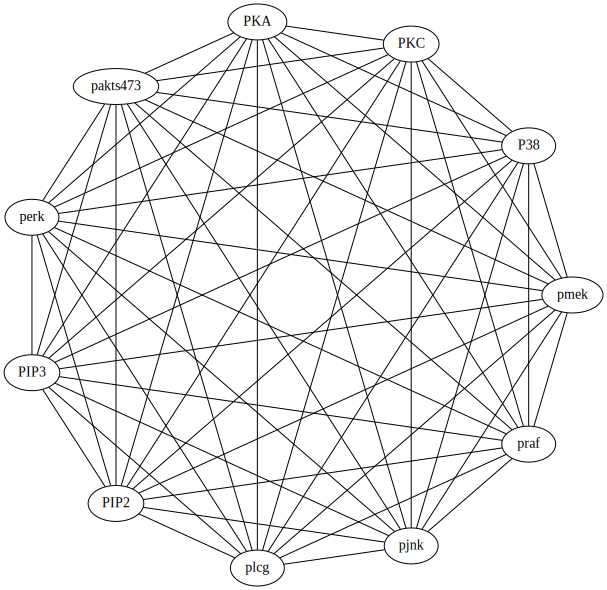

In [42]:
# Your code here
tester = IndependenceTester(data_exp1, ParCorr(), alpha=1)

G = PC_algorithm(11, tester)
graph_to_graphviz(G, list(data_exp1.columns))


Now let's look at what else is in the dataset: the interventional data corresponding to different experiments.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [45]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp5 = all_data[all_data.experiment==5]
data_exp6 = all_data[all_data.experiment==6]

data_exp1_5 = pd.concat([data_exp1, data_exp5], sort=False)
data_exp1_6 = pd.concat([data_exp1, data_exp6], sort=False)

In [47]:
data_exp1_5

praf      pmek      plcg      PIP2      PIP3      perk  pakts473  \
0     3.273364  2.580217  2.177022  2.906901  4.074142  1.888584  2.833213   
1     3.580737  2.803360  2.509599  2.821379  2.095561  2.923162  3.481240   
2     4.084294  3.786460  2.681022  2.322388  2.564949  2.701361  3.481240   
3     4.290459  4.416428  3.139833  2.602690  0.254642  1.763017  2.468100   
4     3.517498  2.985682  1.646734  2.275214  3.210844  3.049273  3.830813   
...        ...       ...       ...       ...       ...       ...       ...   
4194  4.110874  3.713572  1.376244  1.366092  2.985682  3.317816  3.795489   
4195  4.254193  3.202746  0.000000  1.510722  3.758872  4.370713  5.043425   
4196  4.136765  3.139833  1.205971  1.196948  2.660260  2.674149  3.317816   
4197  4.727388  4.290459  0.000000  0.270027  2.442347  2.167910  3.437208   
4198  4.515245  3.218876  1.465568  0.378436  2.906901  2.005526  2.850707   

           PKA       PKC       P38      pjnk  experiment  
0     6.025866  2.833213  3.804438  3.688879           1  
1     5.863631  1.214913  2.803360  4.119037           1  
2     5.998937  2.433613  3.462606  2.970414           1  
3     6.269096  2.617396  3.353407  3.139833           1  
4     5.720312  1.539015  3.246491  4.398146           1  
...        ...       ...       ...       ...         ...  
4194  5.872118  3.363842  4.237001  3.552487           5  
4195  7.708411  1.376244  2.484907  3.508556           5  
4196  5.872118  2.879198  3.407842  1.223775           5  
4197  6.188264  3.688879  4.380776  3.777348           5  
4198  6.070738  1.853168  3.543854  5.164786           5  

[1663 rows x 12 columns]

In [46]:
data_exp1_6

praf      pmek      plcg      PIP2      PIP3      perk  pakts473  \
0     3.273364  2.580217  2.177022  2.906901  4.074142  1.888584  2.833213   
1     3.580737  2.803360  2.509599  2.821379  2.095561  2.923162  3.481240   
2     4.084294  3.786460  2.681022  2.322388  2.564949  2.701361  3.481240   
3     4.290459  4.416428  3.139833  2.602690  0.254642  1.763017  2.468100   
4     3.517498  2.985682  1.646734  2.275214  3.210844  3.049273  3.830813   
...        ...       ...       ...       ...       ...       ...       ...   
4993  4.056989  4.515245  2.844909  2.753661  1.879465  1.591274  3.561046   
4994  5.846439  6.386879  2.753661  2.493205  2.975530  0.000000  4.074142   
4995  4.779123  5.056246  2.602690  4.795791  3.696351  0.989541  3.885679   
4996  5.416100  5.872118  2.797281  2.995732  2.221375  3.020425  5.332719   
4997  4.709530  4.990433  1.332366  2.370244  3.391147  2.033398  3.912023   

           PKA       PKC       P38      pjnk  experiment  
0     6.025866  2.833213  3.804438  3.688879           1  
1     5.863631  1.214913  2.803360  4.119037           1  
2     5.998937  2.433613  3.462606  2.970414           1  
3     6.269096  2.617396  3.353407  3.139833           1  
4     5.720312  1.539015  3.246491  4.398146           1  
...        ...       ...       ...       ...         ...  
4993  4.804021  0.277632  3.005683  1.501853           6  
4994  5.062595  0.576613  3.471966  1.465568           6  
4995  5.147494  2.501436  3.374169  3.650658           6  
4996  8.014005  3.039749  4.434382  3.841601           6  
4997  6.980076  0.746688  2.985682  1.026042           6  

[1652 rows x 12 columns]

**Question**: In the dataframe for experiments 1 and 5, look at PIP2 and the variables that were adjacent to it in the output of PC. Based on looking at some plots, does the data give evidence for or against the hypothesis that psitectorigenin modifies PIP2? And what does the data for the two experiments seem to say about the directions of the arrows between PIP2 and its neighbours?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Put your answer in markdown boxes, not as comments in your code!)

**Question**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables you think might be relevant. Assume it is true that adding U0126 produces an intervention on the activity of pmek. What would you expect to see in the data if the graph found by PC was correct? What changes would you propose to that graph based on the data?

Again put your answer with accompanying plots in new boxes below here.

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.